In [1]:
# DASK client set

import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

# get path for path changes in Jupyter notebook: File - Open from Path - insert relative_path
notebook_path = os.path.abspath(".")
_, _, relative_path = notebook_path.partition('/all/')
relative_path = '/all/' + relative_path
relative_path

'/all/Model/CESM2/Earth_System_Predictability/DIC'

# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.interpolate import griddata
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_NWP_preprocessing import CESM2_NWP_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [4]:
# 1. DIC (Total)
cfg_var_DIC=CESM2_NWP_config()
cfg_var_DIC.year_s=1955
cfg_var_DIC.year_e=2020
cfg_var_DIC.setvar('DIC')

# 2. TEMP (Total)
cfg_var_TEMP=CESM2_NWP_config()
cfg_var_TEMP.year_s=1955
cfg_var_TEMP.year_e=2020
cfg_var_TEMP.setvar('TEMP')

if cfg_var_DIC.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

# Read dataset

In [91]:
# define preprocessing function

exceptcv=['time','lon','lat','lev', 'TAREA', 'TLONG', 'TLAT', 'z_t', 'z_t_2', cfg_var_DIC.var, cfg_var_TEMP.var]
# exceptcv=['time','lon','lat','lev', 'TAREA', 'TLONG', 'TLAT', 'z_t', 'dz', 'z_t_2', cfg_var_DIC.var, cfg_var_TEMP.var]

def process_coords_3d(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        # ds = ds.isel(z_t=slice(0, 39)) # ~39 layer (1000m)
        # ds = (ds.isel(z_t=slice(1, 39)) * ds.dz).sum(dim='z_t') / ds.dz.sum(dim='z_t')
        return ds
    else:
        return ds.set_coords(coord_vars)



def process_coords_3d_LE(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """
    Preprocessor function for CESM POP-style datasets.
    - Normalizes vertical coordinate: if z_t or z_t_2 exists, rename to 'depth'.
    - Replaces its values with z_t_new for consistency.
    - Optionally drops unnecessary coordinate variables for faster concatenation.
    """
    z_t_new = np.array([5.0000000e+00, 1.5000000e+01, 2.5000000e+01, 3.5000000e+01,
       4.5000000e+01, 5.5000000e+01, 6.5000000e+01, 7.5000000e+01,
       8.5000000e+01, 9.5000000e+01, 1.0500000e+02, 1.1500000e+02,
       1.2500000e+02, 1.3500000e+02, 1.4500000e+02, 1.5500000e+02,
       1.6509839e+02, 1.7547903e+02, 1.8629126e+02, 1.9766026e+02,
       2.0971138e+02, 2.2257828e+02, 2.3640883e+02, 2.5137015e+02,
       2.6765421e+02, 2.8548364e+02, 3.0511920e+02, 3.2686798e+02,
       3.5109348e+02, 3.7822760e+02, 4.0878464e+02, 4.4337769e+02,
       4.8273669e+02, 5.2772797e+02, 5.7937286e+02, 6.3886261e+02,
       7.0756329e+02, 7.8700250e+02, 8.7882520e+02, 9.8470581e+02,
       1.1062042e+03, 1.2445669e+03, 1.4004972e+03, 1.5739464e+03,
       1.7640033e+03, 1.9689442e+03, 2.1864565e+03, 2.4139714e+03,
       2.6490012e+03, 2.8893845e+03, 3.1334045e+03, 3.3797935e+03,
       3.6276702e+03, 3.8764519e+03, 4.1257681e+03, 4.3753926e+03,
       4.6251904e+03, 4.8750835e+03, 5.1250278e+03, 5.3750000e+03])
    
    # ------------------------------------------------------
    # 1️⃣ Normalize vertical coordinate name
    # ------------------------------------------------------
    if "z_t_2" in ds.dims:
        ds = ds.rename({"z_t_2": "depth"})
    elif "z_t" in ds.dims:
        ds = ds.rename({"z_t": "depth"})
    else:
        print("[Warning] No vertical coordinate (z_t or z_t_2) found — skipped.")
        return ds

    # Drop any leftover z_t/z_t_2 coordinate variable if it exists
    ds = ds.drop_vars(["z_t", "z_t_2"], errors="ignore")

    # ------------------------------------------------------
    # 2️⃣ Replace coordinate values with z_t_new
    # ------------------------------------------------------
    if "depth" in ds.coords:
        if len(ds["depth"]) == len(z_t_new):
            ds = ds.assign_coords(depth=z_t_new)
        else:
            print(f"[Warning] depth length mismatch: {len(ds['depth'])} vs {len(z_t_new)}")
    else:
        print("[Warning] depth coordinate missing after renaming.")

    # ------------------------------------------------------
    # 3️⃣ Clean up coordinate references inside variable attributes
    # ------------------------------------------------------
    for v in ds.data_vars:
        if "coordinates" in ds[v].attrs:
            ds[v].attrs["coordinates"] = (
                ds[v].attrs["coordinates"]
                .replace("z_t_2", "depth")
                .replace("z_t", "depth")
            )

    # ------------------------------------------------------
    # 4️⃣ Drop unnecessary coordinate variables and slice time
    # ------------------------------------------------------
    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars, errors="ignore")
        ds = ds.sel(time=slice(sd, ed))
    else:
        ds = ds.set_coords(coord_vars)

    return ds



# exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_t', cfg_var_DIC.var, cfg_var_Li_diat.var, cfg_var_Li_sp.var,
#          cfg_var_Vi_diat_Fe.var, cfg_var_Vi_diat_N.var, cfg_var_Vi_diat_P.var, cfg_var_Vi_diat_SiO3.var,
#          cfg_var_Vi_sp_Fe.var, cfg_var_Vi_sp_N.var, cfg_var_Vi_sp_P.var,
#          cfg_var_NPP_diat.var, cfg_var_NPP_sp.var]
# def process_coords(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
#     """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
#     coord_vars = []
#     for v in np.array(ds.coords) :
#         if not v in except_coord_vars:
#             coord_vars += [v]
#     for v in np.array(ds.data_vars) :
#         if not v in except_coord_vars:
#             coord_vars += [v]
    
#     if drop:
#         ds= ds.drop(coord_vars)
#         ds= ds.sel(time=slice(sd, ed))
#         return ds
#     else:
#         return ds.set_coords(coord_vars)

start_date = cftime.DatetimeNoLeap(cfg_var_DIC.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_DIC.year_e+1, 1, 1)


# ds = ds.isel(lev=slice(1, 11))

In [93]:
cfg_var_DIC.LE_ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 792, ens_LE: 1, nlat: 105, nlon: 73, depth: 60)
Coordinates:
    TLONG    (nlat, nlon) float64 61kB dask.array<chunksize=(105, 73), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 61kB dask.array<chunksize=(105, 73), meta=np.ndarray>
  * ens_LE   (ens_LE) int64 8B 11
  * time     (time) object 6kB 1955-01-17 00:00:00 ... 2020-12-17 00:00:00
Dimensions without coordinates: nlat, nlon, depth
Data variables:
    TAREA    (time, ens_LE, nlat, nlon) float64 49MB dask.array<chunksize=(60, 1, 105, 73), meta=np.ndarray>
    DIC      (ens_LE, time, depth, nlat, nlon) float32 1GB dask.array<chunksize=(1, 12, 1, 105, 73), meta=np.ndarray>
Attributes: (12/13)
    CDI:               Climate Data Interface version 2.5.2 (https://mpimet.m...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    source:            CCSM POP2, the CCSM Ocean Component
    title:             b.e21.BHISTsmbb.f09_g17.LE2-1231.012
    history:           Wed Nov 26 11:07:50 2025: cdo -z zip_5 -O -w -selindex...
    time_period_freq:  month_1
    ...                ...
    contents:          Diagnostic and Prognostic Variables
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2020-11-12 at 11:25:05.9
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    CDO:               Climate Data Operators version 2.5.2 (https://mpimet.m...

In [94]:
# Read LE dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#DIC
cfg_var_DIC.LE_path_load(cfg_var_DIC.var)
cfg_var_DIC.LE_ds = xr.open_mfdataset(cfg_var_DIC.LE_file_list[0][11:12], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC.LE_ensembles][11:12], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d_LE(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_DIC.LE_ds = cfg_var_DIC.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_DIC.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC.LE_ds.time))
cfg_var_DIC.LE_ds = cfg_var_DIC.LE_ds.assign_coords(time=new_time)
cfg_var_DIC.LE_ds = cfg_var_DIC.LE_ds.rename({"depth": "z_t"})

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

elasped time for reading LE: 1.6056618690490723


In [6]:
# Read ADA dataset

# Quicker test for 2 ensembADAs only

start_time = time.time()

#DIC
cfg_var_DIC.ADA_path_load(cfg_var_DIC.var)
cfg_var_DIC.ADA_ds = xr.open_mfdataset(cfg_var_DIC.ADA_file_list[0][5:6], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC.ADA_ensembles][5:6], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_DIC.ADA_ds = cfg_var_DIC.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_DIC.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC.ADA_ds.time))
cfg_var_DIC.ADA_ds = cfg_var_DIC.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))

elasped time for reading ADA: 3.168145179748535


In [13]:
# Read WDA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#DIC
cfg_var_DIC.WDA_path_load(cfg_var_DIC.var)
cfg_var_DIC.WDA_ds = xr.open_mfdataset(cfg_var_DIC.WDA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC.WDA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_DIC.WDA_ds = cfg_var_DIC.WDA_ds.rename({"concat_dim": "ens_WDA"})
new_time = cfg_var_DIC.WDA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC.WDA_ds.time))
cfg_var_DIC.WDA_ds = cfg_var_DIC.WDA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading WDA: ' + str(elapsed_time))

elasped time for reading WDA: 1.6198182106018066


In [14]:
# Read ODA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#DIC
cfg_var_DIC.ODA_path_load(cfg_var_DIC.var)
cfg_var_DIC.ODA_ds = xr.open_mfdataset(cfg_var_DIC.ODA_file_list[0][15:16], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC.ODA_ensembles][15:16], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC.ODA_ds = cfg_var_DIC.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_DIC.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC.ODA_ds.time))
cfg_var_DIC.ODA_ds = cfg_var_DIC.ODA_ds.assign_coords(time=new_time)


# cfg_var_DIC.ODA_path_load(cfg_var_DIC.var)
# cfg_var_DIC.ODA_file_list[0]

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

In [15]:

start_time = time.time()

#regrids
import xcesm

# cfg_var_DIC.ODA_ds_rgd = cfg_var_DIC.ODA_ds['DIC'].isel(ens_ODA=5).utils.regrid()
# cfg_var_DIC.ADA_ds_rgd = cfg_var_DIC.ADA_ds['DIC'].isel(ens_ADA=5).utils.regrid()
# cfg_var_DIC.WDA_ds_rgd = cfg_var_DIC.WDA_ds['DIC'].isel(ens_WDA=0).utils.regrid()

lat_range = slice(10, 60)
lon_range = slice(110, 190)

# cfg_var_DIC.ODA_ds_rgd = (
#     cfg_var_DIC.ODA_ds['DIC']
#     .isel(ens_ODA=5)
#     .utils.regrid()
#     .sel(lat=lat_range, lon=lon_range)
# )

# cfg_var_DIC.ADA_ds_rgd = (
#     cfg_var_DIC.ADA_ds['DIC']
#     .isel(ens_ADA=5)
#     .utils.regrid()
#     .sel(lat=lat_range, lon=lon_range)
# )

# cfg_var_DIC.WDA_ds_rgd = (
#     cfg_var_DIC.WDA_ds['DIC']
#     .isel(ens_WDA=0)
#     .utils.regrid()
#     .sel(lat=lat_range, lon=lon_range)
# )

# DIC_LE_fixed = cfg_var_DIC.LE_ds['DIC'].isel(z_t_2=0)
# DIC_LE_fixed = DIC_LE_fixed.transpose('ens_LE', 'time', 'z_t', 'nlat', 'nlon')

cfg_var_DIC.LE_ds_rgd = (
    cfg_var_DIC.LE_ds['DIC']
    .isel(ens_LE=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_DIC.ODA_ds_rgd = (
    cfg_var_DIC.ODA_ds['DIC']
    .isel(ens_ODA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_DIC.ADA_ds_rgd = (
    cfg_var_DIC.ADA_ds['DIC']
    .isel(ens_ADA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_DIC.WDA_ds_rgd = (
    cfg_var_DIC.WDA_ds['DIC']
    .isel(ens_WDA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

# cfg_var_DIC.WDA_ds_rgd = cfg_var_DIC.WDA_ds_rgd.sortby("time").isel(time=slice(0,696))
# cfg_var_DIC.ADA_ds_rgd = cfg_var_DIC.ADA_ds_rgd.sortby("time").isel(time=slice(0,696))
# cfg_var_DIC.ODA_ds_rgd = cfg_var_DIC.ODA_ds_rgd.sortby("time").isel(time=slice(0,696))

cfg_var_DIC.LE_ds_rgd = cfg_var_DIC.LE_ds_rgd.sortby("time")
cfg_var_DIC.WDA_ds_rgd = cfg_var_DIC.WDA_ds_rgd.sortby("time")
cfg_var_DIC.ADA_ds_rgd = cfg_var_DIC.ADA_ds_rgd.sortby("time")
cfg_var_DIC.ODA_ds_rgd = cfg_var_DIC.ODA_ds_rgd.sortby("time")


cfg_var_DIC.LE_ds_rgd = cfg_var_DIC.LE_ds_rgd.assign_coords(z_t = cfg_var_DIC.ODA_ds_rgd.z_t)


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding: ' + str(elapsed_time))

In [96]:
# cfg_var_DIC.LE_ds_rgd = (
#     cfg_var_DIC.LE_ds['DIC']
#     .isel(ens_LE=0)
#     .utils.regrid()
#     .sel(lat=lat_range, lon=lon_range)
# )

# cfg_var_DIC.LE_ds_rgd = cfg_var_DIC.LE_ds_rgd.sortby("time")

In [97]:
# DIC_LE_fixed = cfg_var_DIC.LE_ds['DIC'].isel(z_t_2=0)
# DIC_LE_fixed = DIC_LE_fixed.transpose('ens_LE', 'time', 'z_t', 'nlat', 'nlon')

# cfg_var_DIC.LE_ds_rgd = (
#     DIC_LE_fixed
#     .isel(ens_LE=0)
#     .utils.regrid()
#     .sel(lat=lat_range, lon=lon_range)
# )
# cfg_var_DIC.LE_ds_rgd = cfg_var_DIC.LE_ds_rgd.sortby("time")



In [39]:
import numpy  as np
import pandas as pd
import xarray as xr

def to_xarray(data, lat, lon, name='variable', freq='M', ens=None):
    time = pd.date_range("1958-01-01", "2020-12-31", freq=freq)
    depth = np.array([5.0000000e+00, 1.5000000e+01, 2.5000000e+01, 3.5000000e+01,
       4.5000000e+01, 5.5000000e+01, 6.5000000e+01, 7.5000000e+01,
       8.5000000e+01, 9.5000000e+01, 1.0500000e+02, 1.1500000e+02,
       1.2500000e+02, 1.3500000e+02, 1.4500000e+02, 1.5500000e+02,
       1.6509839e+02, 1.7547903e+02, 1.8629126e+02, 1.9766026e+02,
       2.0971138e+02, 2.2257828e+02, 2.3640883e+02, 2.5137015e+02,
       2.6765421e+02, 2.8548364e+02, 3.0511920e+02, 3.2686798e+02,
       3.5109348e+02, 3.7822760e+02, 4.0878464e+02, 4.4337769e+02,
       4.8273669e+02, 5.2772797e+02, 5.7937286e+02, 6.3886261e+02,
       7.0756329e+02, 7.8700250e+02, 8.7882520e+02, 9.8470581e+02,
       1.1062042e+03, 1.2445669e+03, 1.4004972e+03, 1.5739464e+03,
       1.7640033e+03, 1.9689442e+03, 2.1864565e+03, 2.4139714e+03,
       2.6490012e+03, 2.8893845e+03, 3.1334045e+03, 3.3797935e+03,
       3.6276702e+03, 3.8764519e+03, 4.1257681e+03, 4.3753926e+03,
       4.6251904e+03, 4.8750835e+03, 5.1250278e+03, 5.3750000e+03])

    if ens is None:
        dims = ['time', 'depth', 'lat', 'lon']
        coords = {'time': time, 'depth': depth, 'lat': lat, 'lon': lon}
    else:
        ens = np.asarray(ens)
        dims = ['ens', 'time', 'depth', 'lat', 'lon']
        coords = {'ens': ens, 'time': time, 'depth': depth, 'lat': lat, 'lon': lon}
    da = xr.DataArray(data, name=name, dims=dims, coords=coords)
    return da

indir = '/mnt/lustre/proj/kimyy/tr_sysong/'
fyear = '1958'; eyear = '2017'; lat = np.arange(10,60.1,1); lon = np.arange(110,190.1,1)

data = np.load(indir+'/NPSTMW_STMWW_16to20.npz')
OBS_STMWW = to_xarray(data['OBS_STMWW'], lat, lon, name='OBS_STMWW').sel(time=slice(fyear,eyear))
ODA_STMWW = to_xarray(data['ODA_STMWW'], lat, lon, name='ODA_STMWW', ens=np.arange(1,10.1,1)).sel(time=slice(fyear,eyear))
WDA_STMWW = to_xarray(data['WDA_STMWW'], lat, lon, name='WDA_STMWW').sel(time=slice(fyear,eyear))
ADA_STMWW = to_xarray(data['ADA_STMWW'], lat, lon, name='ADA_STMWW', ens=np.arange(1,10.1,1)).sel(time=slice(fyear,eyear))
LE2_STMWW = to_xarray(data['LE2_STMWW'], lat, lon, name='LE2_STMWW', ens=np.arange(1,50.1,1)).sel(time=slice(fyear,eyear))

In [44]:
# ODA_STMWW_rgd = ODA_STMWW.isel(time=slice(24,720)).isel(lon=slice(0,70)).isel(depth=slice(0,39)).isel(ens=5)
ODA_STMWW_rgd = ODA_STMWW.isel(lon=slice(0,70)).isel(ens=5)
ODA_STMWW_rgd = ODA_STMWW_rgd.rename({"depth": "z_t"})
ODA_STMWW_rgd = ODA_STMWW_rgd.assign_coords(z_t = cfg_var_DIC.ODA_ds_rgd.z_t)
ODA_STMWW_rgd = ODA_STMWW_rgd.assign_coords(time = cfg_var_DIC.ODA_ds_rgd.time.sel(time=slice("1958-01-01", "2017-12-31")))

# WDA_STMWW_rgd = WDA_STMWW.isel(time=slice(24,720)).isel(lon=slice(0,70)).isel(depth=slice(0,39))
WDA_STMWW_rgd = WDA_STMWW.isel(lon=slice(0,70))
WDA_STMWW_rgd = WDA_STMWW_rgd.rename({"depth": "z_t"})
WDA_STMWW_rgd = WDA_STMWW_rgd.assign_coords(z_t = cfg_var_DIC.ODA_ds_rgd.z_t)
WDA_STMWW_rgd = WDA_STMWW_rgd.assign_coords(time = cfg_var_DIC.ODA_ds_rgd.time.sel(time=slice("1958-01-01", "2017-12-31")))

# ADA_STMWW_rgd = ADA_STMWW.isel(time=slice(24,720)).isel(lon=slice(0,70)).isel(depth=slice(0,39)).isel(ens=5)
ADA_STMWW_rgd = ADA_STMWW.isel(lon=slice(0,70)).isel(ens=5)
ADA_STMWW_rgd = ADA_STMWW_rgd.rename({"depth": "z_t"})
ADA_STMWW_rgd = ADA_STMWW_rgd.assign_coords(z_t = cfg_var_DIC.ODA_ds_rgd.z_t)
ADA_STMWW_rgd = ADA_STMWW_rgd.assign_coords(time = cfg_var_DIC.ODA_ds_rgd.time.sel(time=slice("1958-01-01", "2017-12-31")))

LE_STMWW_rgd = LE2_STMWW.isel(lon=slice(0,70)).isel(ens=5)
LE_STMWW_rgd = LE_STMWW_rgd.rename({"depth": "z_t"})
LE_STMWW_rgd = LE_STMWW_rgd.assign_coords(z_t = cfg_var_DIC.ODA_ds_rgd.z_t)
LE_STMWW_rgd = LE_STMWW_rgd.assign_coords(time = cfg_var_DIC.ODA_ds_rgd.time.sel(time=slice("1958-01-01", "2017-12-31")))

In [58]:
# LE_STMWW_rgd = LE2_STMWW.isel(lon=slice(0,70)).isel(ens=5)
# LE_STMWW_rgd = LE_STMWW_rgd.rename({"depth": "z_t"})
# LE_STMWW_rgd = LE_STMWW_rgd.assign_coords(z_t = cfg_var_DIC.ODA_ds_rgd.z_t)
# LE_STMWW_rgd = LE_STMWW_rgd.assign_coords(time = cfg_var_DIC.ODA_ds_rgd.time.sel(time=slice("1958-01-01", "2017-12-31")))

In [98]:
ODA_LE = cfg_var_DIC.ODA_ds_rgd - cfg_var_DIC.LE_ds_rgd
ODA_LE = ODA_LE.assign_coords(z_t = -ODA_LE.z_t / 100.0)
WDA_LE = cfg_var_DIC.WDA_ds_rgd - cfg_var_DIC.LE_ds_rgd
WDA_LE = WDA_LE.assign_coords(z_t = -WDA_LE.z_t / 100.0)

ADA_WDA = cfg_var_DIC.ADA_ds_rgd - cfg_var_DIC.WDA_ds_rgd
ADA_WDA = ADA_WDA.assign_coords(z_t = -ADA_WDA.z_t / 100.0)
ADA_ODA = cfg_var_DIC.ADA_ds_rgd - cfg_var_DIC.ODA_ds_rgd
ADA_ODA = ADA_ODA.assign_coords(z_t = -ADA_ODA.z_t / 100.0)

# ADA_WDA.sel(lon=135).mean(dim='time').sel(z_t=slice(-5, -400)).plot()
# ADA_WDA.sel(lon=slice(135,170)).mean(dim='lon').mean(dim='time').sel(z_t=slice(-5, -400)).sel(lat=slice(15,40)).plot()
# ADA_ODA.sel(lon=slice(135,170)).mean(dim='lon').mean(dim='time').sel(z_t=slice(-5, -400)).sel(lat=slice(15,40)).plot()

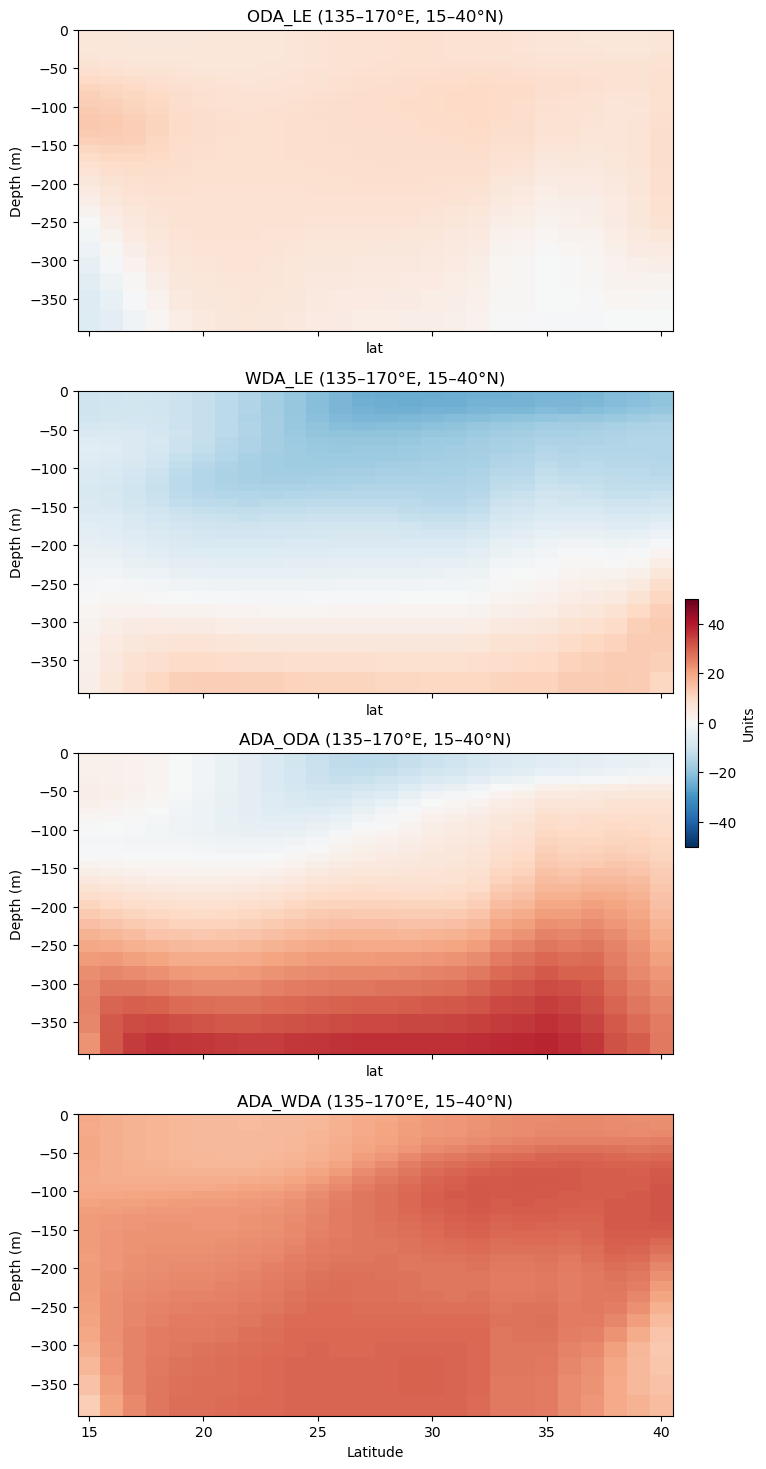

In [99]:
import matplotlib.pyplot as plt

# ---------------------------
# Data 준비
# ---------------------------
# 위도, 경도, 깊이 범위
lon_slice = slice(135, 170)
lat_slice = slice(15, 40)
z_slice   = slice(-5, -400)

# 1) ODA_LE, WDA_LE
ds_LE_ODA = ODA_LE.sel(lon=lon_slice, lat=lat_slice, z_t=z_slice).mean(dim=['lon', 'time'])
ds_LE_WDA = WDA_LE.sel(lon=lon_slice, lat=lat_slice, z_t=z_slice).mean(dim=['lon', 'time'])

# 2) ADA 관련
ds_ADA_ODA = ADA_ODA.sel(lon=lon_slice, lat=lat_slice, z_t=z_slice).mean(dim=['lon', 'time'])
ds_ADA_WDA = ADA_WDA.sel(lon=lon_slice, lat=lat_slice, z_t=z_slice).mean(dim=['lon', 'time'])

# ---------------------------
# Figure 생성 (4행 1열)
# ---------------------------
fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(8, 18), sharex=True
)

# ---------------------------
# Plot 설정
# ---------------------------
plot_kw = dict(y='z_t', vmin=-50, vmax=50, cmap='RdBu_r', add_colorbar=False)

# (1) ODA_LE
p1 = ds_LE_ODA.plot(ax=axes[0], **plot_kw)
axes[0].set_title("ODA_LE (135–170°E, 15–40°N)")

# (2) WDA_LE
p2 = ds_LE_WDA.plot(ax=axes[1], **plot_kw)
axes[1].set_title("WDA_LE (135–170°E, 15–40°N)")

# (3) ADA_ODA
p3 = ds_ADA_ODA.plot(ax=axes[2], **plot_kw)
axes[2].set_title("ADA_ODA (135–170°E, 15–40°N)")

# (4) ADA_WDA
p4 = ds_ADA_WDA.plot(ax=axes[3], **plot_kw)
axes[3].set_title("ADA_WDA (135–170°E, 15–40°N)")

# ---------------------------
# 컬러바 공통 추가
# ---------------------------
cbar = fig.colorbar(p4, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label("Units")

# 축 라벨 정리
axes[-1].set_xlabel("Latitude")
for ax in axes:
    ax.set_ylabel("Depth (m)")

# plt.tight_layout()
plt.show()


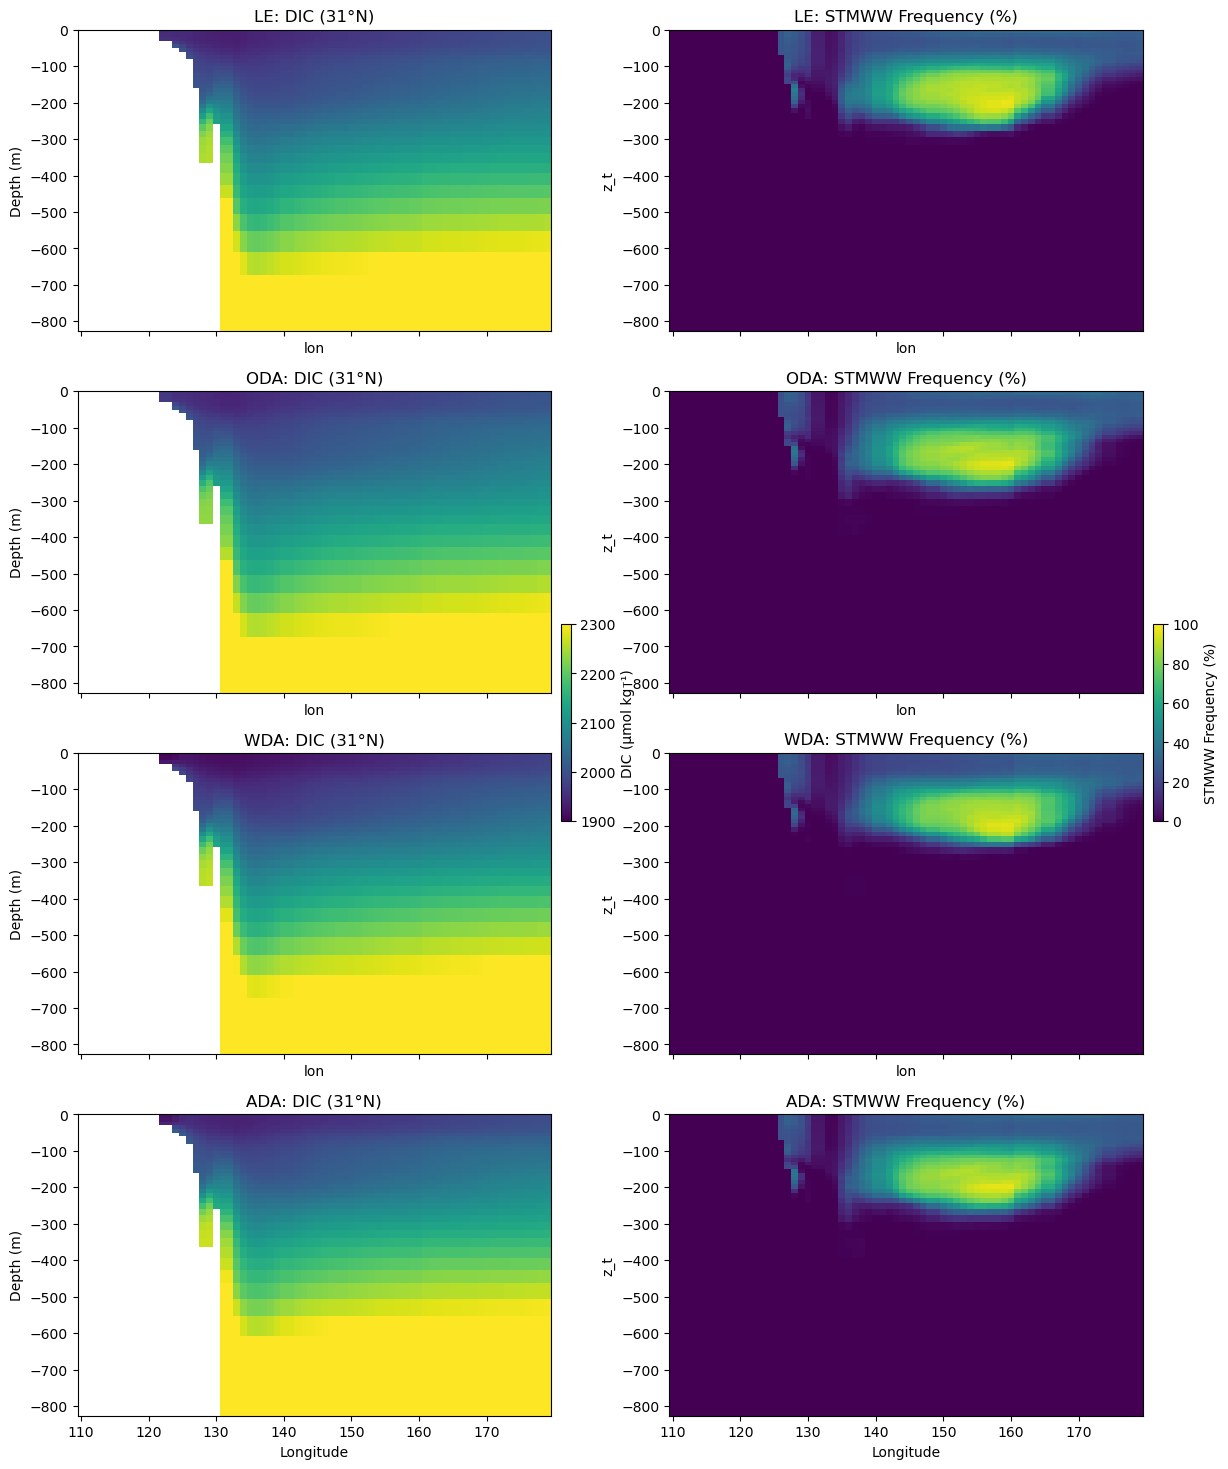

In [103]:
import matplotlib.pyplot as plt

# =====================================
# 0) Helper 함수 정의
# =====================================

def prepare_dic(ds):
    """DIC 필드: lat=31, time 평균, 깊이 선택"""
    ds = ds.assign_coords(z_t=-ds.z_t / 100.0)  # cm → m, 부호 반전
    return (
        ds
        .sel(lat=31, method="nearest")
        .mean(dim="time")
        .sel(z_t=slice(-5, -800))
    )

def prepare_mask(ds):
    """STMWW mask: lat=31, time 평균, 깊이 선택"""
    ds = ds.assign_coords(z_t=-ds.z_t / 100.0)  # cm → m, 부호 반전
    mask = ds.sel(lat=31, method="nearest").sel(z_t=slice(-5, -800))
    return mask.astype(float).mean(dim="time") * 100.0


# =====================================
# 1) DIC 데이터 준비
# =====================================
dic_LE  = prepare_dic(cfg_var_DIC.LE_ds_rgd)
dic_ODA = prepare_dic(cfg_var_DIC.ODA_ds_rgd)
dic_WDA = prepare_dic(cfg_var_DIC.WDA_ds_rgd)
dic_ADA = prepare_dic(cfg_var_DIC.ADA_ds_rgd)

# =====================================
# 2) STMWW mask 준비
# =====================================
mask_LE  = prepare_mask(LE_STMWW_rgd)
mask_ODA = prepare_mask(ODA_STMWW_rgd)
mask_WDA = prepare_mask(WDA_STMWW_rgd)
mask_ADA = prepare_mask(ADA_STMWW_rgd)

# =====================================
# 3) Figure 생성 (4행 2열)
# =====================================
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 18), sharex=True)

# ---- Plot 설정 ----
dic_kw  = dict(y="z_t", cmap="viridis", vmin=1900, vmax=2300, add_colorbar=False)
mask_kw = dict(y="z_t", cmap="viridis", vmin=0, vmax=100, add_colorbar=False)

# =====================================
# 1행: LE
# =====================================
p1 = dic_LE.plot(ax=axes[0, 0], **dic_kw)
axes[0, 0].set_title("LE: DIC (31°N)")
p2 = mask_LE.plot(ax=axes[0, 1], **mask_kw)
axes[0, 1].set_title("LE: STMWW Frequency (%)")

# =====================================
# 2행: ODA
# =====================================
p3 = dic_ODA.plot(ax=axes[1, 0], **dic_kw)
axes[1, 0].set_title("ODA: DIC (31°N)")
p4 = mask_ODA.plot(ax=axes[1, 1], **mask_kw)
axes[1, 1].set_title("ODA: STMWW Frequency (%)")

# =====================================
# 3행: WDA
# =====================================
p5 = dic_WDA.plot(ax=axes[2, 0], **dic_kw)
axes[2, 0].set_title("WDA: DIC (31°N)")
p6 = mask_WDA.plot(ax=axes[2, 1], **mask_kw)
axes[2, 1].set_title("WDA: STMWW Frequency (%)")

# =====================================
# 4행: ADA
# =====================================
p7 = dic_ADA.plot(ax=axes[3, 0], **dic_kw)
axes[3, 0].set_title("ADA: DIC (31°N)")
p8 = mask_ADA.plot(ax=axes[3, 1], **mask_kw)
axes[3, 1].set_title("ADA: STMWW Frequency (%)")

# =====================================
# 4) 컬러바 (공통)
# =====================================
cbar_dic = fig.colorbar(p1, ax=axes[:, 0], orientation="vertical", fraction=0.02, pad=0.02)
cbar_dic.set_label("DIC (µmol kg⁻¹)")

cbar_mask = fig.colorbar(p2, ax=axes[:, 1], orientation="vertical", fraction=0.02, pad=0.02)
cbar_mask.set_label("STMWW Frequency (%)")

# =====================================
# 5) 축 라벨 정리
# =====================================
for ax in axes[:, 0]:
    ax.set_ylabel("Depth (m)")
for ax in axes[-1, :]:
    ax.set_xlabel("Longitude")

# plt.tight_layout()
plt.show()


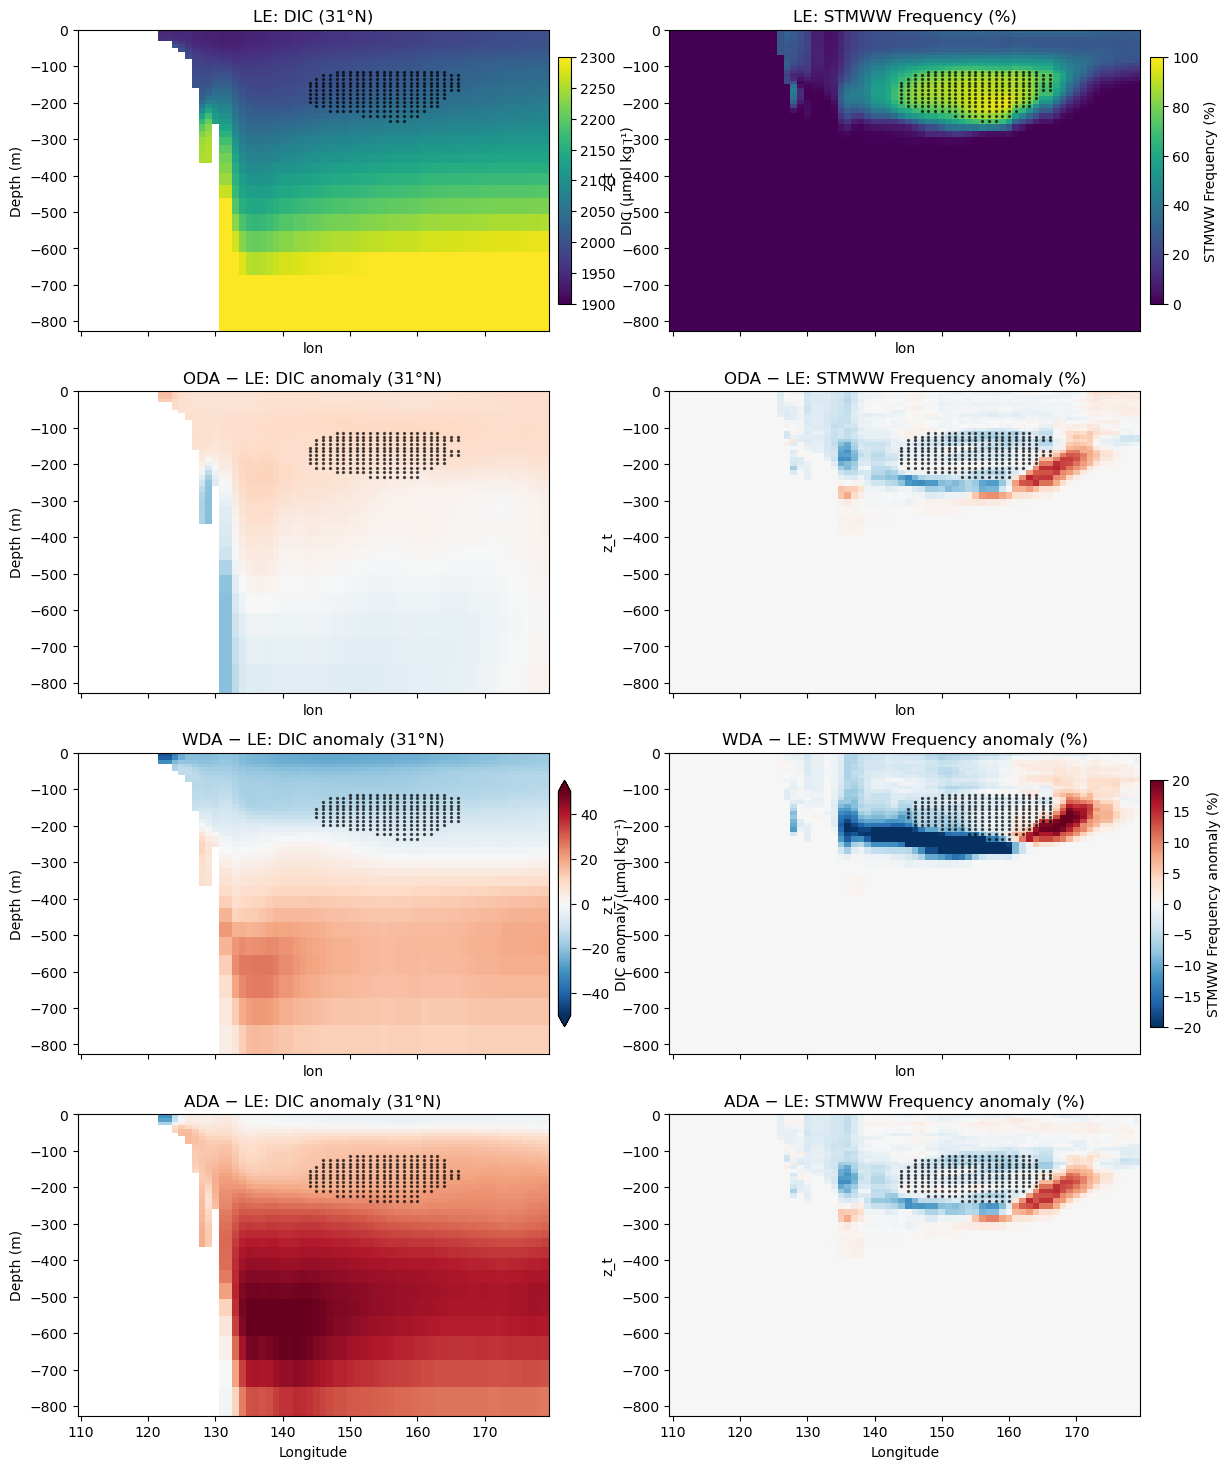

In [144]:
import numpy as np
import matplotlib.pyplot as plt

# =====================================
# 0) Helper functions
# =====================================

def prepare_dic(ds):
    """Prepare DIC field: select 31°N, take time mean, and restrict depth range."""
    ds = ds.assign_coords(z_t=-ds.z_t / 100.0)  # convert cm → m and flip sign
    return (
        ds
        .sel(lat=31, method="nearest")
        .mean(dim="time")
        .sel(z_t=slice(-5, -800))
    )

def prepare_mask(ds):
    """Prepare STMWW mask: select 31°N, take time mean, and restrict depth range."""
    ds = ds.assign_coords(z_t=-ds.z_t / 100.0)  # convert cm → m and flip sign
    mask = ds.sel(lat=31, method="nearest").sel(z_t=slice(-5, -800))
    return mask.astype(float).mean(dim="time") * 100.0


# =====================================
# 1) Prepare DIC data
# =====================================
dic_LE  = prepare_dic(cfg_var_DIC.LE_ds_rgd)
dic_ODA = prepare_dic(cfg_var_DIC.ODA_ds_rgd)
dic_WDA = prepare_dic(cfg_var_DIC.WDA_ds_rgd)
dic_ADA = prepare_dic(cfg_var_DIC.ADA_ds_rgd)

# =====================================
# 2) Prepare STMWW masks
# =====================================
mask_LE  = prepare_mask(LE_STMWW_rgd)
mask_ODA = prepare_mask(ODA_STMWW_rgd)
mask_WDA = prepare_mask(WDA_STMWW_rgd)
mask_ADA = prepare_mask(ADA_STMWW_rgd)

# =====================================
# 3) Compute anomalies relative to LE mean
# =====================================
dic_ODA_anom = dic_ODA - dic_LE
dic_WDA_anom = dic_WDA - dic_LE
dic_ADA_anom = dic_ADA - dic_LE

mask_ODA_anom = mask_ODA - mask_LE
mask_WDA_anom = mask_WDA - mask_LE
mask_ADA_anom = mask_ADA - mask_LE

# =====================================
# 4) Define helper to overlay mask ≥70% dots
# =====================================
def overlay_mask_dots(ax, mask, threshold=70, dot_kw=None):
    """Overlay dots where STMWW frequency ≥ threshold (%) on given axis."""
    if dot_kw is None:
        dot_kw = dict(color="k", s=8, marker=".", alpha=0.6)
    mask_bool = mask >= threshold
    lon2d, z2d = np.meshgrid(mask.lon, mask.z_t)
    lon_masked = lon2d[mask_bool.values]
    z_masked   = z2d[mask_bool.values]
    ax.scatter(lon_masked, z_masked, **dot_kw)


# =====================================
# 5) Create figure (4 rows × 2 columns)
# =====================================
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 18), sharex=True)

# ---- Plot styling ----
dic_kw_abs  = dict(y="z_t", cmap="viridis", vmin=1900, vmax=2300, add_colorbar=False)
dic_kw_anom = dict(y="z_t", cmap="RdBu_r", vmin=-50, vmax=50, add_colorbar=False)

mask_kw_abs  = dict(y="z_t", cmap="viridis", vmin=0, vmax=100, add_colorbar=False)
mask_kw_anom = dict(y="z_t", cmap="RdBu_r", vmin=-20, vmax=20, add_colorbar=False)

dot_kw = dict(color="k", s=8, marker=".", alpha=0.6)

# =====================================
# 1st row: LE (absolute)
# =====================================
p1 = dic_LE.plot(ax=axes[0, 0], **dic_kw_abs)
overlay_mask_dots(axes[0, 0], mask_LE, threshold=70, dot_kw=dot_kw)
axes[0, 0].set_title("LE: DIC (31°N)")

p2 = mask_LE.plot(ax=axes[0, 1], **mask_kw_abs)
overlay_mask_dots(axes[0, 1], mask_LE, threshold=70, dot_kw=dot_kw)  # <── added
axes[0, 1].set_title("LE: STMWW Frequency (%)")

# =====================================
# 2nd row: ODA anomalies
# =====================================
p3 = dic_ODA_anom.plot(ax=axes[1, 0], **dic_kw_anom)
overlay_mask_dots(axes[1, 0], mask_ODA, threshold=70, dot_kw=dot_kw)
axes[1, 0].set_title("ODA − LE: DIC anomaly (31°N)")

p4 = mask_ODA_anom.plot(ax=axes[1, 1], **mask_kw_anom)
overlay_mask_dots(axes[1, 1], mask_ODA, threshold=70, dot_kw=dot_kw)  # <── added
axes[1, 1].set_title("ODA − LE: STMWW Frequency anomaly (%)")

# =====================================
# 3rd row: WDA anomalies
# =====================================
p5 = dic_WDA_anom.plot(ax=axes[2, 0], **dic_kw_anom)
overlay_mask_dots(axes[2, 0], mask_WDA, threshold=70, dot_kw=dot_kw)
axes[2, 0].set_title("WDA − LE: DIC anomaly (31°N)")

p6 = mask_WDA_anom.plot(ax=axes[2, 1], **mask_kw_anom)
overlay_mask_dots(axes[2, 1], mask_WDA, threshold=70, dot_kw=dot_kw)  # <── added
axes[2, 1].set_title("WDA − LE: STMWW Frequency anomaly (%)")

# =====================================
# 4th row: ADA anomalies
# =====================================
p7 = dic_ADA_anom.plot(ax=axes[3, 0], **dic_kw_anom)
overlay_mask_dots(axes[3, 0], mask_ADA, threshold=70, dot_kw=dot_kw)
axes[3, 0].set_title("ADA − LE: DIC anomaly (31°N)")

p8 = mask_ADA_anom.plot(ax=axes[3, 1], **mask_kw_anom)
overlay_mask_dots(axes[3, 1], mask_ADA, threshold=70, dot_kw=dot_kw)  # <── added
axes[3, 1].set_title("ADA − LE: STMWW Frequency anomaly (%)")

# =====================================
# 6) Add shared colorbars
# =====================================
cbar_dic = fig.colorbar(p1, ax=axes[0, 0], orientation="vertical", fraction=0.025, pad=0.02)
cbar_dic.set_label("DIC (µmol kg⁻¹)")

cbar_mask = fig.colorbar(p2, ax=axes[0, 1], orientation="vertical", fraction=0.025, pad=0.02)
cbar_mask.set_label("STMWW Frequency (%)")

# 👉 Added extend='both' to show out-of-range anomaly extremes
cbar_dic_anom = fig.colorbar(
    p3, ax=axes[1:, 0], orientation="vertical", fraction=0.025, pad=0.02, extend='both'
)
cbar_dic_anom.set_label("DIC anomaly (µmol kg⁻¹)")

cbar_mask_anom = fig.colorbar(p4, ax=axes[1:, 1], orientation="vertical", fraction=0.025, pad=0.02)
cbar_mask_anom.set_label("STMWW Frequency anomaly (%)")

# =====================================
# 7) Axis labels
# =====================================
for ax in axes[:, 0]:
    ax.set_ylabel("Depth (m)")
for ax in axes[-1, :]:
    ax.set_xlabel("Longitude")

# plt.tight_layout()
plt.show()


Selected grid info:
LE  : lon=155.00,  lat=31.00,  z_t=-197.7 m
ADA : lon=155.00, lat=31.00, z_t=-197.7 m
WDA : lon=155.00, lat=31.00, z_t=-197.7 m
ODA : lon=155.00, lat=31.00, z_t=-197.7 m


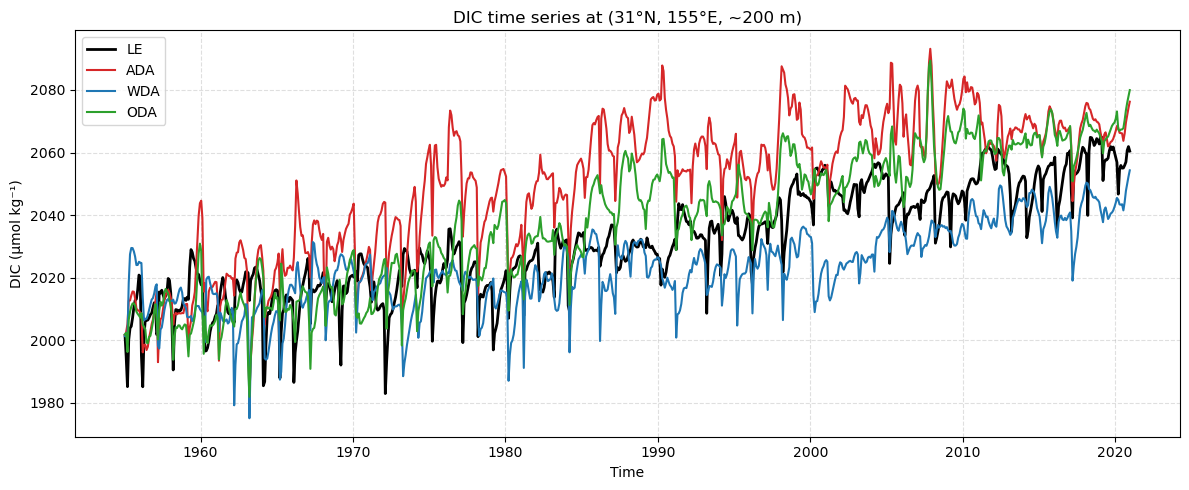

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    """Safely convert cftime.DatetimeNoLeap to numpy.datetime64 for plotting."""
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array(
        [np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values]
    )
    return da

# ==========================================================
# 2) Helper: extract single-point DIC time series
# ==========================================================
def extract_dic_point(ds_dic, lat_pt=31, lon_pt=155, depth_pt=-200):
    """
    Extract DIC time series at a specific point (nearest grid).
    Depth unit converted from cm→m and sign flipped.
    """
    # Convert z_t to m (positive down)
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    
    # Select nearest point
    da_point = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point

# ==========================================================
# 3) Extract time series for all datasets
# ==========================================================
ts_LE  = extract_dic_point(cfg_var_DIC.LE_ds_rgd)
ts_ADA = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
ts_WDA = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
ts_ODA = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

# Convert CFTime to datetime
ts_LE  = convert_cftime_to_datetime(ts_LE)
ts_ADA = convert_cftime_to_datetime(ts_ADA)
ts_WDA = convert_cftime_to_datetime(ts_WDA)
ts_ODA = convert_cftime_to_datetime(ts_ODA)

# ==========================================================
# 4) Print info to verify selection
# ==========================================================
print("Selected grid info:")
print(f"LE  : lon={float(ts_LE.lon.values):.2f},  lat={float(ts_LE.lat.values):.2f},  z_t={float(ts_LE.z_t.values):.1f} m")
print(f"ADA : lon={float(ts_ADA.lon.values):.2f}, lat={float(ts_ADA.lat.values):.2f}, z_t={float(ts_ADA.z_t.values):.1f} m")
print(f"WDA : lon={float(ts_WDA.lon.values):.2f}, lat={float(ts_WDA.lat.values):.2f}, z_t={float(ts_WDA.z_t.values):.1f} m")
print(f"ODA : lon={float(ts_ODA.lon.values):.2f}, lat={float(ts_ODA.lat.values):.2f}, z_t={float(ts_ODA.z_t.values):.1f} m")

# ==========================================================
# 5) Plot time series
# ==========================================================
plt.figure(figsize=(12, 5))
plt.plot(ts_LE.time,  ts_LE,  label="LE",  color="k", lw=2)
plt.plot(ts_ADA.time, ts_ADA, label="ADA", color="C3")
plt.plot(ts_WDA.time, ts_WDA, label="WDA", color="C0")
plt.plot(ts_ODA.time, ts_ODA, label="ODA", color="C2")

plt.title("DIC time series at (31°N, 155°E, ~200 m)")
plt.ylabel("DIC (µmol kg⁻¹)")
plt.xlabel("Time")
plt.legend()
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [146]:
hov_LE

<xarray.DataArray 'DIC' (time: 792, z_t: 0)> Size: 0B
array([], shape=(792, 0), dtype=float32)
Coordinates:
    lat      float64 8B 31.0
    lon      float64 8B 155.0
  * z_t      (z_t) float32 0B 
  * time     (time) datetime64[s] 6kB 1955-01-17 1955-02-14 ... 2020-12-17

Grid (LE): lon=155.00, lat=31.00


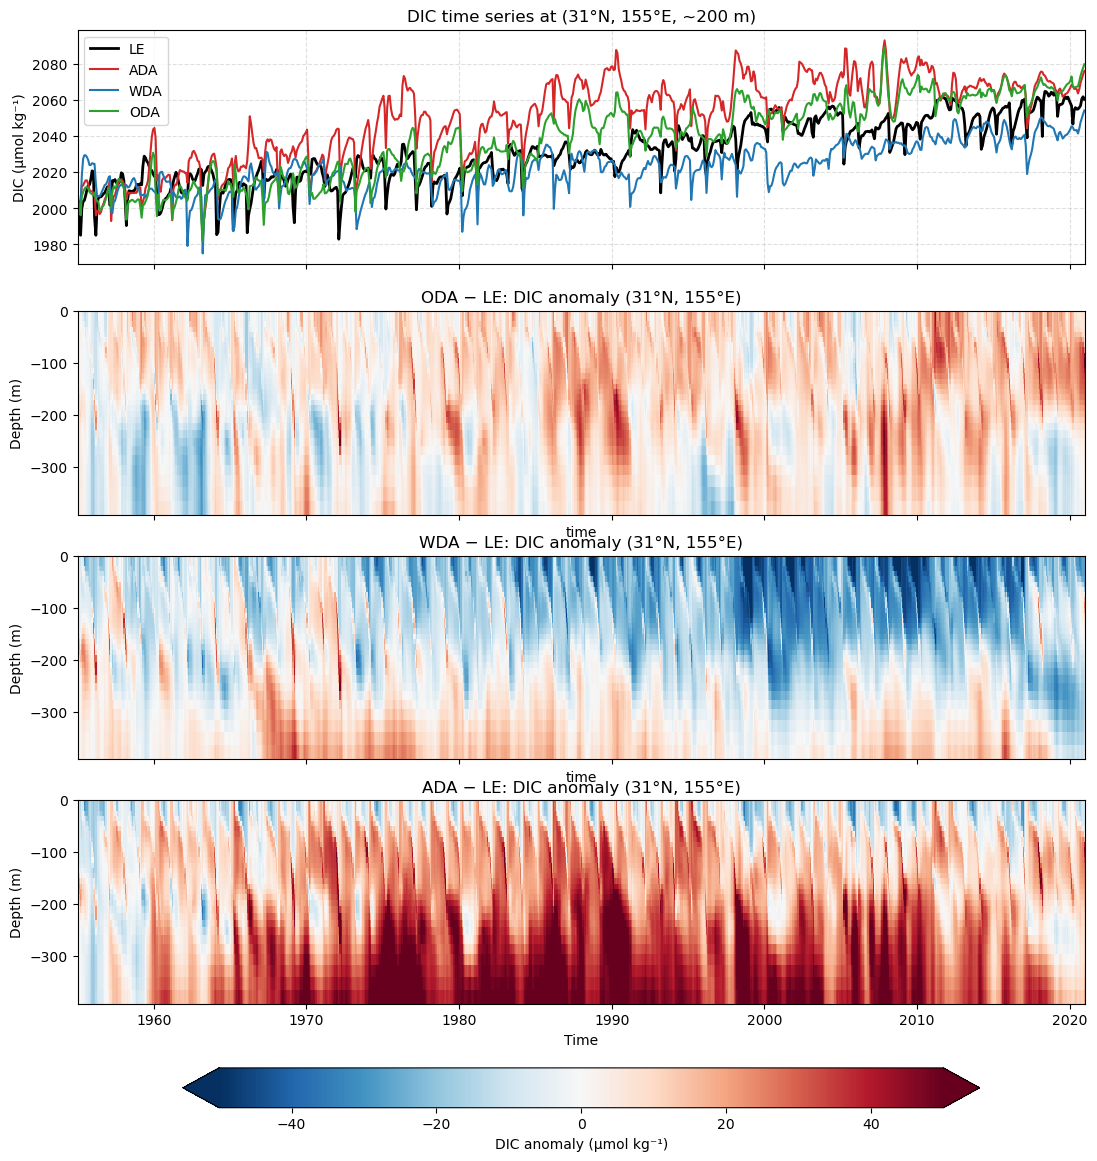

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    """Safely convert cftime.DatetimeNoLeap to numpy.datetime64 for plotting."""
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da


# ==========================================================
# 2) Helper: extract single-point DIC time series
# ==========================================================
def extract_dic_point(ds_dic, lat_pt=31, lon_pt=155, depth_pt=-200):
    """Extract DIC time series at a specific point (nearest grid)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm → m, flip sign
    da_point = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point


# ==========================================================
# 3) Helper: extract DIC time–depth section
# ==========================================================
def extract_dic_hovmoller(ds_dic, lat_pt=31, lon_pt=155, depth_range=(-5, -400)):
    """Extract DIC time–depth section (Hovmöller) at fixed (lat, lon)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da


# ==========================================================
# 4) Extract datasets
# ==========================================================
ts_LE  = extract_dic_point(cfg_var_DIC.LE_ds_rgd)
ts_ADA = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
ts_WDA = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
ts_ODA = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

hov_LE  = extract_dic_hovmoller(cfg_var_DIC.LE_ds_rgd)
hov_ADA = extract_dic_hovmoller(cfg_var_DIC.ADA_ds_rgd)
hov_WDA = extract_dic_hovmoller(cfg_var_DIC.WDA_ds_rgd)
hov_ODA = extract_dic_hovmoller(cfg_var_DIC.ODA_ds_rgd)

# Convert CFTime → datetime64
ts_LE, ts_ADA, ts_WDA, ts_ODA = map(convert_cftime_to_datetime, [ts_LE, ts_ADA, ts_WDA, ts_ODA])
hov_LE, hov_ADA, hov_WDA, hov_ODA = map(convert_cftime_to_datetime, [hov_LE, hov_ADA, hov_WDA, hov_ODA])

print(f"Grid (LE): lon={float(hov_LE.lon.values):.2f}, lat={float(hov_LE.lat.values):.2f}")

# ==========================================================
# 5) Compute anomalies (relative to LE)
# ==========================================================
hov_ADA_anom = hov_ADA - hov_LE
hov_WDA_anom = hov_WDA - hov_LE
hov_ODA_anom = hov_ODA - hov_LE


# ==========================================================
# 6) Create figure (4 rows: time series + 3 hovmöller anomalies)
# ==========================================================
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(13, 14), sharex=True)

# ---------- (1) Time series ----------
axes[0].plot(ts_LE.time,  ts_LE,  label="LE",  color="k", lw=2)
axes[0].plot(ts_ADA.time, ts_ADA, label="ADA", color="C3")
axes[0].plot(ts_WDA.time, ts_WDA, label="WDA", color="C0")
axes[0].plot(ts_ODA.time, ts_ODA, label="ODA", color="C2")
axes[0].set_title("DIC time series at (31°N, 155°E, ~200 m)")
axes[0].set_ylabel("DIC (µmol kg⁻¹)")
axes[0].grid(True, ls="--", alpha=0.4)
axes[0].legend()

# ---------- (2–4) Hovmöller anomalies ----------
plot_kw_anom = dict(x="time", y="z_t", cmap="RdBu_r", vmin=-50, vmax=50, add_colorbar=False)

# (2) ODA − LE
p1 = hov_ODA_anom.plot(ax=axes[1], **plot_kw_anom)
axes[1].set_title("ODA − LE: DIC anomaly (31°N, 155°E)")

# (3) WDA − LE
p2 = hov_WDA_anom.plot(ax=axes[2], **plot_kw_anom)
axes[2].set_title("WDA − LE: DIC anomaly (31°N, 155°E)")

# (4) ADA − LE
p3 = hov_ADA_anom.plot(ax=axes[3], **plot_kw_anom)
axes[3].set_title("ADA − LE: DIC anomaly (31°N, 155°E)")

# ---------- Axis setup ----------
for ax in axes[1:]:
    ax.set_ylabel("Depth (m)")
    # ax.invert_yaxis()  # reverse depth (surface up)
axes[-1].set_xlabel("Time")

# ---------- Shared horizontal colorbar (bottom) ----------
cbar = fig.colorbar(
    p3, ax=axes[1:], orientation="horizontal",
    fraction=0.05, pad=0.08, extend="both"
)
cbar.set_label("DIC anomaly (µmol kg⁻¹)")

# plt.tight_layout()
plt.show()


Grid (LE): lon=155.00, lat=31.00


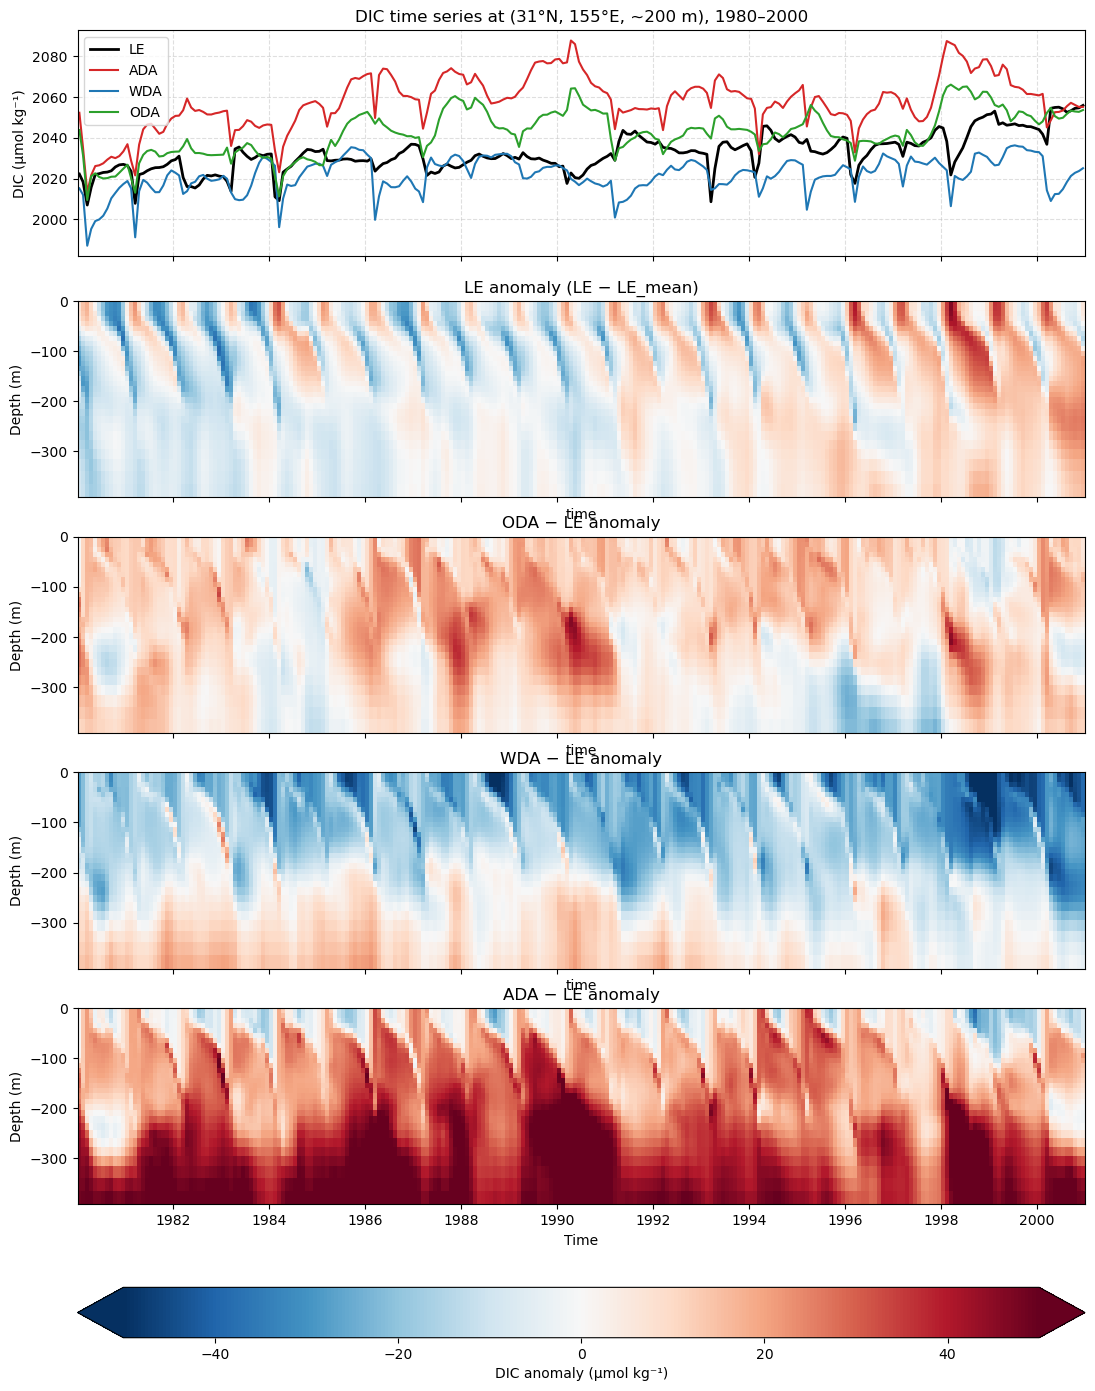

In [165]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    """Safely convert cftime.DatetimeNoLeap to numpy.datetime64 for plotting."""
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da


# ==========================================================
# 2) Helper: extract single-point DIC time series
# ==========================================================
def extract_dic_point(ds_dic, lat_pt=31, lon_pt=155, depth_pt=-200):
    """Extract DIC time series at a specific point (nearest grid)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm → m, flip sign
    da_point = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point


# ==========================================================
# 3) Helper: extract DIC time–depth section
# ==========================================================
def extract_dic_hovmoller(ds_dic, lat_pt=31, lon_pt=155, depth_range=(-5, -400)):
    """Extract DIC time–depth section (Hovmöller) at fixed (lat, lon)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da


# ==========================================================
# 4) Extract datasets
# ==========================================================
ts_LE  = extract_dic_point(cfg_var_DIC.LE_ds_rgd)
ts_ADA = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
ts_WDA = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
ts_ODA = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

hov_LE  = extract_dic_hovmoller(cfg_var_DIC.LE_ds_rgd)
hov_ADA = extract_dic_hovmoller(cfg_var_DIC.ADA_ds_rgd)
hov_WDA = extract_dic_hovmoller(cfg_var_DIC.WDA_ds_rgd)
hov_ODA = extract_dic_hovmoller(cfg_var_DIC.ODA_ds_rgd)

# Convert CFTime → datetime64
ts_LE, ts_ADA, ts_WDA, ts_ODA = map(convert_cftime_to_datetime, [ts_LE, ts_ADA, ts_WDA, ts_ODA])
hov_LE, hov_ADA, hov_WDA, hov_ODA = map(convert_cftime_to_datetime, [hov_LE, hov_ADA, hov_WDA, hov_ODA])

print(f"Grid (LE): lon={float(hov_LE.lon.values):.2f}, lat={float(hov_LE.lat.values):.2f}")

# ==========================================================
# 🔹 5) Restrict to 1980–2000 period only
# ==========================================================
start_date = np.datetime64("1980-01-01")
end_date   = np.datetime64("2000-12-31")

def slice_time(da, start, end):
    """Subset data along time axis."""
    return da.sel(time=slice(start, end))

ts_LE  = slice_time(ts_LE, start_date, end_date)
ts_ADA = slice_time(ts_ADA, start_date, end_date)
ts_WDA = slice_time(ts_WDA, start_date, end_date)
ts_ODA = slice_time(ts_ODA, start_date, end_date)

hov_LE  = slice_time(hov_LE, start_date, end_date)
hov_ADA = slice_time(hov_ADA, start_date, end_date)
hov_WDA = slice_time(hov_WDA, start_date, end_date)
hov_ODA = slice_time(hov_ODA, start_date, end_date)

# ==========================================================
# 6) Compute anomalies
# ==========================================================
hov_LE_anom  = hov_LE - hov_LE.mean(dim="time")  # LE vs full mean
hov_ADA_anom = hov_ADA - hov_LE
hov_WDA_anom = hov_WDA - hov_LE
hov_ODA_anom = hov_ODA - hov_LE

# ==========================================================
# 7) Plot (5 rows: time series + LE anomaly + others)
# ==========================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(13, 17), sharex=True)

# ---------- (1) Time series ----------
axes[0].plot(ts_LE.time,  ts_LE,  label="LE",  color="k", lw=2)
axes[0].plot(ts_ADA.time, ts_ADA, label="ADA", color="C3")
axes[0].plot(ts_WDA.time, ts_WDA, label="WDA", color="C0")
axes[0].plot(ts_ODA.time, ts_ODA, label="ODA", color="C2")
axes[0].set_title("DIC time series at (31°N, 155°E, ~200 m), 1980–2000")
axes[0].set_ylabel("DIC (µmol kg⁻¹)")
axes[0].grid(True, ls="--", alpha=0.4)
axes[0].legend()

# ---------- (2–5) Hovmöllers ----------
plot_kw_anom = dict(x="time", y="z_t", cmap="RdBu_r", vmin=-50, vmax=50, add_colorbar=False)

# (2) LE anomaly (relative to its full-period mean)
p0 = hov_LE_anom.plot(ax=axes[1], **plot_kw_anom)
axes[1].set_title("LE anomaly (LE − LE_mean)")

# (3) ODA − LE
p1 = hov_ODA_anom.plot(ax=axes[2], **plot_kw_anom)
axes[2].set_title("ODA − LE anomaly")

# (4) WDA − LE
p2 = hov_WDA_anom.plot(ax=axes[3], **plot_kw_anom)
axes[3].set_title("WDA − LE anomaly")

# (5) ADA − LE
p3 = hov_ADA_anom.plot(ax=axes[4], **plot_kw_anom)
axes[4].set_title("ADA − LE anomaly")

# ---------- Axis setup ----------
for ax in axes[1:]:
    ax.set_ylabel("Depth (m)")
    # ax.invert_yaxis()
axes[-1].set_xlabel("Time")

# ---------- Shared horizontal colorbar ----------
cbar = fig.colorbar(
    p3, ax=axes[1:], orientation="horizontal",
    fraction=0.05, pad=0.08, extend="both"
)
cbar.set_label("DIC anomaly (µmol kg⁻¹)")

# plt.tight_layout()
plt.show()


Grid (LE): lon=155.00, lat=31.00


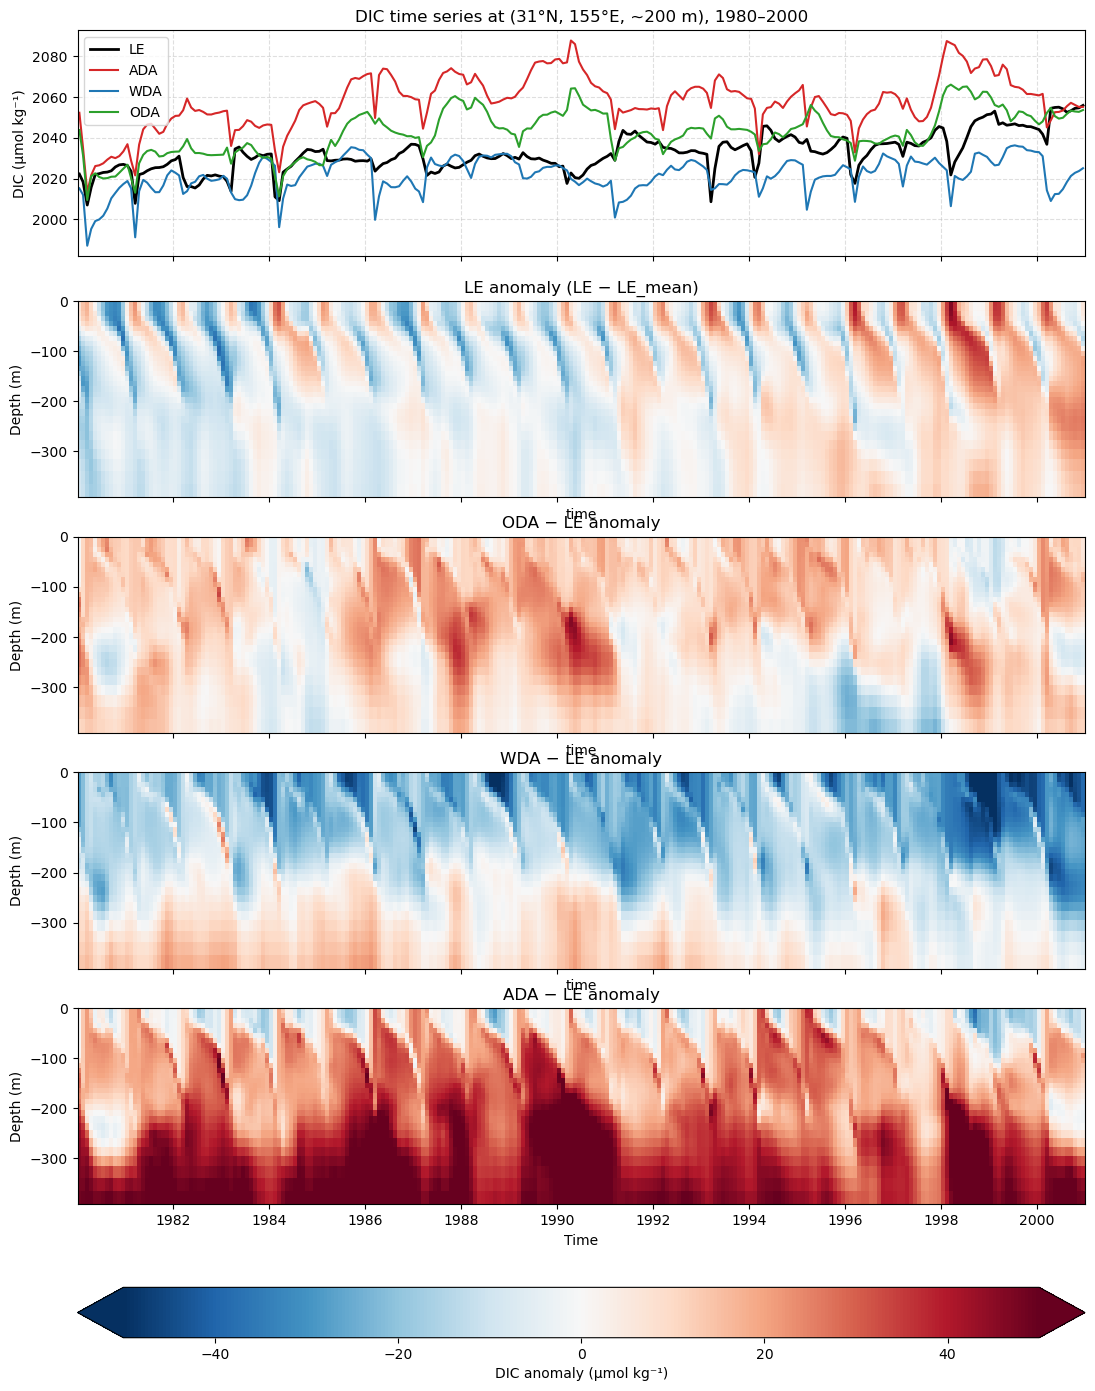

In [184]:
import numpy as np
import matplotlib.pyplot as plt



# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    """Safely convert cftime.DatetimeNoLeap to numpy.datetime64 for plotting."""
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da


# ==========================================================
# 2) Helper: extract single-point DIC time series
# ==========================================================
def extract_dic_point(ds_dic, lat_pt=31, lon_pt=155, depth_pt=-200):
    """Extract DIC time series at a specific point (nearest grid)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm → m, flip sign
    da_point = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point


# ==========================================================
# 3) Helper: extract DIC time–depth section
# ==========================================================
def extract_dic_hovmoller(ds_dic, lat_pt=31, lon_pt=155, depth_range=(-5, -400)):
    """Extract DIC time–depth section (Hovmöller) at fixed (lat, lon)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da


# ==========================================================
# 4) Extract datasets
# ==========================================================
ts_LE  = extract_dic_point(cfg_var_DIC.LE_ds_rgd)
ts_ADA = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
ts_WDA = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
ts_ODA = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

hov_LE  = extract_dic_hovmoller(cfg_var_DIC.LE_ds_rgd)
hov_ADA = extract_dic_hovmoller(cfg_var_DIC.ADA_ds_rgd)
hov_WDA = extract_dic_hovmoller(cfg_var_DIC.WDA_ds_rgd)
hov_ODA = extract_dic_hovmoller(cfg_var_DIC.ODA_ds_rgd)

# Convert CFTime → datetime64
ts_LE, ts_ADA, ts_WDA, ts_ODA = map(convert_cftime_to_datetime, [ts_LE, ts_ADA, ts_WDA, ts_ODA])
hov_LE, hov_ADA, hov_WDA, hov_ODA = map(convert_cftime_to_datetime, [hov_LE, hov_ADA, hov_WDA, hov_ODA])

print(f"Grid (LE): lon={float(hov_LE.lon.values):.2f}, lat={float(hov_LE.lat.values):.2f}")

# ==========================================================
# 🔹 5) Restrict to 1980–2000 period only
# ==========================================================
start_date = np.datetime64("1980-01-01")
end_date   = np.datetime64("2000-12-31")

def slice_time(da, start, end):
    """Subset data along time axis."""
    return da.sel(time=slice(start, end))

ts_LE  = slice_time(ts_LE, start_date, end_date)
ts_ADA = slice_time(ts_ADA, start_date, end_date)
ts_WDA = slice_time(ts_WDA, start_date, end_date)
ts_ODA = slice_time(ts_ODA, start_date, end_date)

hov_LE  = slice_time(hov_LE, start_date, end_date)
hov_ADA = slice_time(hov_ADA, start_date, end_date)
hov_WDA = slice_time(hov_WDA, start_date, end_date)
hov_ODA = slice_time(hov_ODA, start_date, end_date)

# ==========================================================
# 6) Compute anomalies
# ==========================================================
hov_LE_anom  = hov_LE - hov_LE.mean(dim="time")  # LE vs full mean
hov_ADA_anom = hov_ADA - hov_LE
hov_WDA_anom = hov_WDA - hov_LE
hov_ODA_anom = hov_ODA - hov_LE

# ==========================================================
# 7) Plot (5 rows: time series + LE anomaly + others)
# ==========================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(13, 17), sharex=True)

# ---------- (1) Time series ----------
axes[0].plot(ts_LE.time,  ts_LE,  label="LE",  color="k", lw=2)
axes[0].plot(ts_ADA.time, ts_ADA, label="ADA", color="C3")
axes[0].plot(ts_WDA.time, ts_WDA, label="WDA", color="C0")
axes[0].plot(ts_ODA.time, ts_ODA, label="ODA", color="C2")
axes[0].set_title("DIC time series at (31°N, 155°E, ~200 m), 1980–2000")
axes[0].set_ylabel("DIC (µmol kg⁻¹)")
axes[0].grid(True, ls="--", alpha=0.4)
axes[0].legend()

# ---------- (2–5) Hovmöllers ----------
plot_kw_anom = dict(x="time", y="z_t", cmap="RdBu_r", vmin=-50, vmax=50, add_colorbar=False)

# (2) LE anomaly (relative to its full-period mean)
p0 = hov_LE_anom.plot(ax=axes[1], **plot_kw_anom)
axes[1].set_title("LE anomaly (LE − LE_mean)")

# (3) ODA − LE
p1 = hov_ODA_anom.plot(ax=axes[2], **plot_kw_anom)
axes[2].set_title("ODA − LE anomaly")

# (4) WDA − LE
p2 = hov_WDA_anom.plot(ax=axes[3], **plot_kw_anom)
axes[3].set_title("WDA − LE anomaly")

# (5) ADA − LE
p3 = hov_ADA_anom.plot(ax=axes[4], **plot_kw_anom)
axes[4].set_title("ADA − LE anomaly")

# ---------- Axis setup ----------
for ax in axes[1:]:
    ax.set_ylabel("Depth (m)")
    # ax.invert_yaxis()
axes[-1].set_xlabel("Time")

# ---------- Shared horizontal colorbar ----------
cbar = fig.colorbar(
    p3, ax=axes[1:], orientation="horizontal",
    fraction=0.05, pad=0.08, extend="both"
)
cbar.set_label("DIC anomaly (µmol kg⁻¹)")

# plt.tight_layout()
plt.show()


Grid (LE): lon=155.00, lat=31.00


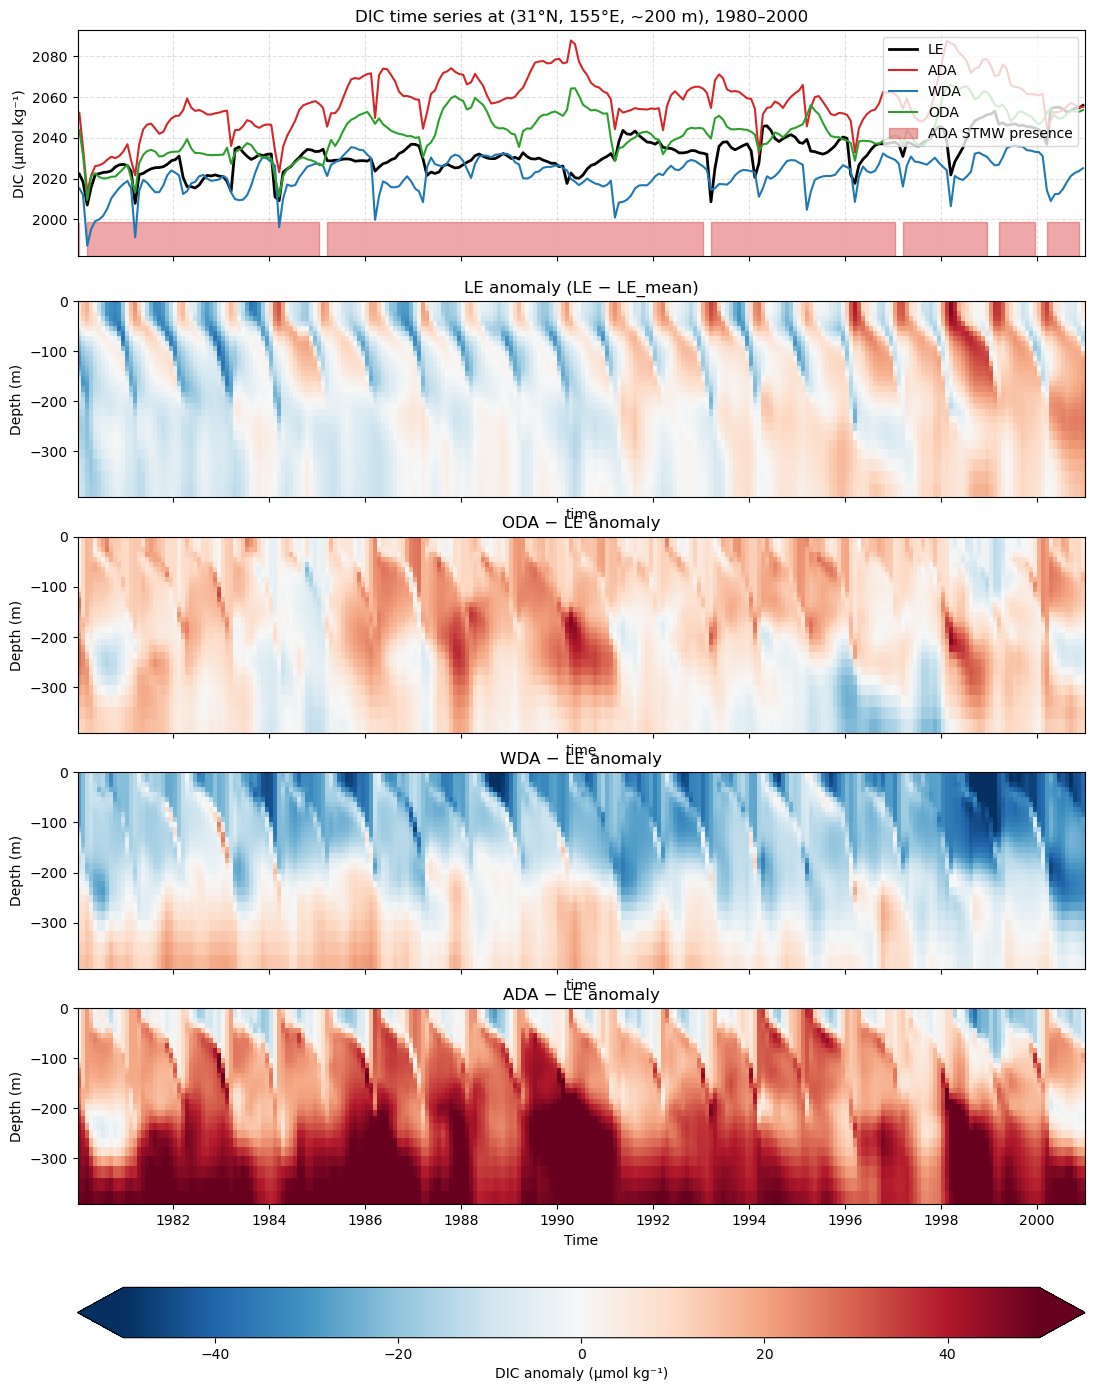

In [201]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    """Safely convert cftime.DatetimeNoLeap to numpy.datetime64 for plotting."""
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da


# ==========================================================
# 2) Helper: extract single-point DIC time series
# ==========================================================
def extract_dic_point(ds_dic, lat_pt=31, lon_pt=155, depth_pt=-200):
    """Extract DIC time series at a specific point (nearest grid)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm → m, flip sign
    da_point = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point


# ==========================================================
# 3) Helper: extract DIC time–depth section
# ==========================================================
def extract_dic_hovmoller(ds_dic, lat_pt=31, lon_pt=155, depth_range=(-5, -400)):
    """Extract DIC time–depth section (Hovmöller) at fixed (lat, lon)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da


# ==========================================================
# 4) Helper: extract STMW existence (binary 0/1)
# ==========================================================
def extract_stmw_presence(mask_ds, lat_pt=31, lon_pt=155, depth_range=(100, 300)):
    """
    Extract time series (0 or 1) indicating STMW presence at given (lat, lon).
    mask_ds: DataArray with dimensions (time, z_t, lat, lon), boolean or 0/1.
    """
    sub = (
        mask_ds
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    ts_mask = (sub.mean(dim="z_t") > 0.7).astype(int)
    return ts_mask


# ==========================================================
# 5) Extract datasets
# ==========================================================
ts_LE  = extract_dic_point(cfg_var_DIC.LE_ds_rgd)
ts_ADA = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
ts_WDA = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
ts_ODA = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

hov_LE  = extract_dic_hovmoller(cfg_var_DIC.LE_ds_rgd)
hov_ADA = extract_dic_hovmoller(cfg_var_DIC.ADA_ds_rgd)
hov_WDA = extract_dic_hovmoller(cfg_var_DIC.WDA_ds_rgd)
hov_ODA = extract_dic_hovmoller(cfg_var_DIC.ODA_ds_rgd)

mask_ADA_ts = ADA_STMWW_rgd.sel(lon=155, method='nearest').sel(lat=31,method='nearest').sel(z_t=20000, method='nearest')
mask_num = mask_ADA_ts.astype(int)


# ==========================================================
# 6) Convert CFTime → datetime64
# ==========================================================
ts_LE, ts_ADA, ts_WDA, ts_ODA = map(convert_cftime_to_datetime, [ts_LE, ts_ADA, ts_WDA, ts_ODA])
hov_LE, hov_ADA, hov_WDA, hov_ODA = map(convert_cftime_to_datetime, [hov_LE, hov_ADA, hov_WDA, hov_ODA])
mask_ADA_ts = convert_cftime_to_datetime(mask_ADA_ts)
mask_num = convert_cftime_to_datetime(mask_num)

print(f"Grid (LE): lon={float(hov_LE.lon.values):.2f}, lat={float(hov_LE.lat.values):.2f}")

# ==========================================================
# 7) Restrict to 1980–2000 period only
# ==========================================================
start_date = np.datetime64("1980-01-01")
end_date   = np.datetime64("2000-12-31")

def slice_time(da, start, end):
    return da.sel(time=slice(start, end))

ts_LE  = slice_time(ts_LE, start_date, end_date)
ts_ADA = slice_time(ts_ADA, start_date, end_date)
ts_WDA = slice_time(ts_WDA, start_date, end_date)
ts_ODA = slice_time(ts_ODA, start_date, end_date)

hov_LE  = slice_time(hov_LE, start_date, end_date)
hov_ADA = slice_time(hov_ADA, start_date, end_date)
hov_WDA = slice_time(hov_WDA, start_date, end_date)
hov_ODA = slice_time(hov_ODA, start_date, end_date)
mask_ADA_ts = slice_time(mask_ADA_ts, start_date, end_date)
mask_num = slice_time(mask_num, start_date, end_date)

# ==========================================================
# 8) Compute anomalies
# ==========================================================
hov_LE_anom  = hov_LE - hov_LE.mean(dim="time")
hov_ADA_anom = hov_ADA - hov_LE
hov_WDA_anom = hov_WDA - hov_LE
hov_ODA_anom = hov_ODA - hov_LE

# ==========================================================
# 9) Plot (5 rows: time series + LE anomaly + others)
# ==========================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(13, 17), sharex=True)

# ---------- (1) Time series ----------
axes[0].plot(ts_LE.time,  ts_LE,  label="LE",  color="k", lw=2)
axes[0].plot(ts_ADA.time, ts_ADA, label="ADA", color="C3")
axes[0].plot(ts_WDA.time, ts_WDA, label="WDA", color="C0")
axes[0].plot(ts_ODA.time, ts_ODA, label="ODA", color="C2")
axes[0].set_title("DIC time series at (31°N, 155°E, ~200 m), 1980–2000")
axes[0].set_ylabel("DIC (µmol kg⁻¹)")
axes[0].grid(True, ls="--", alpha=0.4)

# 🔸 Highlight ADA STMW presence (only)
ymin, ymax = axes[0].get_ylim()

axes[0].fill_between(
    mask_ADA_ts.time.values, ymin, ymin + (ymax - ymin) * 0.15,
    where=mask_num.values > 0,
    color="C3", alpha=0.4, label="ADA STMW presence"
)

axes[0].set_ylim(ymin, ymax)
axes[0].legend(loc="upper right")

# ---------- (2–5) Hovmöller anomalies ----------
plot_kw_anom = dict(x="time", y="z_t", cmap="RdBu_r", vmin=-50, vmax=50, add_colorbar=False)

p0 = hov_LE_anom.plot(ax=axes[1], **plot_kw_anom)
axes[1].set_title("LE anomaly (LE − LE_mean)")

p1 = hov_ODA_anom.plot(ax=axes[2], **plot_kw_anom)
axes[2].set_title("ODA − LE anomaly")

p2 = hov_WDA_anom.plot(ax=axes[3], **plot_kw_anom)
axes[3].set_title("WDA − LE anomaly")

p3 = hov_ADA_anom.plot(ax=axes[4], **plot_kw_anom)
axes[4].set_title("ADA − LE anomaly")

# ---------- Axis setup ----------
for ax in axes[1:]:
    ax.set_ylabel("Depth (m)")
axes[-1].set_xlabel("Time")

# ---------- Shared horizontal colorbar ----------
cbar = fig.colorbar(
    p3, ax=axes[1:], orientation="horizontal",
    fraction=0.05, pad=0.08, extend="both"
)
cbar.set_label("DIC anomaly (µmol kg⁻¹)")

# plt.tight_layout()
plt.show()


Grid (LE): lon=140.00, lat=31.00


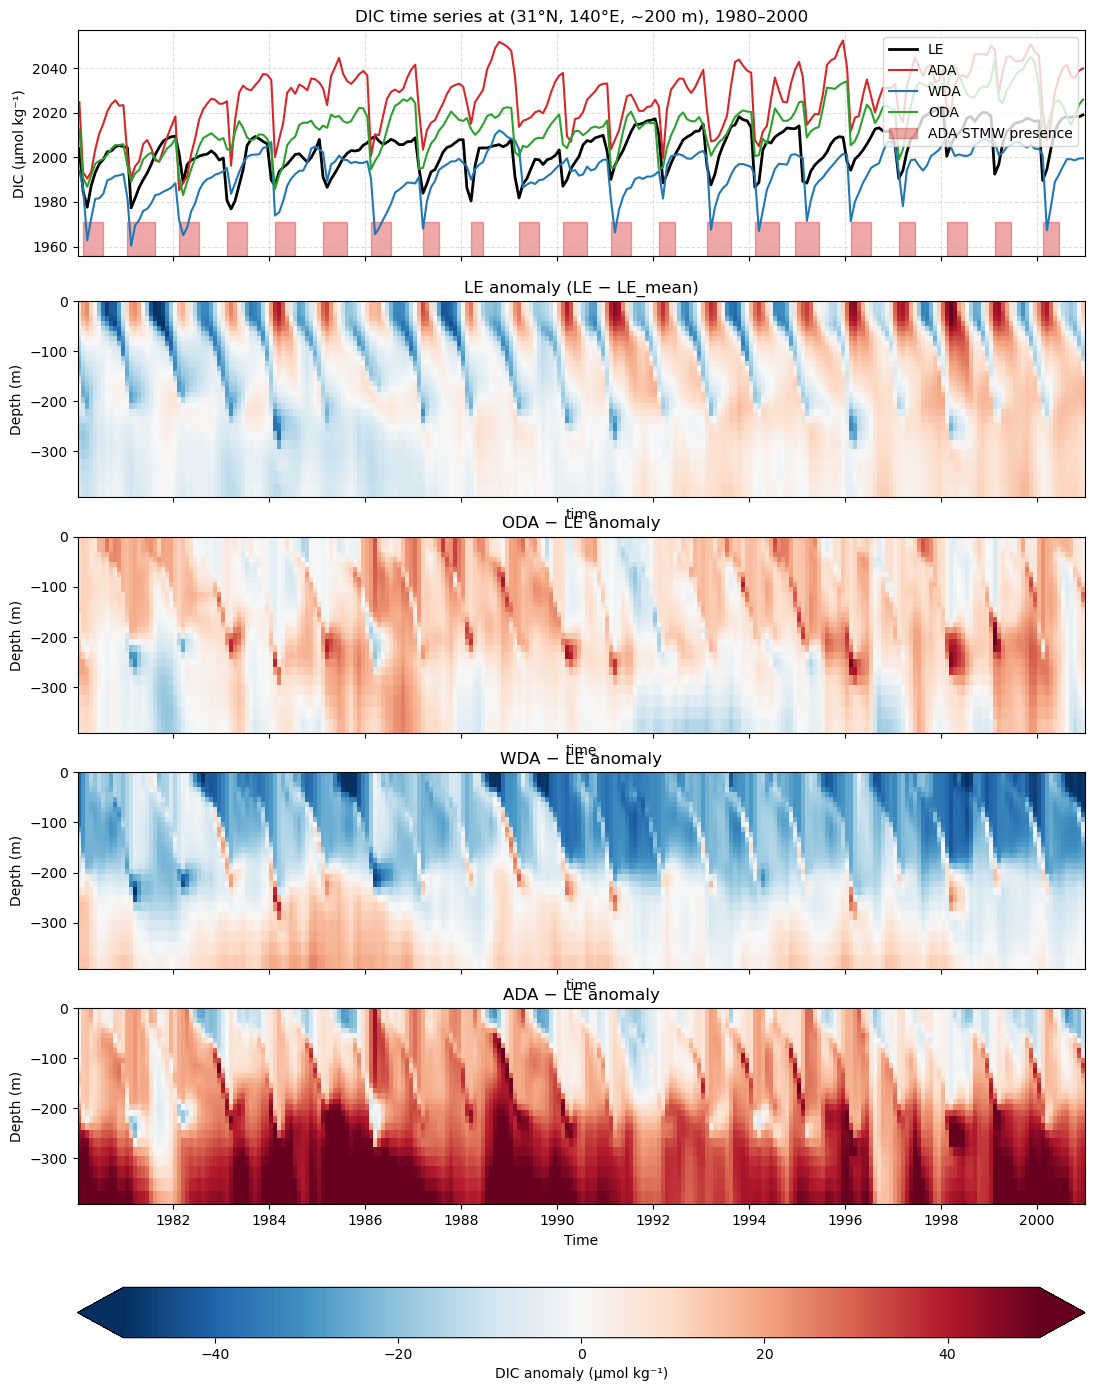

In [203]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    """Safely convert cftime.DatetimeNoLeap to numpy.datetime64 for plotting."""
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da


# ==========================================================
# 2) Helper: extract single-point DIC time series
# ==========================================================
def extract_dic_point(ds_dic, lat_pt=31, lon_pt=140, depth_pt=-200):
    """Extract DIC time series at a specific point (nearest grid)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm → m, flip sign
    da_point = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point


# ==========================================================
# 3) Helper: extract DIC time–depth section
# ==========================================================
def extract_dic_hovmoller(ds_dic, lat_pt=31, lon_pt=140, depth_range=(-5, -400)):
    """Extract DIC time–depth section (Hovmöller) at fixed (lat, lon)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da


# ==========================================================
# 4) Helper: extract STMW existence (binary 0/1)
# ==========================================================
def extract_stmw_presence(mask_ds, lat_pt=31, lon_pt=140, depth_range=(100, 300)):
    """
    Extract time series (0 or 1) indicating STMW presence at given (lat, lon).
    mask_ds: DataArray with dimensions (time, z_t, lat, lon), boolean or 0/1.
    """
    sub = (
        mask_ds
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    ts_mask = (sub.mean(dim="z_t") > 0.7).astype(int)
    return ts_mask


# ==========================================================
# 5) Extract datasets
# ==========================================================
ts_LE  = extract_dic_point(cfg_var_DIC.LE_ds_rgd)
ts_ADA = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
ts_WDA = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
ts_ODA = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

hov_LE  = extract_dic_hovmoller(cfg_var_DIC.LE_ds_rgd)
hov_ADA = extract_dic_hovmoller(cfg_var_DIC.ADA_ds_rgd)
hov_WDA = extract_dic_hovmoller(cfg_var_DIC.WDA_ds_rgd)
hov_ODA = extract_dic_hovmoller(cfg_var_DIC.ODA_ds_rgd)

mask_ADA_ts = ADA_STMWW_rgd.sel(lon=140, method='nearest').sel(lat=31,method='nearest').sel(z_t=20000, method='nearest')
mask_num = mask_ADA_ts.astype(int)


# ==========================================================
# 6) Convert CFTime → datetime64
# ==========================================================
ts_LE, ts_ADA, ts_WDA, ts_ODA = map(convert_cftime_to_datetime, [ts_LE, ts_ADA, ts_WDA, ts_ODA])
hov_LE, hov_ADA, hov_WDA, hov_ODA = map(convert_cftime_to_datetime, [hov_LE, hov_ADA, hov_WDA, hov_ODA])
mask_ADA_ts = convert_cftime_to_datetime(mask_ADA_ts)
mask_num = convert_cftime_to_datetime(mask_num)

print(f"Grid (LE): lon={float(hov_LE.lon.values):.2f}, lat={float(hov_LE.lat.values):.2f}")

# ==========================================================
# 7) Restrict to 1980–2000 period only
# ==========================================================
start_date = np.datetime64("1980-01-01")
end_date   = np.datetime64("2000-12-31")

def slice_time(da, start, end):
    return da.sel(time=slice(start, end))

ts_LE  = slice_time(ts_LE, start_date, end_date)
ts_ADA = slice_time(ts_ADA, start_date, end_date)
ts_WDA = slice_time(ts_WDA, start_date, end_date)
ts_ODA = slice_time(ts_ODA, start_date, end_date)

hov_LE  = slice_time(hov_LE, start_date, end_date)
hov_ADA = slice_time(hov_ADA, start_date, end_date)
hov_WDA = slice_time(hov_WDA, start_date, end_date)
hov_ODA = slice_time(hov_ODA, start_date, end_date)
mask_ADA_ts = slice_time(mask_ADA_ts, start_date, end_date)
mask_num = slice_time(mask_num, start_date, end_date)

# ==========================================================
# 8) Compute anomalies
# ==========================================================
hov_LE_anom  = hov_LE - hov_LE.mean(dim="time")
hov_ADA_anom = hov_ADA - hov_LE
hov_WDA_anom = hov_WDA - hov_LE
hov_ODA_anom = hov_ODA - hov_LE

# ==========================================================
# 9) Plot (5 rows: time series + LE anomaly + others)
# ==========================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(13, 17), sharex=True)

# ---------- (1) Time series ----------
axes[0].plot(ts_LE.time,  ts_LE,  label="LE",  color="k", lw=2)
axes[0].plot(ts_ADA.time, ts_ADA, label="ADA", color="C3")
axes[0].plot(ts_WDA.time, ts_WDA, label="WDA", color="C0")
axes[0].plot(ts_ODA.time, ts_ODA, label="ODA", color="C2")
axes[0].set_title("DIC time series at (31°N, 140°E, ~200 m), 1980–2000")
axes[0].set_ylabel("DIC (µmol kg⁻¹)")
axes[0].grid(True, ls="--", alpha=0.4)

# 🔸 Highlight ADA STMW presence (only)
ymin, ymax = axes[0].get_ylim()

axes[0].fill_between(
    mask_ADA_ts.time.values, ymin, ymin + (ymax - ymin) * 0.15,
    where=mask_num.values > 0,
    color="C3", alpha=0.4, label="ADA STMW presence"
)

axes[0].set_ylim(ymin, ymax)
axes[0].legend(loc="upper right")

# ---------- (2–5) Hovmöller anomalies ----------
plot_kw_anom = dict(x="time", y="z_t", cmap="RdBu_r", vmin=-50, vmax=50, add_colorbar=False)

p0 = hov_LE_anom.plot(ax=axes[1], **plot_kw_anom)
axes[1].set_title("LE anomaly (LE − LE_mean)")

p1 = hov_ODA_anom.plot(ax=axes[2], **plot_kw_anom)
axes[2].set_title("ODA − LE anomaly")

p2 = hov_WDA_anom.plot(ax=axes[3], **plot_kw_anom)
axes[3].set_title("WDA − LE anomaly")

p3 = hov_ADA_anom.plot(ax=axes[4], **plot_kw_anom)
axes[4].set_title("ADA − LE anomaly")

# ---------- Axis setup ----------
for ax in axes[1:]:
    ax.set_ylabel("Depth (m)")
axes[-1].set_xlabel("Time")

# ---------- Shared horizontal colorbar ----------
cbar = fig.colorbar(
    p3, ax=axes[1:], orientation="horizontal",
    fraction=0.05, pad=0.08, extend="both"
)
cbar.set_label("DIC anomaly (µmol kg⁻¹)")

# plt.tight_layout()
plt.show()


In [220]:
unique_years = sorted({t.year for t in cfg_var_DIC.LE_ds_rgd.time.values})
print(unique_years[:10], "...", unique_years[-10:])

sample_1990 = [t for t in cfg_var_DIC.LE_ds_rgd.time.values if t.year == 1990]
print(sample_1990)

[1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964] ... [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
[cftime.DatetimeNoLeap(1990, 1, 17, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1990, 2, 14, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1990, 3, 17, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1990, 4, 16, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1990, 5, 17, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1990, 6, 16, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1990, 7, 17, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1990, 8, 17, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1990, 9, 16, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1990, 10, 17, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1990, 11, 16, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1990, 12, 17, 0, 0, 0, 0, has_year_zero=True)]


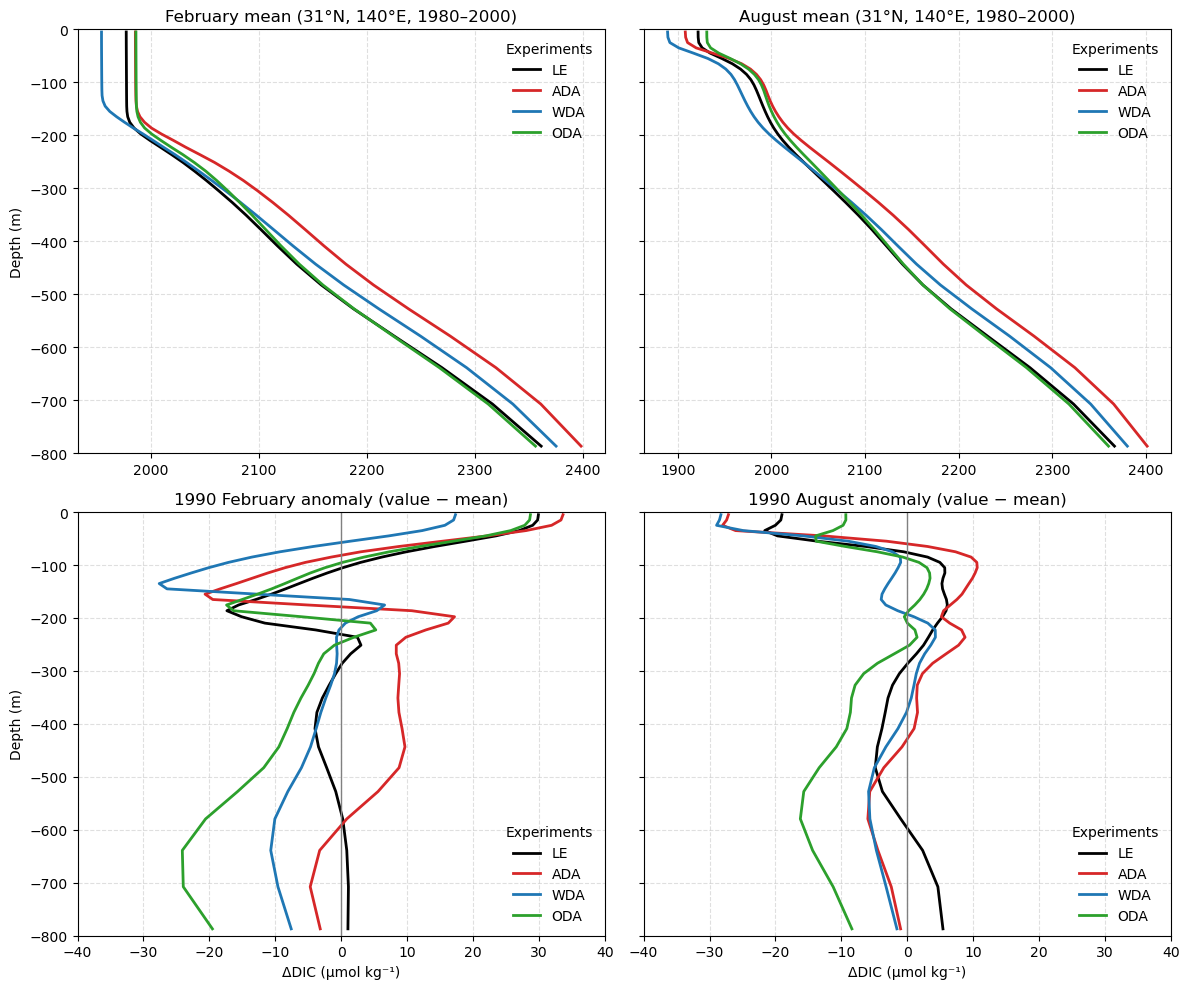

In [228]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: extract monthly-mean vertical structure
# ==========================================================
def extract_dic_vertical_monthlymean(ds_dic, lat_pt=31, lon_pt=140, depth_range=(0, -800)):
    """
    Return vertical DIC profile averaged for each calendar month,
    with z_t converted from cm→m and sign flipped (negative downward).
    """
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm→m, flip sign
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_dic_vertical_monthlymean(cfg_var_DIC.LE_ds_rgd)
vert_ADA = extract_dic_vertical_monthlymean(cfg_var_DIC.ADA_ds_rgd)
vert_WDA = extract_dic_vertical_monthlymean(cfg_var_DIC.WDA_ds_rgd)
vert_ODA = extract_dic_vertical_monthlymean(cfg_var_DIC.ODA_ds_rgd)

# Select Feb (2) & Aug (8)
Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Helper: extract 1990 Feb/Aug anomalies
# ==========================================================
def extract_dic_vertical_anomaly(
    ds_dic, lat_pt=31, lon_pt=140, target_year=1990, target_month=2, depth_range=(0, -800)
):
    """
    Extract vertical DIC anomaly (given year-month minus full mean).
    Works safely even if only one timestamp exists per month.
    """
    # Convert z_t to meters (positive down)
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    
    # Select spatial and depth region
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )

    # Compute long-term mean
    mean_profile = da.mean(dim="time")

    # Build boolean mask for cftime.DatetimeNoLeap
    years = np.array([t.year for t in da.time.values])
    months = np.array([t.month for t in da.time.values])
    mask = (years == target_year) & (months == target_month)

    if not mask.any():
        raise ValueError(f"No data found for {target_year}-{target_month:02d}")

    # Select time(s) and average safely
    target = da.isel(time=np.where(mask)[0])
    target_mean = target.mean(dim="time") if target.ndim > 1 else target
    return target_mean - mean_profile


anom_Feb = {
    "LE":  extract_dic_vertical_anomaly(cfg_var_DIC.LE_ds_rgd, target_month=2),
    "ADA": extract_dic_vertical_anomaly(cfg_var_DIC.ADA_ds_rgd, target_month=2),
    "WDA": extract_dic_vertical_anomaly(cfg_var_DIC.WDA_ds_rgd, target_month=2),
    "ODA": extract_dic_vertical_anomaly(cfg_var_DIC.ODA_ds_rgd, target_month=2),
}
anom_Aug = {
    "LE":  extract_dic_vertical_anomaly(cfg_var_DIC.LE_ds_rgd, target_month=8),
    "ADA": extract_dic_vertical_anomaly(cfg_var_DIC.ADA_ds_rgd, target_month=8),
    "WDA": extract_dic_vertical_anomaly(cfg_var_DIC.WDA_ds_rgd, target_month=8),
    "ODA": extract_dic_vertical_anomaly(cfg_var_DIC.ODA_ds_rgd, target_month=8),
}

# ==========================================================
# 4) Plot: 2×2 panels (mean vs 1990 anomaly)
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True)

# ---------- (1,1) February mean ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
axes[0,0].set_title("February mean (31°N, 140°E, 1980–2000)")
axes[0,0].set_ylabel("Depth (m)")
axes[0,0].set_ylim(-800, 0)
axes[0,0].grid(True, ls="--", alpha=0.4)

# ---------- (1,2) August mean ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[0,1].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
axes[0,1].set_title("August mean (31°N, 140°E, 1980–2000)")
axes[0,1].set_ylim(-800, 0)
axes[0,1].grid(True, ls="--", alpha=0.4)

# ---------- (2,1) February 1990 anomaly ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[1,0].plot(anom_Feb[label], anom_Feb[label]["z_t"], color=color, lw=2, label=label)
axes[1,0].axvline(0, color="gray", lw=1)
axes[1,0].set_title("1990 February anomaly (value − mean)")
axes[1,0].set_ylabel("Depth (m)")
axes[1,0].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[1,0].set_ylim(-800, 0)
axes[1,0].set_xlim(-40, 40)
axes[1,0].grid(True, ls="--", alpha=0.4)

# ---------- (2,2) August 1990 anomaly ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[1,1].plot(anom_Aug[label], anom_Aug[label]["z_t"], color=color, lw=2, label=label)
axes[1,1].axvline(0, color="gray", lw=1)
axes[1,1].set_title("1990 August anomaly (value − mean)")
axes[1,1].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[1,1].set_ylim(-800, 0)
axes[1,1].set_xlim(-40, 40)
axes[1,1].grid(True, ls="--", alpha=0.4)

# ---------- Common legend ----------
axes[0,0].legend(loc="upper right", frameon=False, title="Experiments")
axes[0,1].legend(loc="upper right", frameon=False, title="Experiments")
axes[1,1].legend(loc="lower right", frameon=False, title="Experiments")
axes[1,0].legend(loc="lower right", frameon=False, title="Experiments")



plt.tight_layout()
plt.show()


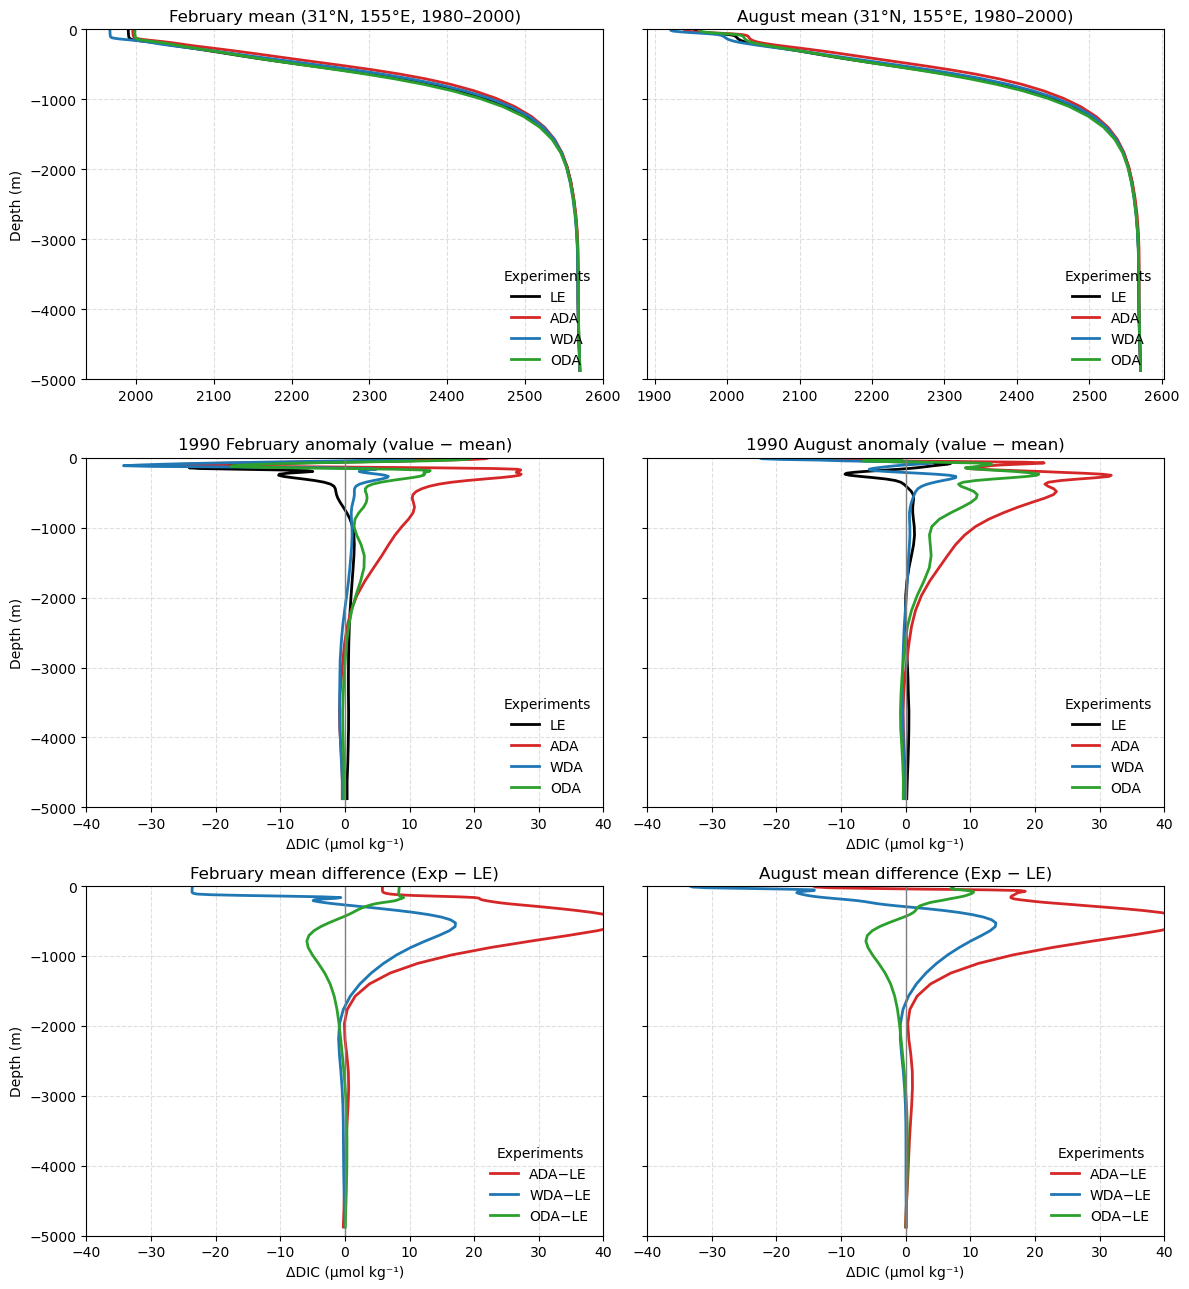

In [234]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: extract monthly-mean vertical structure
# ==========================================================
def extract_dic_vertical_monthlymean(ds_dic, lat_pt=31, lon_pt=155, depth_range=(0, -5000)):
    """
    Return vertical DIC profile averaged for each calendar month,
    with z_t converted from cm→m and sign flipped (negative downward).
    """
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm→m, flip sign
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_dic_vertical_monthlymean(cfg_var_DIC.LE_ds_rgd)
vert_ADA = extract_dic_vertical_monthlymean(cfg_var_DIC.ADA_ds_rgd)
vert_WDA = extract_dic_vertical_monthlymean(cfg_var_DIC.WDA_ds_rgd)
vert_ODA = extract_dic_vertical_monthlymean(cfg_var_DIC.ODA_ds_rgd)

# Select Feb (2) & Aug (8)
Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Helper: extract 1990 Feb/Aug anomalies
# ==========================================================
def extract_dic_vertical_anomaly(
    ds_dic, lat_pt=31, lon_pt=155, target_year=1990, target_month=2, depth_range=(0, -5000)
):
    """
    Extract vertical DIC anomaly (given year-month minus full mean).
    Works safely even if only one timestamp exists per month.
    """
    # Convert z_t to meters (positive down)
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    
    # Select spatial and depth region
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )

    # Compute long-term mean
    mean_profile = da.mean(dim="time")

    # Build boolean mask for cftime.DatetimeNoLeap
    years = np.array([t.year for t in da.time.values])
    months = np.array([t.month for t in da.time.values])
    mask = (years == target_year) & (months == target_month)

    if not mask.any():
        raise ValueError(f"No data found for {target_year}-{target_month:02d}")

    # Select time(s) and average safely
    target = da.isel(time=np.where(mask)[0])
    target_mean = target.mean(dim="time") if target.ndim > 1 else target
    return target_mean - mean_profile


anom_Feb = {
    "LE":  extract_dic_vertical_anomaly(cfg_var_DIC.LE_ds_rgd, target_month=2),
    "ADA": extract_dic_vertical_anomaly(cfg_var_DIC.ADA_ds_rgd, target_month=2),
    "WDA": extract_dic_vertical_anomaly(cfg_var_DIC.WDA_ds_rgd, target_month=2),
    "ODA": extract_dic_vertical_anomaly(cfg_var_DIC.ODA_ds_rgd, target_month=2),
}
anom_Aug = {
    "LE":  extract_dic_vertical_anomaly(cfg_var_DIC.LE_ds_rgd, target_month=8),
    "ADA": extract_dic_vertical_anomaly(cfg_var_DIC.ADA_ds_rgd, target_month=8),
    "WDA": extract_dic_vertical_anomaly(cfg_var_DIC.WDA_ds_rgd, target_month=8),
    "ODA": extract_dic_vertical_anomaly(cfg_var_DIC.ODA_ds_rgd, target_month=8),
}

# ==========================================================
# 4) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 5) Plot: 3×2 panels (mean / anomaly / mean-diff)
# ==========================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 13), sharey=True)

# ---------- (1,1) February mean ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
axes[0,0].set_title("February mean (31°N, 155°E, 1980–2000)")
axes[0,0].set_ylabel("Depth (m)")
axes[0,0].set_ylim(-5000, 0)
axes[0,0].grid(True, ls="--", alpha=0.4)

# ---------- (1,2) August mean ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[0,1].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
axes[0,1].set_title("August mean (31°N, 155°E, 1980–2000)")
axes[0,1].set_ylim(-5000, 0)
axes[0,1].grid(True, ls="--", alpha=0.4)

# ---------- (2,1) February 1990 anomaly ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[1,0].plot(anom_Feb[label], anom_Feb[label]["z_t"], color=color, lw=2, label=label)
axes[1,0].axvline(0, color="gray", lw=1)
axes[1,0].set_title("1990 February anomaly (value − mean)")
axes[1,0].set_ylabel("Depth (m)")
axes[1,0].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[1,0].set_ylim(-5000, 0)
axes[1,0].set_xlim(-40, 40)
axes[1,0].grid(True, ls="--", alpha=0.4)

# ---------- (2,2) August 1990 anomaly ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[1,1].plot(anom_Aug[label], anom_Aug[label]["z_t"], color=color, lw=2, label=label)
axes[1,1].axvline(0, color="gray", lw=1)
axes[1,1].set_title("1990 August anomaly (value − mean)")
axes[1,1].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[1,1].set_ylim(-5000, 0)
axes[1,1].set_xlim(-40, 40)
axes[1,1].grid(True, ls="--", alpha=0.4)

# ---------- (3,1) February mean differences (Exp − LE) ----------
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], ["C3", "C0", "C2"]):
    axes[2,0].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2, label=label)
axes[2,0].axvline(0, color="gray", lw=1)
axes[2,0].set_title("February mean difference (Exp − LE)")
axes[2,0].set_ylabel("Depth (m)")
axes[2,0].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[2,0].set_ylim(-5000, 0)
axes[2,0].set_xlim(-40, 40)
axes[2,0].grid(True, ls="--", alpha=0.4)

# ---------- (3,2) August mean differences (Exp − LE) ----------
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], ["C3", "C0", "C2"]):
    axes[2,1].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2, label=label)
axes[2,1].axvline(0, color="gray", lw=1)
axes[2,1].set_title("August mean difference (Exp − LE)")
axes[2,1].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[2,1].set_ylim(-5000, 0)
axes[2,1].set_xlim(-40, 40)
axes[2,1].grid(True, ls="--", alpha=0.4)

# ---------- Common legends ----------
for i in range(3):
    for j in range(2):
        axes[i, j].legend(loc="lower right", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


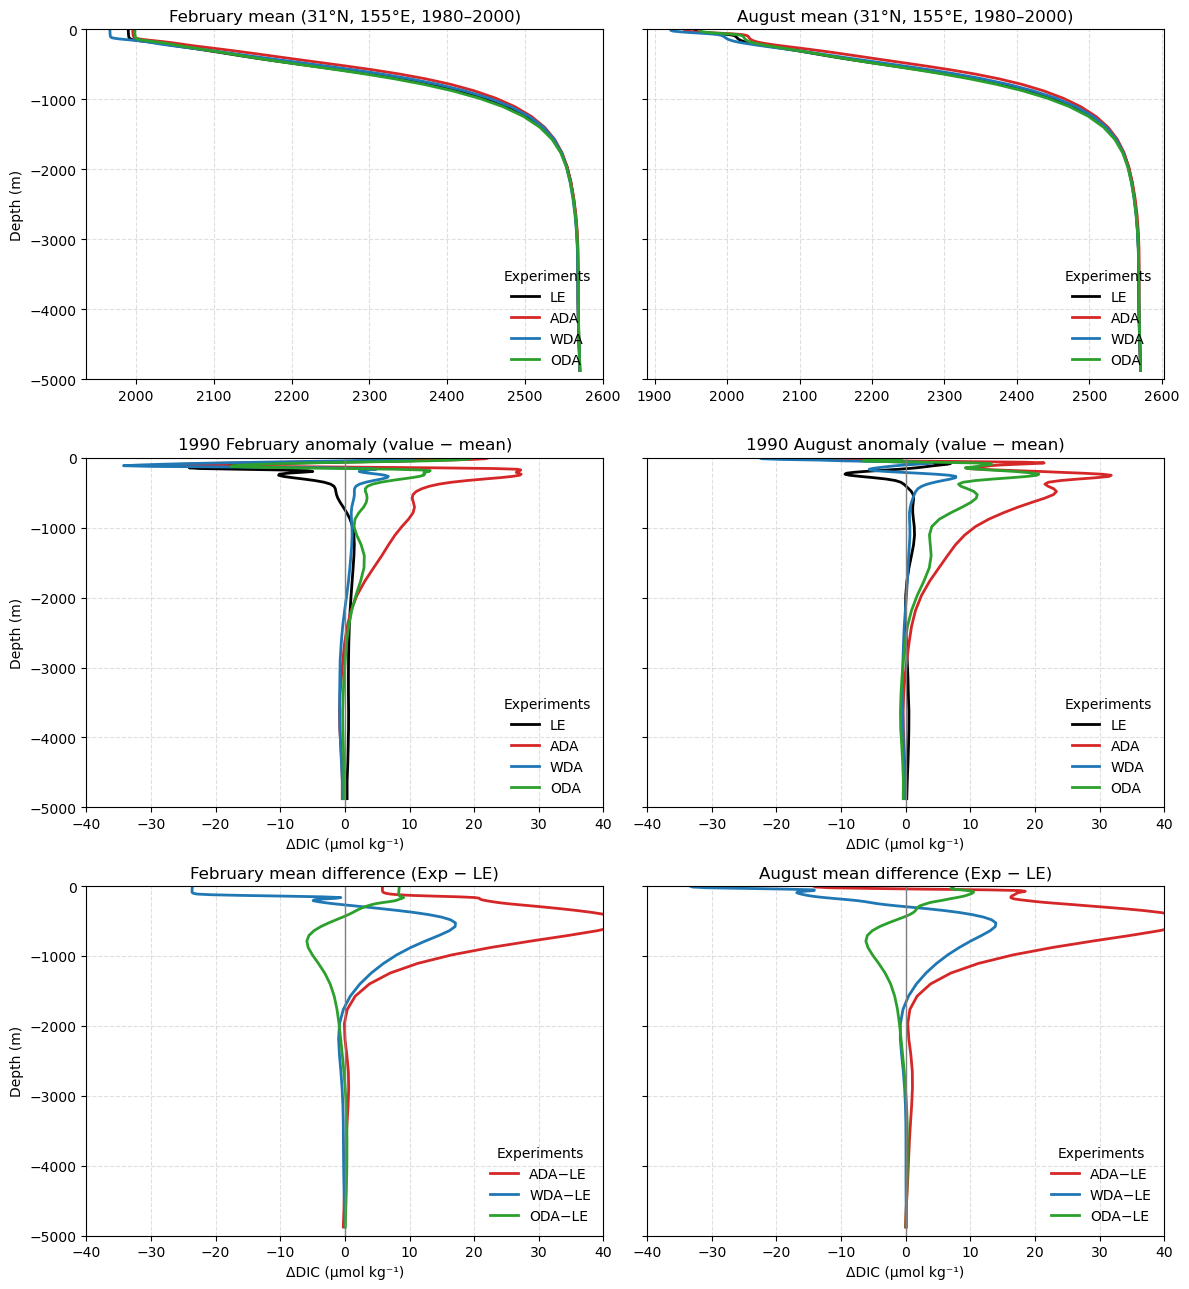

In [257]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: extract monthly-mean vertical structure
# ==========================================================
def extract_dic_vertical_monthlymean(ds_dic, lat_pt=31, lon_pt=155, depth_range=(0, -5000)):
    """
    Return vertical DIC profile averaged for each calendar month,
    with z_t converted from cm→m and sign flipped (negative downward).
    """
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm→m, flip sign
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_dic_vertical_monthlymean(cfg_var_DIC.LE_ds_rgd)
vert_ADA = extract_dic_vertical_monthlymean(cfg_var_DIC.ADA_ds_rgd)
vert_WDA = extract_dic_vertical_monthlymean(cfg_var_DIC.WDA_ds_rgd)
vert_ODA = extract_dic_vertical_monthlymean(cfg_var_DIC.ODA_ds_rgd)

# Select Feb (2) & Aug (8)
Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Helper: extract 1990 Feb/Aug anomalies
# ==========================================================
def extract_dic_vertical_anomaly(
    ds_dic, lat_pt=31, lon_pt=155, target_year=1990, target_month=2, depth_range=(0, -5000)
):
    """
    Extract vertical DIC anomaly (given year-month minus full mean).
    Works safely even if only one timestamp exists per month.
    """
    # Convert z_t to meters (positive down)
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    
    # Select spatial and depth region
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )

    # Compute long-term mean
    mean_profile = da.mean(dim="time")

    # Build boolean mask for cftime.DatetimeNoLeap
    years = np.array([t.year for t in da.time.values])
    months = np.array([t.month for t in da.time.values])
    mask = (years == target_year) & (months == target_month)

    if not mask.any():
        raise ValueError(f"No data found for {target_year}-{target_month:02d}")

    # Select time(s) and average safely
    target = da.isel(time=np.where(mask)[0])
    target_mean = target.mean(dim="time") if target.ndim > 1 else target
    return target_mean - mean_profile


anom_Feb = {
    "LE":  extract_dic_vertical_anomaly(cfg_var_DIC.LE_ds_rgd, target_month=2),
    "ADA": extract_dic_vertical_anomaly(cfg_var_DIC.ADA_ds_rgd, target_month=2),
    "WDA": extract_dic_vertical_anomaly(cfg_var_DIC.WDA_ds_rgd, target_month=2),
    "ODA": extract_dic_vertical_anomaly(cfg_var_DIC.ODA_ds_rgd, target_month=2),
}
anom_Aug = {
    "LE":  extract_dic_vertical_anomaly(cfg_var_DIC.LE_ds_rgd, target_month=8),
    "ADA": extract_dic_vertical_anomaly(cfg_var_DIC.ADA_ds_rgd, target_month=8),
    "WDA": extract_dic_vertical_anomaly(cfg_var_DIC.WDA_ds_rgd, target_month=8),
    "ODA": extract_dic_vertical_anomaly(cfg_var_DIC.ODA_ds_rgd, target_month=8),
}

# ==========================================================
# 4) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 5) Plot: 3×2 panels (mean / anomaly / mean-diff)
# ==========================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 13), sharey=True)

# ---------- (1,1) February mean ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
axes[0,0].set_title("February mean (31°N, 155°E, 1980–2000)")
axes[0,0].set_ylabel("Depth (m)")
axes[0,0].set_ylim(-5000, 0)
axes[0,0].grid(True, ls="--", alpha=0.4)

# ---------- (1,2) August mean ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[0,1].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
axes[0,1].set_title("August mean (31°N, 155°E, 1980–2000)")
axes[0,1].set_ylim(-5000, 0)
axes[0,1].grid(True, ls="--", alpha=0.4)

# ---------- (2,1) February 1990 anomaly ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[1,0].plot(anom_Feb[label], anom_Feb[label]["z_t"], color=color, lw=2, label=label)
axes[1,0].axvline(0, color="gray", lw=1)
axes[1,0].set_title("1990 February anomaly (value − mean)")
axes[1,0].set_ylabel("Depth (m)")
axes[1,0].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[1,0].set_ylim(-5000, 0)
axes[1,0].set_xlim(-40, 40)
axes[1,0].grid(True, ls="--", alpha=0.4)

# ---------- (2,2) August 1990 anomaly ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[1,1].plot(anom_Aug[label], anom_Aug[label]["z_t"], color=color, lw=2, label=label)
axes[1,1].axvline(0, color="gray", lw=1)
axes[1,1].set_title("1990 August anomaly (value − mean)")
axes[1,1].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[1,1].set_ylim(-5000, 0)
axes[1,1].set_xlim(-40, 40)
axes[1,1].grid(True, ls="--", alpha=0.4)

# ---------- (3,1) February mean differences (Exp − LE) ----------
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], ["C3", "C0", "C2"]):
    axes[2,0].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2, label=label)
axes[2,0].axvline(0, color="gray", lw=1)
axes[2,0].set_title("February mean difference (Exp − LE)")
axes[2,0].set_ylabel("Depth (m)")
axes[2,0].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[2,0].set_ylim(-5000, 0)
axes[2,0].set_xlim(-40, 40)
axes[2,0].grid(True, ls="--", alpha=0.4)

# ---------- (3,2) August mean differences (Exp − LE) ----------
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], ["C3", "C0", "C2"]):
    axes[2,1].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2, label=label)
axes[2,1].axvline(0, color="gray", lw=1)
axes[2,1].set_title("August mean difference (Exp − LE)")
axes[2,1].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[2,1].set_ylim(-5000, 0)
axes[2,1].set_xlim(-40, 40)
axes[2,1].grid(True, ls="--", alpha=0.4)

# ---------- Common legends ----------
for i in range(3):
    for j in range(2):
        axes[i, j].legend(loc="lower right", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


In [126]:
# Read ADA dataset

# Quicker test for 2 ensembADAs only

start_time = time.time()

#TEMP
cfg_var_TEMP.ADA_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.ADA_ds = xr.open_mfdataset(cfg_var_TEMP.ADA_file_list[0][5:6], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.ADA_ensembles][5:6], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TEMP.ADA_ds = cfg_var_TEMP.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_TEMP.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.ADA_ds.time))
cfg_var_TEMP.ADA_ds = cfg_var_TEMP.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))


# Read WDA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#TEMP
cfg_var_TEMP.WDA_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.WDA_ds = xr.open_mfdataset(cfg_var_TEMP.WDA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.WDA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TEMP.WDA_ds = cfg_var_TEMP.WDA_ds.rename({"concat_dim": "ens_WDA"})
new_time = cfg_var_TEMP.WDA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.WDA_ds.time))
cfg_var_TEMP.WDA_ds = cfg_var_TEMP.WDA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading WDA: ' + str(elapsed_time))


# Read ODA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#TEMP
cfg_var_TEMP.ODA_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.ODA_ds = xr.open_mfdataset(cfg_var_TEMP.ODA_file_list[0][15:16], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.ODA_ensembles][15:16], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP.ODA_ds = cfg_var_TEMP.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_TEMP.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.ODA_ds.time))
cfg_var_TEMP.ODA_ds = cfg_var_TEMP.ODA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))



#LE TEMP
start_time = time.time()
cfg_var_TEMP.LE_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.LE_ds = xr.open_mfdataset(cfg_var_TEMP.LE_file_list[0][11:12], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.LE_ensembles][11:12], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d_LE(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TEMP.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.LE_ds.time))
cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.assign_coords(time=new_time)
cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.rename({"depth": "z_t"})
cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.assign_coords(z_t = cfg_var_TEMP.ODA_ds.z_t)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

# cfg_var_TEMP.ODA_path_load(cfg_var_TEMP.var)
# cfg_var_TEMP.ODA_file_list[0]

#regrids
import xcesm

# cfg_var_TEMP.ODA_ds_rgd = cfg_var_TEMP.ODA_ds['TEMP'].isel(ens_ODA=5).utils.regrid()
# cfg_var_TEMP.ADA_ds_rgd = cfg_var_TEMP.ADA_ds['TEMP'].isel(ens_ADA=5).utils.regrid()
# cfg_var_TEMP.WDA_ds_rgd = cfg_var_TEMP.WDA_ds['TEMP'].isel(ens_WDA=0).utils.regrid()

lat_range = slice(10, 60)
lon_range = slice(110, 190)

start_time = time.time()

cfg_var_TEMP.ODA_ds_rgd = (
    cfg_var_TEMP.ODA_ds['TEMP']
    .isel(ens_ODA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)
end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding ODA: ' + str(elapsed_time))

cfg_var_TEMP.ADA_ds_rgd = (
    cfg_var_TEMP.ADA_ds['TEMP']
    .isel(ens_ADA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding ADA: ' + str(elapsed_time))

cfg_var_TEMP.WDA_ds_rgd = (
    cfg_var_TEMP.WDA_ds['TEMP']
    .isel(ens_WDA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding WDA: ' + str(elapsed_time))

cfg_var_TEMP.LE_ds_rgd = (
    cfg_var_TEMP.LE_ds['TEMP']
    .isel(ens_LE=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding LE: ' + str(elapsed_time))

cfg_var_TEMP.WDA_ds_rgd = cfg_var_TEMP.WDA_ds_rgd.sortby("time")
cfg_var_TEMP.ADA_ds_rgd = cfg_var_TEMP.ADA_ds_rgd.sortby("time")
cfg_var_TEMP.ODA_ds_rgd = cfg_var_TEMP.ODA_ds_rgd.sortby("time")
cfg_var_TEMP.LE_ds_rgd = cfg_var_TEMP.LE_ds_rgd.sortby("time")

elasped time for reading ADA: 1.904963493347168
elasped time for reading WDA: 1.72776198387146
elasped time for reading ODA: 3.108085870742798
elasped time for reading LE: 1.6314358711242676
elasped time for regriding ODA: 84.0755717754364
elasped time for regriding ADA: 128.90434384346008
elasped time for regriding WDA: 207.48961973190308
elasped time for regriding LE: 279.9307949542999


In [295]:
cfg_var_WVEL.ADA_file_list[0][5:6]

[['/mnt/lustre/proj/kimyy/tr_sysong/fld/ATM_TEST/EXP_ALL/archive/b.e21.BHISTsmbb.f09_g17.assm.projdv7.3_ba-20p1/ocn/NWP_b.e21.BHISTsmbb.f09_g17.assm.projdv7.3_ba-20p1.pop.h.WVEL.195501-195912.nc',
  '/mnt/lustre/proj/kimyy/tr_sysong/fld/ATM_TEST/EXP_ALL/archive/b.e21.BHISTsmbb.f09_g17.assm.projdv7.3_ba-20p1/ocn/NWP_b.e21.BHISTsmbb.f09_g17.assm.projdv7.3_ba-20p1.pop.h.WVEL.196001-196412.nc',
  '/mnt/lustre/proj/kimyy/tr_sysong/fld/ATM_TEST/EXP_ALL/archive/b.e21.BHISTsmbb.f09_g17.assm.projdv7.3_ba-20p1/ocn/NWP_b.e21.BHISTsmbb.f09_g17.assm.projdv7.3_ba-20p1.pop.h.WVEL.196501-196912.nc',
  '/mnt/lustre/proj/kimyy/tr_sysong/fld/ATM_TEST/EXP_ALL/archive/b.e21.BHISTsmbb.f09_g17.assm.projdv7.3_ba-20p1/ocn/NWP_b.e21.BHISTsmbb.f09_g17.assm.projdv7.3_ba-20p1.pop.h.WVEL.197001-197412.nc',
  '/mnt/lustre/proj/kimyy/tr_sysong/fld/ATM_TEST/EXP_ALL/archive/b.e21.BHISTsmbb.f09_g17.assm.projdv7.3_ba-20p1/ocn/NWP_b.e21.BHISTsmbb.f09_g17.assm.projdv7.3_ba-20p1.pop.h.WVEL.197501-197912.nc',
  '/mnt/lustre/

In [294]:
# Read ADA dataset

# Quicker test for 2 ensembADAs only

start_time = time.time()

# WVEL
cfg_var_WVEL=CESM2_NWP_config()
cfg_var_WVEL.year_s=1955
cfg_var_WVEL.year_e=2020
cfg_var_WVEL.setvar('WVEL')

#WVEL
cfg_var_WVEL.ADA_path_load(cfg_var_WVEL.var)
cfg_var_WVEL.ADA_ds = xr.open_mfdataset(cfg_var_WVEL.ADA_file_list[0][5:6], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_WVEL.ADA_ensembles][5:6], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_WVEL.ADA_ds = cfg_var_WVEL.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_WVEL.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_WVEL.ADA_ds.time))
cfg_var_WVEL.ADA_ds = cfg_var_WVEL.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))


# Read WDA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#WVEL
cfg_var_WVEL.WDA_path_load(cfg_var_WVEL.var)
cfg_var_WVEL.WDA_ds = xr.open_mfdataset(cfg_var_WVEL.WDA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_WVEL.WDA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_WVEL.WDA_ds = cfg_var_WVEL.WDA_ds.rename({"concat_dim": "ens_WDA"})
new_time = cfg_var_WVEL.WDA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_WVEL.WDA_ds.time))
cfg_var_WVEL.WDA_ds = cfg_var_WVEL.WDA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading WDA: ' + str(elapsed_time))


# Read ODA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#WVEL
cfg_var_WVEL.ODA_path_load(cfg_var_WVEL.var)
cfg_var_WVEL.ODA_ds = xr.open_mfdataset(cfg_var_WVEL.ODA_file_list[0][15:16], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_WVEL.ODA_ensembles][15:16], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_WVEL.ODA_ds = cfg_var_WVEL.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_WVEL.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_WVEL.ODA_ds.time))
cfg_var_WVEL.ODA_ds = cfg_var_WVEL.ODA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))



#LE WVEL
start_time = time.time()
cfg_var_WVEL.LE_path_load(cfg_var_WVEL.var)
cfg_var_WVEL.LE_ds = xr.open_mfdataset(cfg_var_WVEL.LE_file_list[0][11:12], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_WVEL.LE_ensembles][11:12], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d_LE(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_WVEL.LE_ds = cfg_var_WVEL.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_WVEL.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_WVEL.LE_ds.time))
cfg_var_WVEL.LE_ds = cfg_var_WVEL.LE_ds.assign_coords(time=new_time)
cfg_var_WVEL.LE_ds = cfg_var_WVEL.LE_ds.rename({"depth": "z_t"})
cfg_var_WVEL.LE_ds = cfg_var_WVEL.LE_ds.assign_coords(z_t = cfg_var_WVEL.ODA_ds.z_t)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

# cfg_var_WVEL.ODA_path_load(cfg_var_WVEL.var)
# cfg_var_WVEL.ODA_file_list[0]

#regrids
import xcesm

# cfg_var_WVEL.ODA_ds_rgd = cfg_var_WVEL.ODA_ds['WVEL'].isel(ens_ODA=5).utils.regrid()
# cfg_var_WVEL.ADA_ds_rgd = cfg_var_WVEL.ADA_ds['WVEL'].isel(ens_ADA=5).utils.regrid()
# cfg_var_WVEL.WDA_ds_rgd = cfg_var_WVEL.WDA_ds['WVEL'].isel(ens_WDA=0).utils.regrid()

lat_range = slice(10, 60)
lon_range = slice(110, 190)

start_time = time.time()

cfg_var_WVEL.ODA_ds_rgd = (
    cfg_var_WVEL.ODA_ds['WVEL']
    .isel(ens_ODA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)
end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding ODA: ' + str(elapsed_time))

cfg_var_WVEL.ADA_ds_rgd = (
    cfg_var_WVEL.ADA_ds['WVEL']
    .isel(ens_ADA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding ADA: ' + str(elapsed_time))

cfg_var_WVEL.WDA_ds_rgd = (
    cfg_var_WVEL.WDA_ds['WVEL']
    .isel(ens_WDA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding WDA: ' + str(elapsed_time))

cfg_var_WVEL.LE_ds_rgd = (
    cfg_var_WVEL.LE_ds['WVEL']
    .isel(ens_LE=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding LE: ' + str(elapsed_time))

cfg_var_WVEL.WDA_ds_rgd = cfg_var_WVEL.WDA_ds_rgd.sortby("time")
cfg_var_WVEL.ADA_ds_rgd = cfg_var_WVEL.ADA_ds_rgd.sortby("time")
cfg_var_WVEL.ODA_ds_rgd = cfg_var_WVEL.ODA_ds_rgd.sortby("time")
cfg_var_WVEL.LE_ds_rgd = cfg_var_WVEL.LE_ds_rgd.sortby("time")

TypeError: '>' not supported between instances of 'datetime.date' and 'cftime._cftime.DatetimeNoLeap'

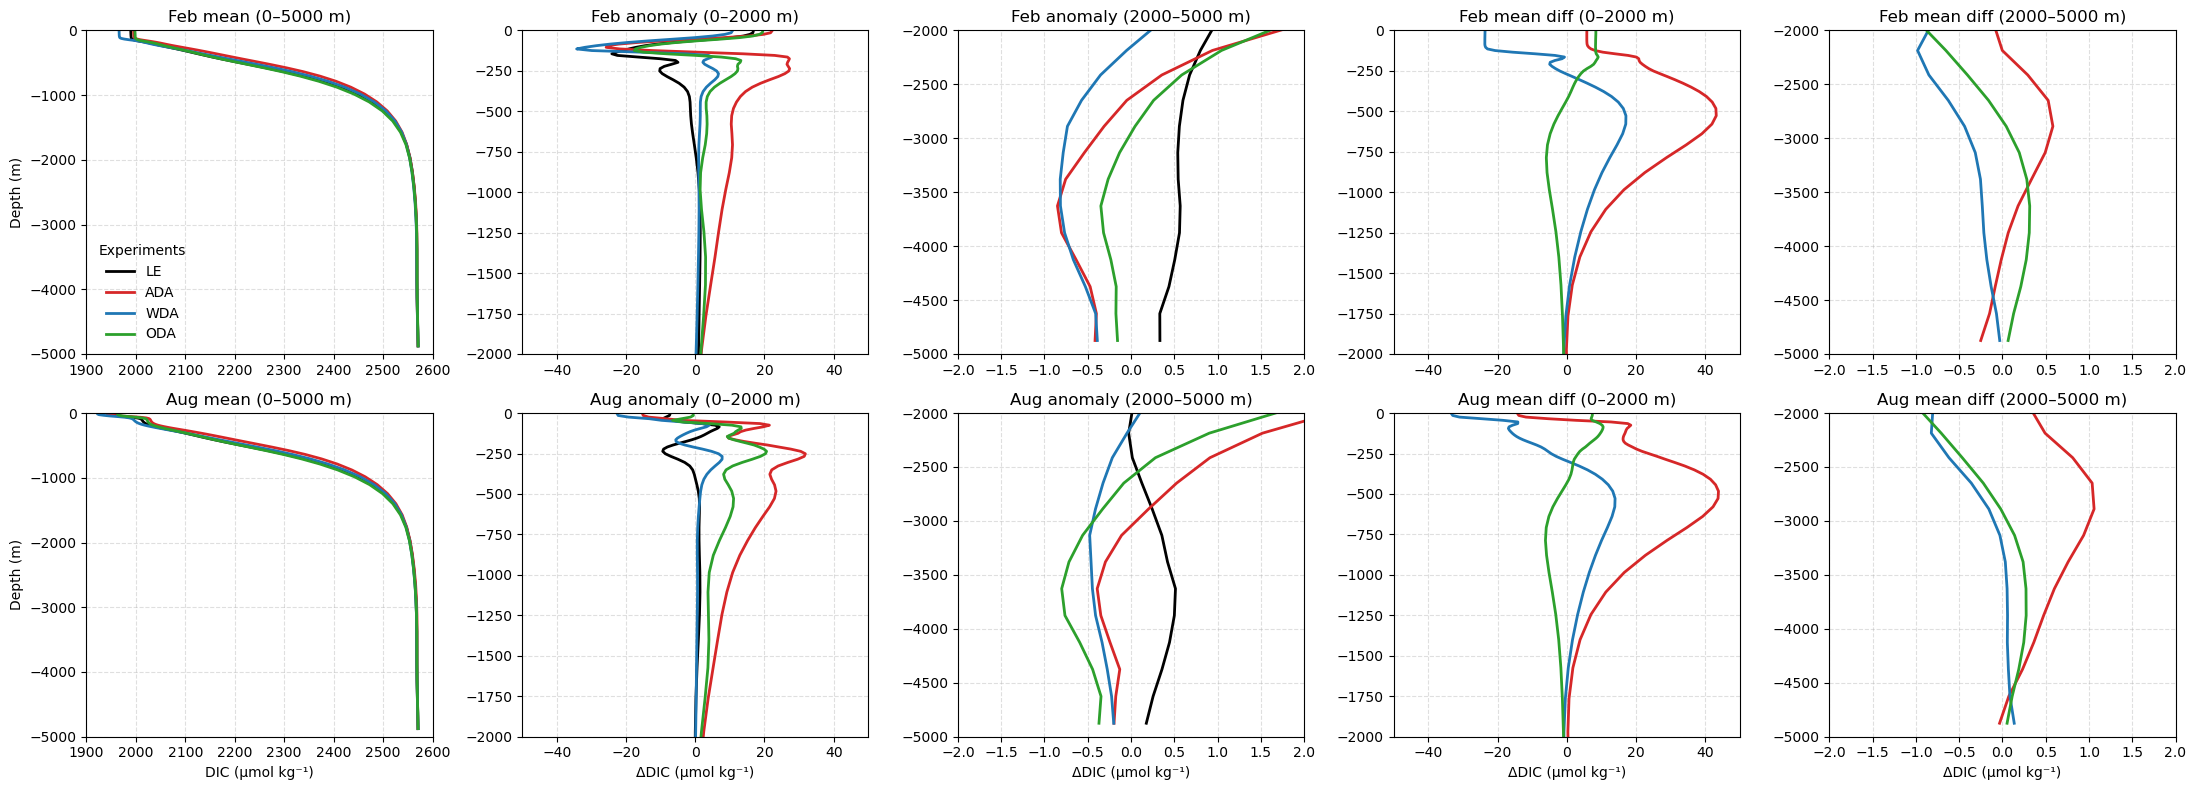

In [263]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: extract monthly-mean vertical structure
# ==========================================================
def extract_dic_vertical_monthlymean(ds_dic, lat_pt=31, lon_pt=155, depth_range=(0, -5000)):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = ds_dic.sel(lat=lat_pt, lon=lon_pt, method="nearest").sel(z_t=slice(*depth_range))
    return da.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_dic_vertical_monthlymean(cfg_var_DIC.LE_ds_rgd)
vert_ADA = extract_dic_vertical_monthlymean(cfg_var_DIC.ADA_ds_rgd)
vert_WDA = extract_dic_vertical_monthlymean(cfg_var_DIC.WDA_ds_rgd)
vert_ODA = extract_dic_vertical_monthlymean(cfg_var_DIC.ODA_ds_rgd)

Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Helper: extract anomalies (1990)
# ==========================================================
def extract_dic_vertical_anomaly(ds_dic, lat_pt=31, lon_pt=155, target_year=1990, target_month=2, depth_range=(0, -5000)):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = ds_dic.sel(lat=lat_pt, lon=lon_pt, method="nearest").sel(z_t=slice(*depth_range))
    mean_profile = da.mean(dim="time")
    years = np.array([t.year for t in da.time.values])
    months = np.array([t.month for t in da.time.values])
    mask = (years == target_year) & (months == target_month)
    if not mask.any():
        raise ValueError(f"No data found for {target_year}-{target_month:02d}")
    target = da.isel(time=np.where(mask)[0])
    target_mean = target.mean(dim="time") if target.ndim > 1 else target
    return target_mean - mean_profile

anom_Feb = {
    "LE":  extract_dic_vertical_anomaly(cfg_var_DIC.LE_ds_rgd, target_month=2),
    "ADA": extract_dic_vertical_anomaly(cfg_var_DIC.ADA_ds_rgd, target_month=2),
    "WDA": extract_dic_vertical_anomaly(cfg_var_DIC.WDA_ds_rgd, target_month=2),
    "ODA": extract_dic_vertical_anomaly(cfg_var_DIC.ODA_ds_rgd, target_month=2),
}
anom_Aug = {
    "LE":  extract_dic_vertical_anomaly(cfg_var_DIC.LE_ds_rgd, target_month=8),
    "ADA": extract_dic_vertical_anomaly(cfg_var_DIC.ADA_ds_rgd, target_month=8),
    "WDA": extract_dic_vertical_anomaly(cfg_var_DIC.WDA_ds_rgd, target_month=8),
    "ODA": extract_dic_vertical_anomaly(cfg_var_DIC.ODA_ds_rgd, target_month=8),
}

# ==========================================================
# 4) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 5) Plot: 2×5 panels
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(22, 8), sharey=False)

# 공통 설정
colors_main = ["k", "C3", "C0", "C2"]
colors_diff = ["C3", "C0", "C2"]

# ---------- (1행) February ----------
# (1,1) Mean (0–5000 m)
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
axes[0,0].set_ylim(-5000, 0)
axes[0,0].set_xlim(1900, 2600)
axes[0,0].set_title("Feb mean (0–5000 m)")
axes[0,0].set_ylabel("Depth (m)")
axes[0,0].grid(True, ls="--", alpha=0.4)

# (1,2) Anomaly (0–2000 m)
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,1].plot(anom_Feb[label], anom_Feb[label]["z_t"], color=color, lw=2, label=label)
axes[0,1].set_ylim(-2000, 0)
axes[0,1].set_xlim(-50, 50)
axes[0,1].set_title("Feb anomaly (0–2000 m)")
axes[0,1].grid(True, ls="--", alpha=0.4)

# (1,3) Anomaly (2000–5000 m)
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,2].plot(anom_Feb[label], anom_Feb[label]["z_t"], color=color, lw=2, label=label)
axes[0,2].set_ylim(-5000, -2000)
axes[0,2].set_xlim(-2, 2)
axes[0,2].set_title("Feb anomaly (2000–5000 m)")
axes[0,2].grid(True, ls="--", alpha=0.4)

# (1,4) Mean diff (0–2000 m)
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[0,3].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2, label=label)
axes[0,3].set_ylim(-2000, 0)
axes[0,3].set_xlim(-50, 50)
axes[0,3].set_title("Feb mean diff (0–2000 m)")
axes[0,3].grid(True, ls="--", alpha=0.4)

# (1,5) Mean diff (2000–5000 m)
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[0,4].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2, label=label)
axes[0,4].set_ylim(-5000, -2000)
axes[0,4].set_xlim(-2, 2)
axes[0,4].set_title("Feb mean diff (2000–5000 m)")
axes[0,4].grid(True, ls="--", alpha=0.4)

# ---------- (2행) August ----------
# (2,1) Mean (0–5000 m)
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,0].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
axes[1,0].set_ylim(-5000, 0)
axes[1,0].set_xlim(1900, 2600)
axes[1,0].set_title("Aug mean (0–5000 m)")
axes[1,0].set_ylabel("Depth (m)")
axes[1,0].set_xlabel("DIC (µmol kg⁻¹)")
axes[1,0].grid(True, ls="--", alpha=0.4)

# (2,2) Anomaly (0–2000 m)
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,1].plot(anom_Aug[label], anom_Aug[label]["z_t"], color=color, lw=2, label=label)
axes[1,1].set_ylim(-2000, 0)
axes[1,1].set_xlim(-50, 50)
axes[1,1].set_title("Aug anomaly (0–2000 m)")
axes[1,1].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[1,1].grid(True, ls="--", alpha=0.4)

# (2,3) Anomaly (2000–5000 m)
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,2].plot(anom_Aug[label], anom_Aug[label]["z_t"], color=color, lw=2, label=label)
axes[1,2].set_ylim(-5000, -2000)
axes[1,2].set_xlim(-5, 5)
axes[1,2].set_xlim(-2, 2)
axes[1,2].set_title("Aug anomaly (2000–5000 m)")
axes[1,2].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[1,2].grid(True, ls="--", alpha=0.4)

# (2,4) Mean diff (0–2000 m)
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[1,3].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2, label=label)
axes[1,3].set_ylim(-2000, 0)
axes[1,3].set_xlim(-50, 50)
axes[1,3].set_title("Aug mean diff (0–2000 m)")
axes[1,3].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[1,3].grid(True, ls="--", alpha=0.4)

# (2,5) Mean diff (2000–5000 m)
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[1,4].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2, label=label)
axes[1,4].set_ylim(-5000, -2000)
axes[1,4].set_xlim(-2, 2)
axes[1,4].set_title("Aug mean diff (2000–5000 m)")
axes[1,4].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[1,4].grid(True, ls="--", alpha=0.4)

# ---------- Common legend ----------
axes[0,0].legend(loc="lower left", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


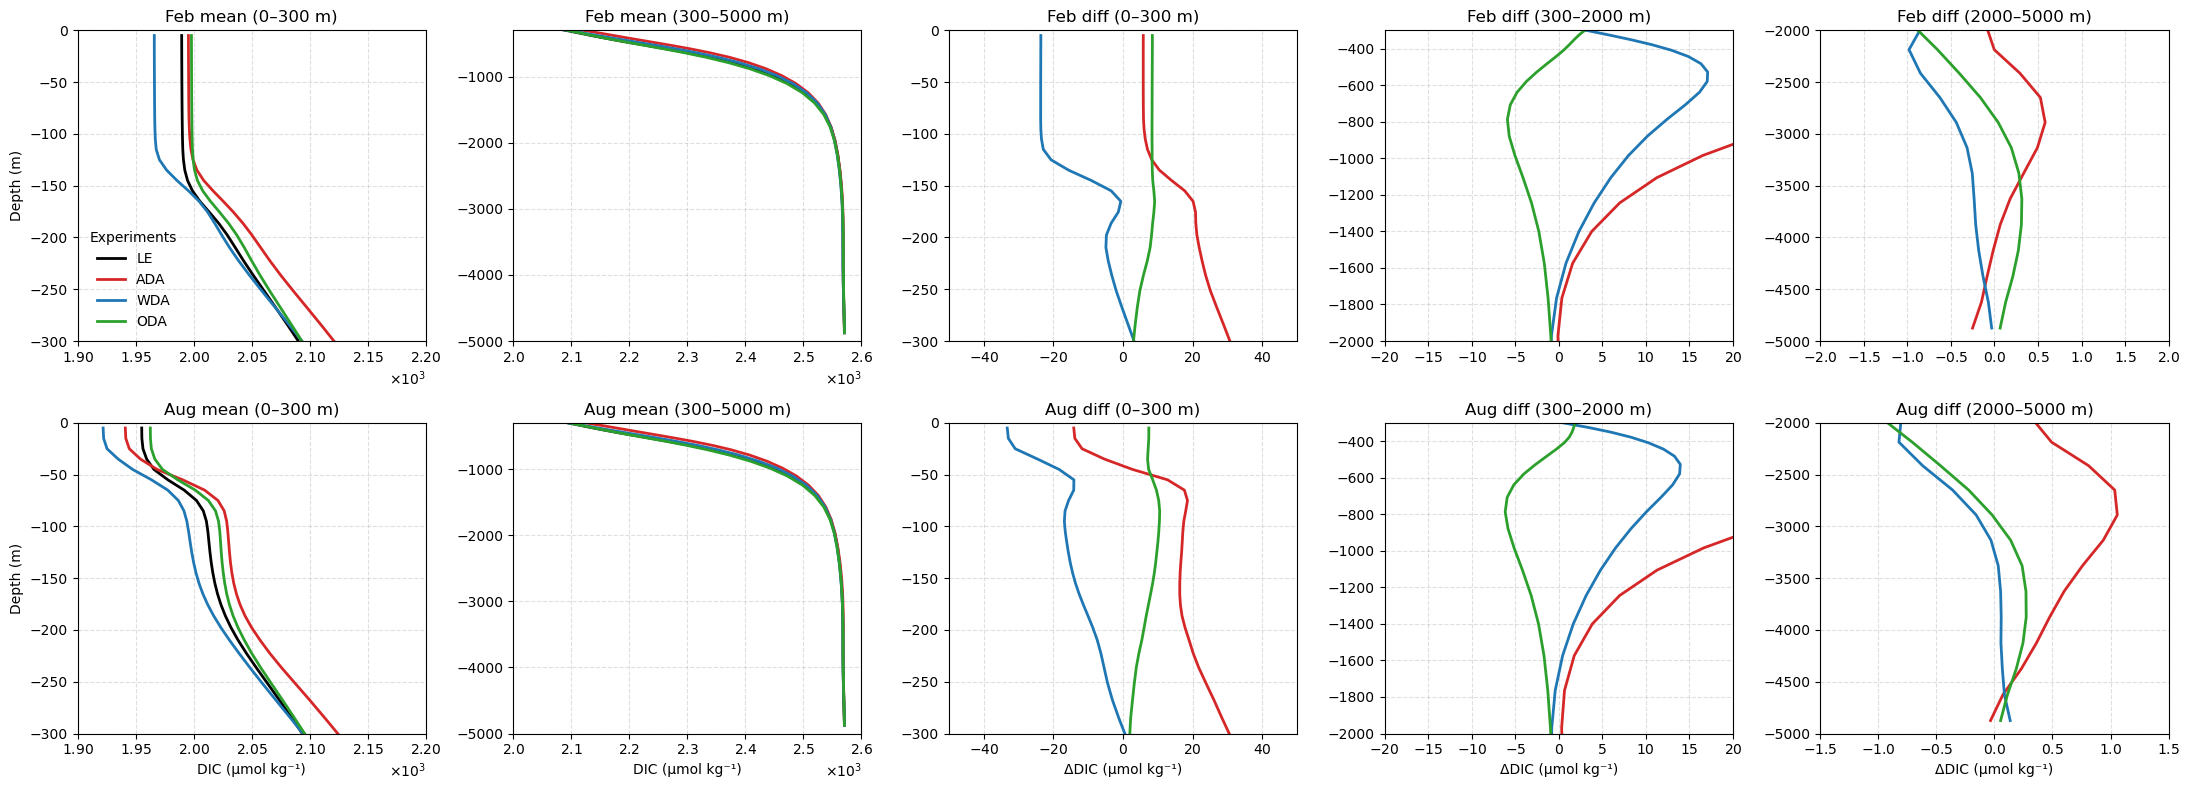

In [291]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: extract monthly-mean vertical structure
# ==========================================================
def extract_dic_vertical_monthlymean(ds_dic, lat_pt=31, lon_pt=155, depth_range=(0, -5000)):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = ds_dic.sel(lat=lat_pt, lon=lon_pt, method="nearest").sel(z_t=slice(*depth_range))
    return da.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_dic_vertical_monthlymean(cfg_var_DIC.LE_ds_rgd)
vert_ADA = extract_dic_vertical_monthlymean(cfg_var_DIC.ADA_ds_rgd)
vert_WDA = extract_dic_vertical_monthlymean(cfg_var_DIC.WDA_ds_rgd)
vert_ODA = extract_dic_vertical_monthlymean(cfg_var_DIC.ODA_ds_rgd)

Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 4) Plot: 2×5 panels
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(22, 8), sharey=False)

colors_main = ["k", "C3", "C0", "C2"]
colors_diff = ["C3", "C0", "C2"]

# ---------- (1행) February ----------
titles_Feb = [
    "Feb mean (0–300 m)",
    "Feb mean (300–5000 m)",
    "Feb diff (0–300 m)",
    "Feb diff (300–2000 m)",
    "Feb diff (2000–5000 m)"
]
for j in range(5):
    axes[0, j].set_title(titles_Feb[j])

# Mean panels (0–300 m, 300–5000 m)
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[0,1].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2)

# Diff panels (3 depth ranges)
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    for ax, (zmin, zmax) in zip(axes[0,2:], [(0, -300), (-300, -2000), (-2000, -5000)]):
        ax.plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)

# ---------- (2행) August ----------
titles_Aug = [
    "Aug mean (0–300 m)",
    "Aug mean (300–5000 m)",
    "Aug diff (0–300 m)",
    "Aug diff (300–2000 m)",
    "Aug diff (2000–5000 m)"
]
for j in range(5):
    axes[1, j].set_title(titles_Aug[j])

# Mean panels
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,0].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[1,1].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2)

# Diff panels
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    for ax, (zmin, zmax) in zip(axes[1,2:], [(0, -300), (-300, -2000), (-2000, -5000)]):
        ax.plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)

# ---------- 공통 축 설정 ----------
for i in range(2):
    for j in range(5):
        axes[i, j].grid(True, ls="--", alpha=0.4)

# Depth 범위
axes[0,0].set_ylim(-300, 0)
axes[1,0].set_ylim(-300, 0)
axes[0,1].set_ylim(-5000, -300)
axes[1,1].set_ylim(-5000, -300)
axes[0,2].set_ylim(-300, 0)
axes[1,2].set_ylim(-300, 0)
axes[0,3].set_ylim(-2000, -300)
axes[1,3].set_ylim(-2000, -300)
axes[0,4].set_ylim(-5000, -2000)
axes[1,4].set_ylim(-5000, -2000)

# X 범위 (각 층 스케일 다르게)
axes[0,0].set_xlim(1900, 2200)
axes[1,0].set_xlim(1900, 2200)
axes[0,1].set_xlim(2000, 2600)
axes[1,1].set_xlim(2000, 2600)
axes[0,2].set_xlim(-50, 50)
axes[1,2].set_xlim(-50, 50)
axes[0,3].set_xlim(-20, 20)
axes[1,3].set_xlim(-20, 20)
axes[0,4].set_xlim(-2, 2)
axes[1,4].set_xlim(-1.5, 1.5)

# ---------- 지수 표기 ----------
from matplotlib.ticker import ScalarFormatter
for i in range(2):
    for j in range(5):
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        axes[i, j].xaxis.set_major_formatter(formatter)
        axes[i, j].ticklabel_format(axis='x', style='sci', scilimits=(-2, 2))

# ---------- Labels ----------
axes[1,0].set_xlabel("DIC (µmol kg⁻¹)")
axes[1,1].set_xlabel("DIC (µmol kg⁻¹)")
for j in [2, 3, 4]:
    axes[1,j].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[0,0].set_ylabel("Depth (m)")
axes[1,0].set_ylabel("Depth (m)")

axes[0,0].legend(loc="lower left", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


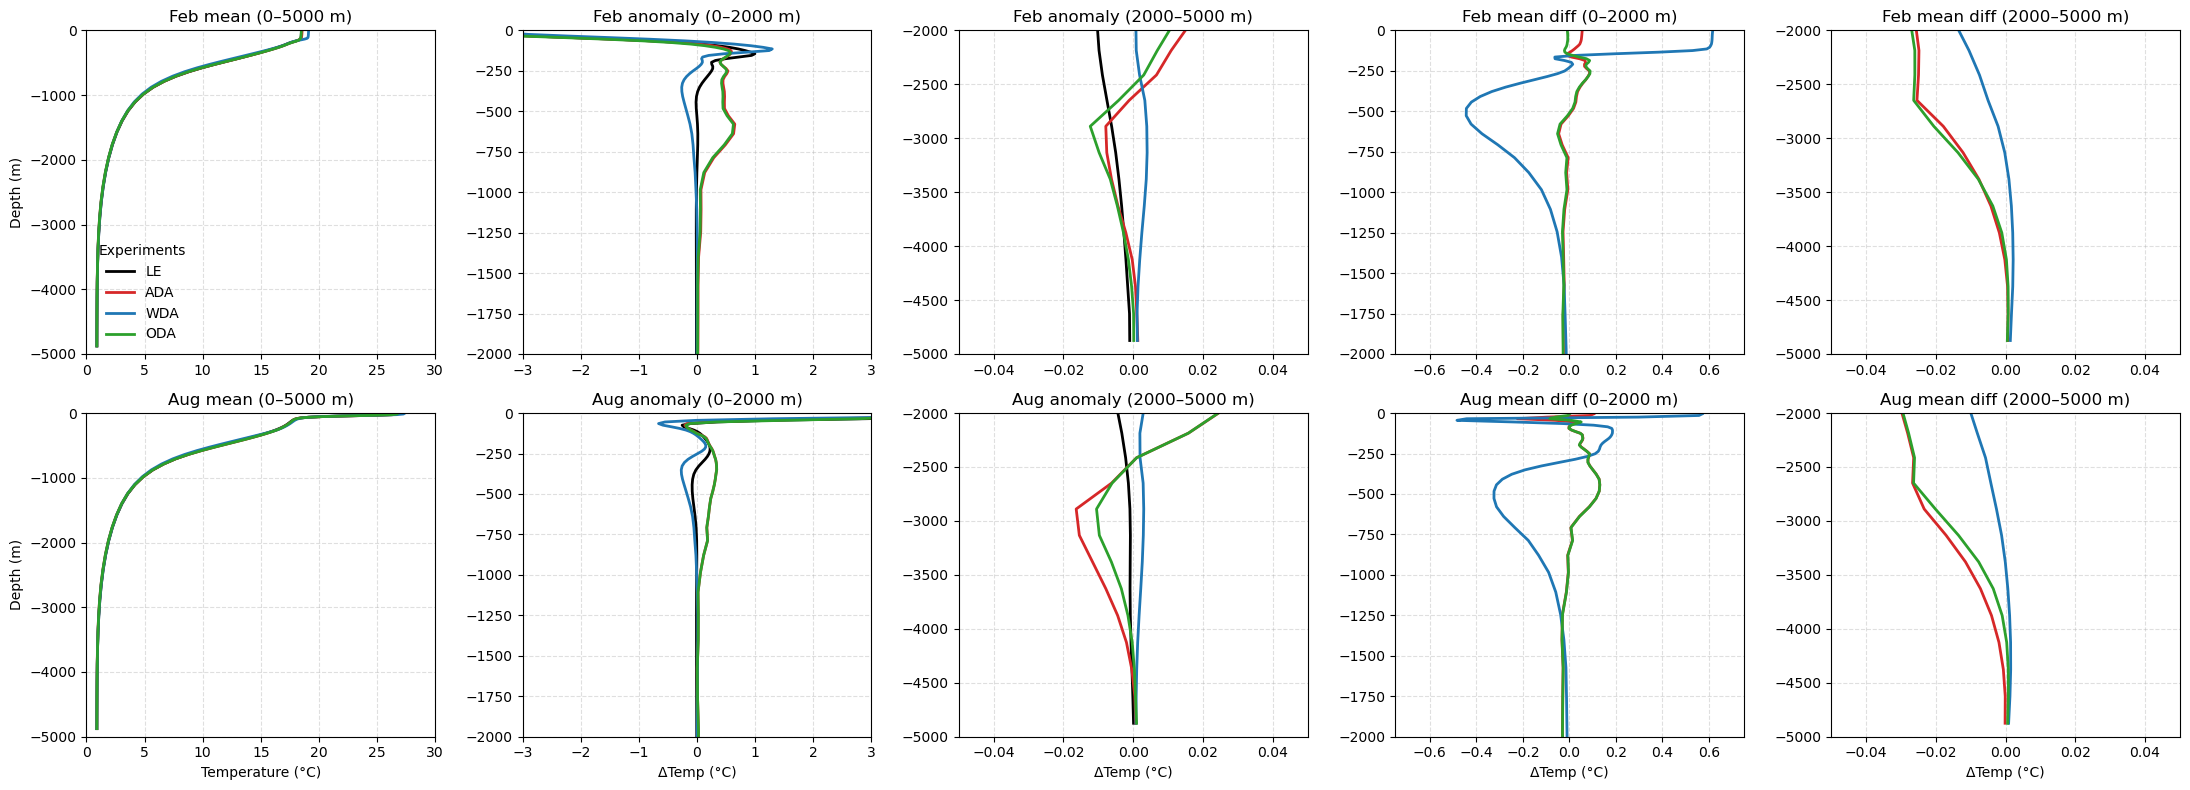

In [267]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: extract monthly-mean vertical structure
# ==========================================================
def extract_temp_vertical_monthlymean(ds_temp, lat_pt=31, lon_pt=155, depth_range=(0, -5000)):
    ds_temp = ds_temp.assign_coords(z_t=-ds_temp.z_t / 100.0)  # cm→m, flip sign
    da = ds_temp.sel(lat=lat_pt, lon=lon_pt, method="nearest").sel(z_t=slice(*depth_range))
    return da.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_temp_vertical_monthlymean(cfg_var_TEMP.LE_ds_rgd)
vert_ADA = extract_temp_vertical_monthlymean(cfg_var_TEMP.ADA_ds_rgd)
vert_WDA = extract_temp_vertical_monthlymean(cfg_var_TEMP.WDA_ds_rgd)
vert_ODA = extract_temp_vertical_monthlymean(cfg_var_TEMP.ODA_ds_rgd)

Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Helper: extract anomalies (1990)
# ==========================================================
def extract_temp_vertical_anomaly(ds_temp, lat_pt=31, lon_pt=155, target_year=1990, target_month=2, depth_range=(0, -5000)):
    ds_temp = ds_temp.assign_coords(z_t=-ds_temp.z_t / 100.0)
    da = ds_temp.sel(lat=lat_pt, lon=lon_pt, method="nearest").sel(z_t=slice(*depth_range))
    mean_profile = da.mean(dim="time")
    years = np.array([t.year for t in da.time.values])
    months = np.array([t.month for t in da.time.values])
    mask = (years == target_year) & (months == target_month)
    if not mask.any():
        raise ValueError(f"No data found for {target_year}-{target_month:02d}")
    target = da.isel(time=np.where(mask)[0])
    target_mean = target.mean(dim="time") if target.ndim > 1 else target
    return target_mean - mean_profile

anom_Feb = {
    "LE":  extract_temp_vertical_anomaly(cfg_var_TEMP.LE_ds_rgd, target_month=2),
    "ADA": extract_temp_vertical_anomaly(cfg_var_TEMP.ADA_ds_rgd, target_month=2),
    "WDA": extract_temp_vertical_anomaly(cfg_var_TEMP.WDA_ds_rgd, target_month=2),
    "ODA": extract_temp_vertical_anomaly(cfg_var_TEMP.ODA_ds_rgd, target_month=2),
}
anom_Aug = {
    "LE":  extract_temp_vertical_anomaly(cfg_var_TEMP.LE_ds_rgd, target_month=8),
    "ADA": extract_temp_vertical_anomaly(cfg_var_TEMP.ADA_ds_rgd, target_month=8),
    "WDA": extract_temp_vertical_anomaly(cfg_var_TEMP.WDA_ds_rgd, target_month=8),
    "ODA": extract_temp_vertical_anomaly(cfg_var_TEMP.ODA_ds_rgd, target_month=8),
}

# ==========================================================
# 4) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 5) Plot: 2×5 panels
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(22, 8), sharey=False)

colors_main = ["k", "C3", "C0", "C2"]
colors_diff = ["C3", "C0", "C2"]

# ---------- (1행) February ----------
axes[0,0].set_title("Feb mean (0–5000 m)")
axes[0,1].set_title("Feb anomaly (0–2000 m)")
axes[0,2].set_title("Feb anomaly (2000–5000 m)")
axes[0,3].set_title("Feb mean diff (0–2000 m)")
axes[0,4].set_title("Feb mean diff (2000–5000 m)")

for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[0,1].plot(anom_Feb[label], anom_Feb[label]["z_t"], color=color, lw=2)
    axes[0,2].plot(anom_Feb[label], anom_Feb[label]["z_t"], color=color, lw=2)

for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[0,3].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)
    axes[0,4].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)

# ---------- (2행) August ----------
axes[1,0].set_title("Aug mean (0–5000 m)")
axes[1,1].set_title("Aug anomaly (0–2000 m)")
axes[1,2].set_title("Aug anomaly (2000–5000 m)")
axes[1,3].set_title("Aug mean diff (0–2000 m)")
axes[1,4].set_title("Aug mean diff (2000–5000 m)")

for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,0].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[1,1].plot(anom_Aug[label], anom_Aug[label]["z_t"], color=color, lw=2)
    axes[1,2].plot(anom_Aug[label], anom_Aug[label]["z_t"], color=color, lw=2)

for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[1,3].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)
    axes[1,4].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)

# ---------- 공통 축 설정 ----------
for i in range(2):
    for j in range(5):
        axes[i, j].grid(True, ls="--", alpha=0.4)

axes[0,0].set_ylim(-5000, 0)
axes[0,1].set_ylim(-2000, 0)
axes[0,2].set_ylim(-5000, -2000)
axes[0,3].set_ylim(-2000, 0)
axes[0,4].set_ylim(-5000, -2000)
axes[1,0].set_ylim(-5000, 0)
axes[1,1].set_ylim(-2000, 0)
axes[1,2].set_ylim(-5000, -2000)
axes[1,3].set_ylim(-2000, 0)
axes[1,4].set_ylim(-5000, -2000)

axes[0,0].set_xlim(0, 30)
axes[1,0].set_xlim(0, 30)

for ax in [axes[0,1], axes[1,1]]:
    ax.set_xlim(-3, 3)
for ax in [axes[0,3], axes[1,3]]:
    ax.set_xlim(-0.75, 0.75)
for ax in [axes[0,2], axes[1,2], axes[0,4], axes[1,4]]:
    ax.set_xlim(-0.05, 0.05)

axes[1,0].set_xlabel("Temperature (°C)")
for j in range(1, 5):
    axes[1, j].set_xlabel("ΔTemp (°C)")
axes[0,0].set_ylabel("Depth (m)")
axes[1,0].set_ylabel("Depth (m)")

axes[0,0].legend(loc="lower left", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


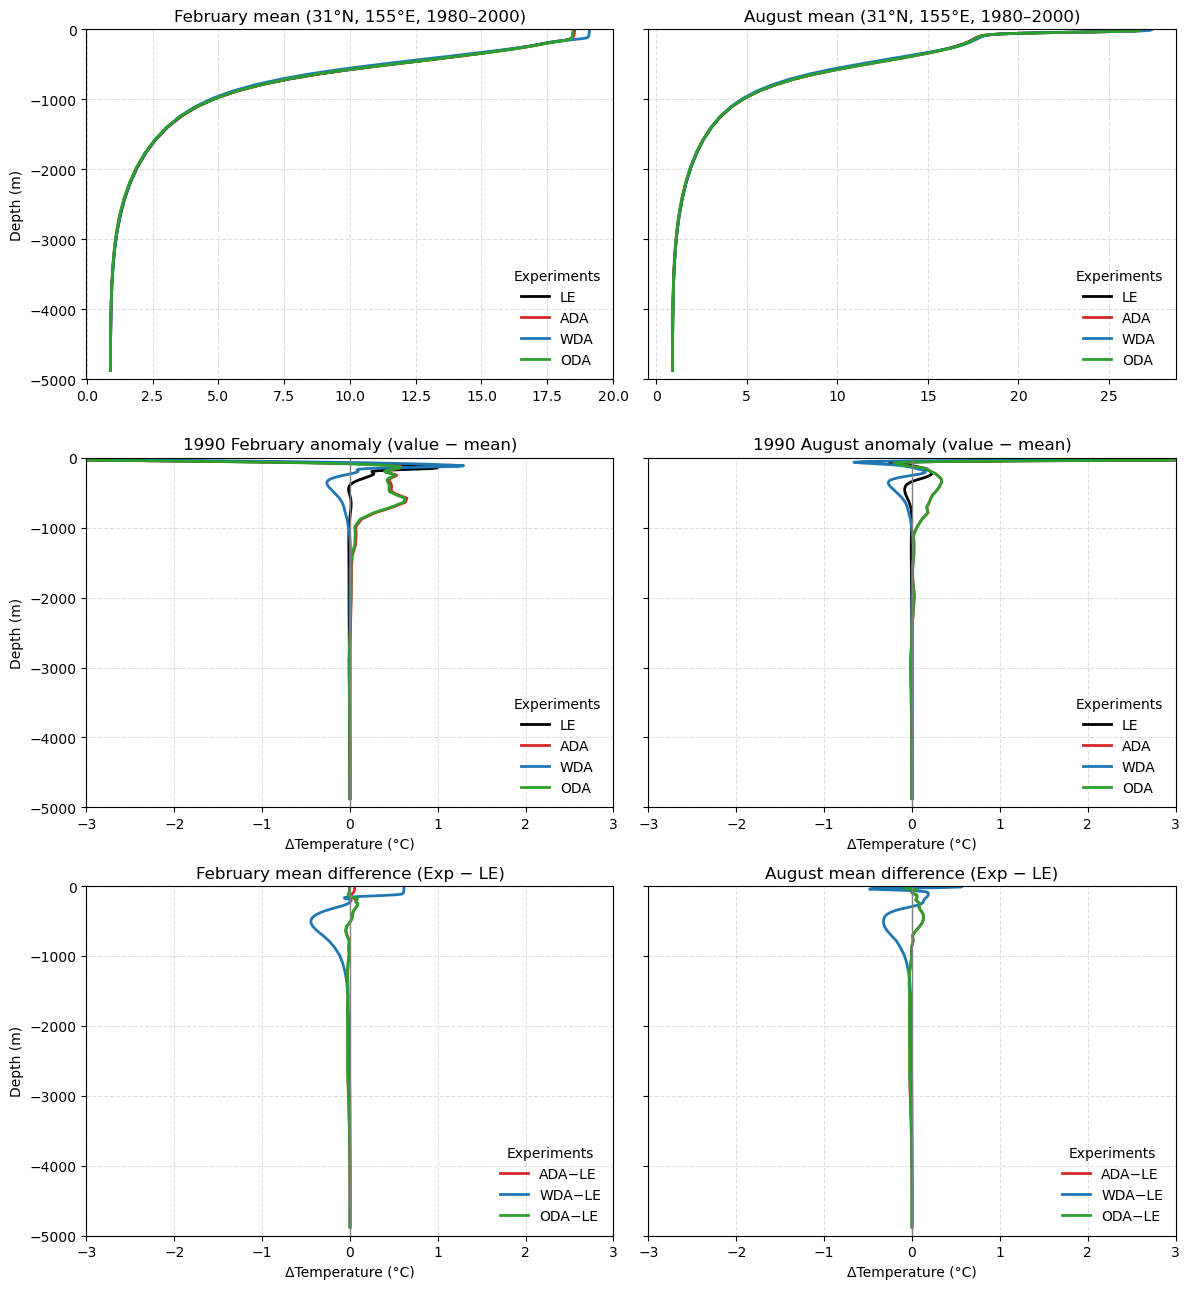

In [235]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: extract monthly-mean vertical structure
# ==========================================================
def extract_temp_vertical_monthlymean(ds_temp, lat_pt=31, lon_pt=155, depth_range=(0, -5000)):
    """
    Return vertical TEMP profile averaged for each calendar month,
    with z_t converted from cm→m and sign flipped (negative downward).
    """
    ds_temp = ds_temp.assign_coords(z_t=-ds_temp.z_t / 100.0)  # cm→m, flip sign
    da = (
        ds_temp
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_temp_vertical_monthlymean(cfg_var_TEMP.LE_ds_rgd)
vert_ADA = extract_temp_vertical_monthlymean(cfg_var_TEMP.ADA_ds_rgd)
vert_WDA = extract_temp_vertical_monthlymean(cfg_var_TEMP.WDA_ds_rgd)
vert_ODA = extract_temp_vertical_monthlymean(cfg_var_TEMP.ODA_ds_rgd)

# Select Feb (2) & Aug (8)
Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Helper: extract 1990 Feb/Aug anomalies
# ==========================================================
def extract_temp_vertical_anomaly(
    ds_temp, lat_pt=31, lon_pt=155, target_year=1990, target_month=2, depth_range=(0, -5000)
):
    """
    Extract vertical TEMP anomaly (given year-month minus full mean).
    Works safely even if only one timestamp exists per month.
    """
    ds_temp = ds_temp.assign_coords(z_t=-ds_temp.z_t / 100.0)
    da = (
        ds_temp
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )

    mean_profile = da.mean(dim="time")
    years = np.array([t.year for t in da.time.values])
    months = np.array([t.month for t in da.time.values])
    mask = (years == target_year) & (months == target_month)

    if not mask.any():
        raise ValueError(f"No data found for {target_year}-{target_month:02d}")

    target = da.isel(time=np.where(mask)[0])
    target_mean = target.mean(dim="time") if target.ndim > 1 else target
    return target_mean - mean_profile


anom_Feb = {
    "LE":  extract_temp_vertical_anomaly(cfg_var_TEMP.LE_ds_rgd, target_month=2),
    "ADA": extract_temp_vertical_anomaly(cfg_var_TEMP.ADA_ds_rgd, target_month=2),
    "WDA": extract_temp_vertical_anomaly(cfg_var_TEMP.WDA_ds_rgd, target_month=2),
    "ODA": extract_temp_vertical_anomaly(cfg_var_TEMP.ODA_ds_rgd, target_month=2),
}
anom_Aug = {
    "LE":  extract_temp_vertical_anomaly(cfg_var_TEMP.LE_ds_rgd, target_month=8),
    "ADA": extract_temp_vertical_anomaly(cfg_var_TEMP.ADA_ds_rgd, target_month=8),
    "WDA": extract_temp_vertical_anomaly(cfg_var_TEMP.WDA_ds_rgd, target_month=8),
    "ODA": extract_temp_vertical_anomaly(cfg_var_TEMP.ODA_ds_rgd, target_month=8),
}

# ==========================================================
# 4) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 5) Plot: 3×2 panels (mean / anomaly / mean-diff)
# ==========================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 13), sharey=True)

# ---------- (1,1) February mean ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
axes[0,0].set_title("February mean (31°N, 155°E, 1980–2000)")
axes[0,0].set_ylabel("Depth (m)")
axes[0,0].set_ylim(-5000, 0)
axes[0,0].grid(True, ls="--", alpha=0.4)

# ---------- (1,2) August mean ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[0,1].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
axes[0,1].set_title("August mean (31°N, 155°E, 1980–2000)")
axes[0,1].set_ylim(-5000, 0)
axes[0,1].grid(True, ls="--", alpha=0.4)

# ---------- (2,1) February 1990 anomaly ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[1,0].plot(anom_Feb[label], anom_Feb[label]["z_t"], color=color, lw=2, label=label)
axes[1,0].axvline(0, color="gray", lw=1)
axes[1,0].set_title("1990 February anomaly (value − mean)")
axes[1,0].set_ylabel("Depth (m)")
axes[1,0].set_xlabel("ΔTemperature (°C)")
axes[1,0].set_ylim(-5000, 0)
axes[1,0].set_xlim(-3, 3)
axes[1,0].grid(True, ls="--", alpha=0.4)

# ---------- (2,2) August 1990 anomaly ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], ["k", "C3", "C0", "C2"]):
    axes[1,1].plot(anom_Aug[label], anom_Aug[label]["z_t"], color=color, lw=2, label=label)
axes[1,1].axvline(0, color="gray", lw=1)
axes[1,1].set_title("1990 August anomaly (value − mean)")
axes[1,1].set_xlabel("ΔTemperature (°C)")
axes[1,1].set_ylim(-5000, 0)
axes[1,1].set_xlim(-3, 3)
axes[1,1].grid(True, ls="--", alpha=0.4)

# ---------- (3,1) February mean differences (Exp − LE) ----------
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], ["C3", "C0", "C2"]):
    axes[2,0].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2, label=label)
axes[2,0].axvline(0, color="gray", lw=1)
axes[2,0].set_title("February mean difference (Exp − LE)")
axes[2,0].set_ylabel("Depth (m)")
axes[2,0].set_xlabel("ΔTemperature (°C)")
axes[2,0].set_ylim(-5000, 0)
axes[2,0].set_xlim(-3, 3)
axes[2,0].grid(True, ls="--", alpha=0.4)

# ---------- (3,2) August mean differences (Exp − LE) ----------
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], ["C3", "C0", "C2"]):
    axes[2,1].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2, label=label)
axes[2,1].axvline(0, color="gray", lw=1)
axes[2,1].set_title("August mean difference (Exp − LE)")
axes[2,1].set_xlabel("ΔTemperature (°C)")
axes[2,1].set_ylim(-5000, 0)
axes[2,1].set_xlim(-3, 3)
axes[2,1].grid(True, ls="--", alpha=0.4)

# ---------- Common legends ----------
for i in range(3):
    for j in range(2):
        axes[i, j].legend(loc="lower right", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


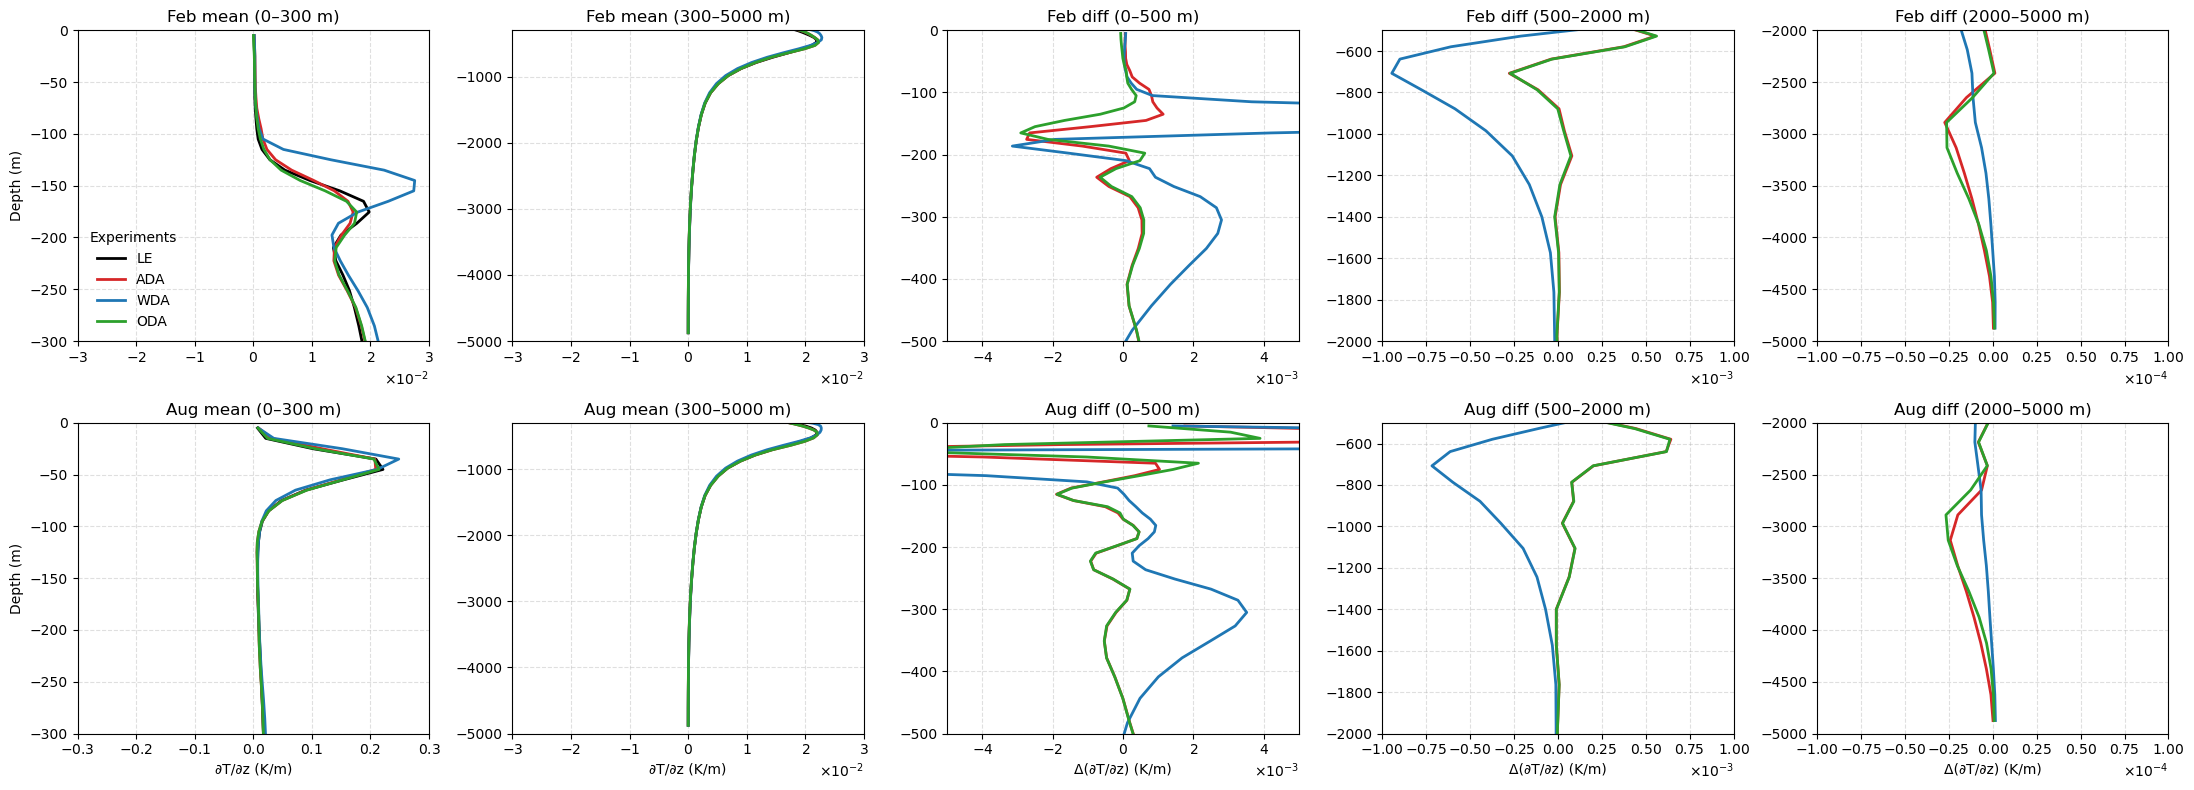

In [287]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.ticker import ScalarFormatter

# ==========================================================
# 1) Helper: compute monthly mean vertical structure
# ==========================================================
def extract_temp_vertical_monthlymean(ds_temp, lat_pt=31, lon_pt=155, depth_range=(0, -5000)):
    ds_temp = ds_temp.assign_coords(z_t=-ds_temp.z_t / 100.0)  # cm→m, flip sign
    da = ds_temp.sel(lat=lat_pt, lon=lon_pt, method="nearest").sel(z_t=slice(*depth_range))
    return da.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Helper: compute vertical gradient (dT/dz)
# ==========================================================
def compute_vertical_gradient(da):
    """Compute dT/dz (K/m) using centered difference."""
    dz = np.gradient(da["z_t"])
    dTdz = np.gradient(da, axis=da.get_axis_num("z_t")) / dz
    dTdz = xr.DataArray(dTdz, coords=da.coords, dims=da.dims)
    dTdz.attrs["long_name"] = "Vertical temperature gradient"
    dTdz.attrs["units"] = "K/m"
    return dTdz

# ==========================================================
# 3) Load and compute means
# ==========================================================
vert_LE  = extract_temp_vertical_monthlymean(cfg_var_TEMP.LE_ds_rgd)
vert_ADA = extract_temp_vertical_monthlymean(cfg_var_TEMP.ADA_ds_rgd)
vert_WDA = extract_temp_vertical_monthlymean(cfg_var_TEMP.WDA_ds_rgd)
vert_ODA = extract_temp_vertical_monthlymean(cfg_var_TEMP.ODA_ds_rgd)

Feb_profiles = {k: compute_vertical_gradient(v.sel(month=2)) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: compute_vertical_gradient(v.sel(month=8)) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 4) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 5) Plot: 2×5 panels
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(22, 8), sharey=False)

colors_main = ["k", "C3", "C0", "C2"]
colors_diff = ["C3", "C0", "C2"]

# ---------- (1행) February ----------
titles_Feb = [
    "Feb mean (0–300 m)",
    "Feb mean (300–5000 m)",
    "Feb diff (0–500 m)",
    "Feb diff (500–2000 m)",
    "Feb diff (2000–5000 m)"
]
for j in range(5): axes[0, j].set_title(titles_Feb[j])

# mean: 0–300 m, 300–5000 m
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[0,1].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2)

# diff: 0–500, 500–2000, 2000–5000
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    for ax, (zmin, zmax) in zip(axes[0,2:], [(0, -500), (-500, -2000), (-2000, -5000)]):
        ax.plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)

# ---------- (2행) August ----------
titles_Aug = [
    "Aug mean (0–300 m)",
    "Aug mean (300–5000 m)",
    "Aug diff (0–500 m)",
    "Aug diff (500–2000 m)",
    "Aug diff (2000–5000 m)"
]
for j in range(5): axes[1, j].set_title(titles_Aug[j])

# mean
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,0].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[1,1].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2)

# diff
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    for ax, (zmin, zmax) in zip(axes[1,2:], [(0, -500), (-500, -2000), (-2000, -5000)]):
        ax.plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)

# ---------- 축 설정 ----------
for i in range(2):
    for j in range(5):
        axes[i, j].grid(True, ls="--", alpha=0.4)

# Depth ranges
axes[0,0].set_ylim(-300, 0)
axes[1,0].set_ylim(-300, 0)
axes[0,1].set_ylim(-5000, -300)
axes[1,1].set_ylim(-5000, -300)
axes[0,2].set_ylim(-500, 0)
axes[1,2].set_ylim(-500, 0)
axes[0,3].set_ylim(-2000, -500)
axes[1,3].set_ylim(-2000, -500)
axes[0,4].set_ylim(-5000, -2000)
axes[1,4].set_ylim(-5000, -2000)

# X ranges
axes[0,0].set_xlim(-0.03, 0.03)
axes[1,0].set_xlim(-0.3, 0.3)
axes[0,1].set_xlim(-0.03, 0.03)
axes[1,1].set_xlim(-0.03, 0.03)
axes[0,2].set_xlim(-0.005, 0.005)
axes[1,2].set_xlim(-0.005, 0.005)
axes[0,3].set_xlim(-0.001, 0.001)
axes[1,3].set_xlim(-0.001, 0.001)
axes[0,4].set_xlim(-0.0001, 0.0001)
axes[1,4].set_xlim(-0.0001, 0.0001)

# ---------- 지수 표기 ----------
for i in range(2):
    for j in range(5):
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))
        axes[i, j].xaxis.set_major_formatter(formatter)
        axes[i, j].ticklabel_format(axis='x', style='sci', scilimits=(-2, 2))

# ---------- Labels ----------
axes[1,0].set_xlabel("∂T/∂z (K/m)")
axes[1,1].set_xlabel("∂T/∂z (K/m)")
for j in [2, 3, 4]:
    axes[1,j].set_xlabel("Δ(∂T/∂z) (K/m)")
axes[0,0].set_ylabel("Depth (m)")
axes[1,0].set_ylabel("Depth (m)")

axes[0,0].legend(loc="lower left", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


Grid (LE): lon=155.00, lat=31.00


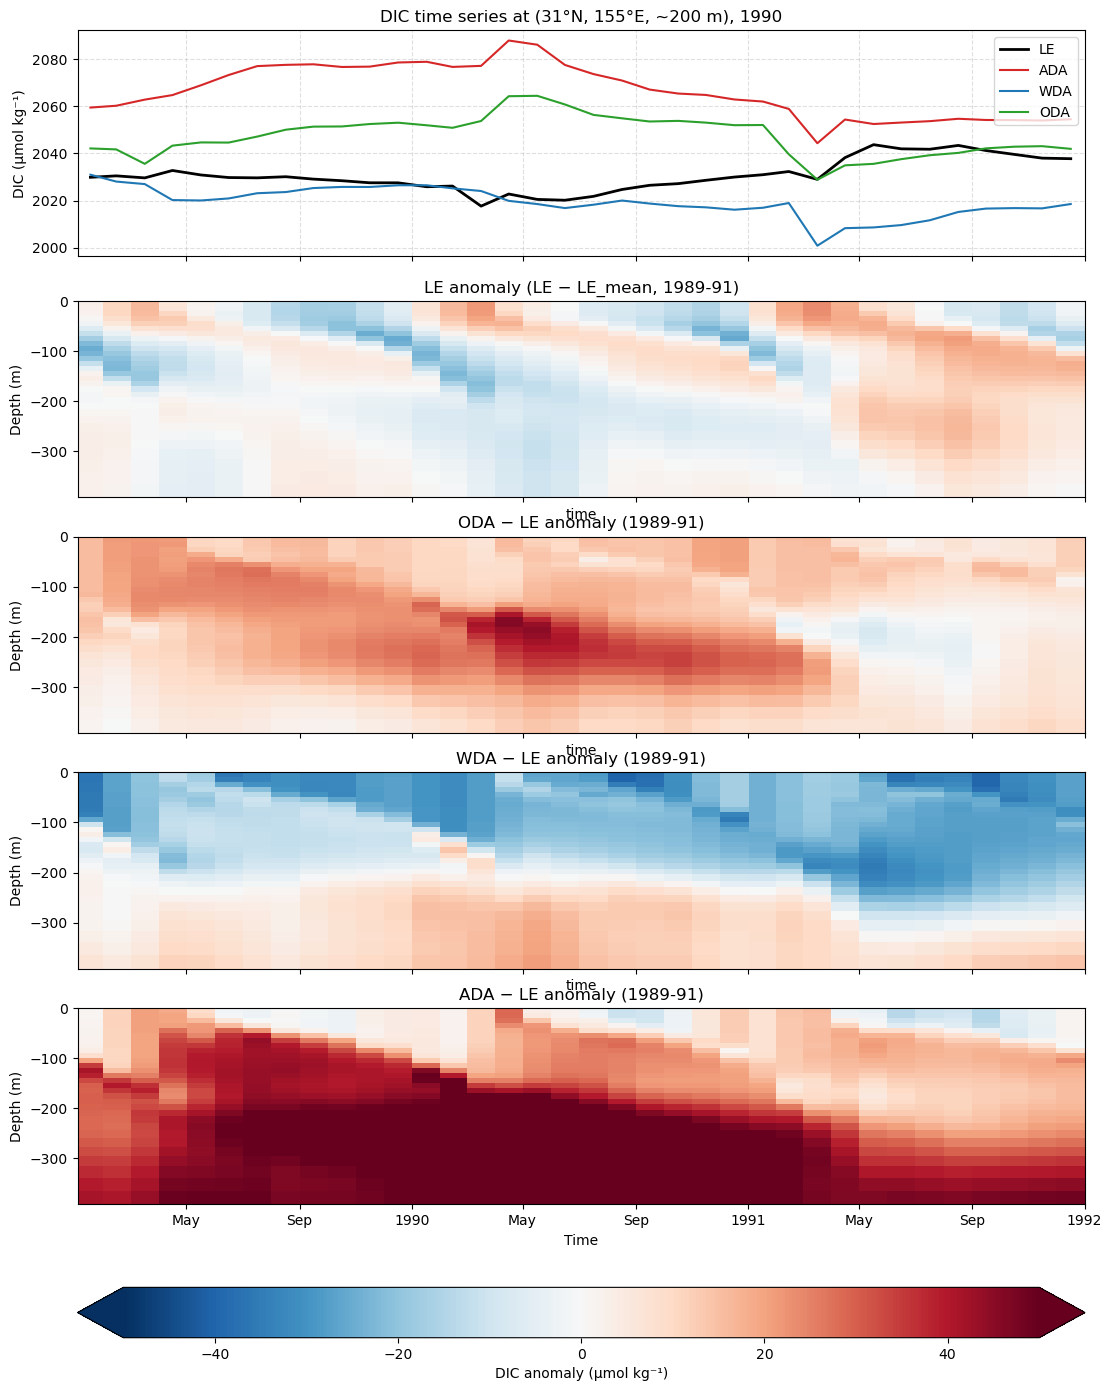

In [176]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    """Safely convert cftime.DatetimeNoLeap to numpy.datetime64 for plotting."""
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da


# ==========================================================
# 2) Helper: extract single-point DIC time series
# ==========================================================
def extract_dic_point(ds_dic, lat_pt=31, lon_pt=155, depth_pt=-200):
    """Extract DIC time series at a specific point (nearest grid)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm → m, flip sign
    da_point = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point


# ==========================================================
# 3) Helper: extract DIC time–depth section
# ==========================================================
def extract_dic_hovmoller(ds_dic, lat_pt=31, lon_pt=155, depth_range=(-5, -400)):
    """Extract DIC time–depth section (Hovmöller) at fixed (lat, lon)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da


# ==========================================================
# 4) Extract datasets
# ==========================================================
ts_LE  = extract_dic_point(cfg_var_DIC.LE_ds_rgd)
ts_ADA = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
ts_WDA = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
ts_ODA = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

hov_LE  = extract_dic_hovmoller(cfg_var_DIC.LE_ds_rgd)
hov_ADA = extract_dic_hovmoller(cfg_var_DIC.ADA_ds_rgd)
hov_WDA = extract_dic_hovmoller(cfg_var_DIC.WDA_ds_rgd)
hov_ODA = extract_dic_hovmoller(cfg_var_DIC.ODA_ds_rgd)

# Convert CFTime → datetime64
ts_LE, ts_ADA, ts_WDA, ts_ODA = map(convert_cftime_to_datetime, [ts_LE, ts_ADA, ts_WDA, ts_ODA])
hov_LE, hov_ADA, hov_WDA, hov_ODA = map(convert_cftime_to_datetime, [hov_LE, hov_ADA, hov_WDA, hov_ODA])

print(f"Grid (LE): lon={float(hov_LE.lon.values):.2f}, lat={float(hov_LE.lat.values):.2f}")

# ==========================================================
# 🔹 5) Restrict to **1990 only**
# ==========================================================
start_date = np.datetime64("1989-01-01")
end_date   = np.datetime64("1991-12-31")

def slice_time(da, start, end):
    """Subset data along time axis."""
    return da.sel(time=slice(start, end))

ts_LE  = slice_time(ts_LE, start_date, end_date)
ts_ADA = slice_time(ts_ADA, start_date, end_date)
ts_WDA = slice_time(ts_WDA, start_date, end_date)
ts_ODA = slice_time(ts_ODA, start_date, end_date)

hov_LE  = slice_time(hov_LE, start_date, end_date)
hov_ADA = slice_time(hov_ADA, start_date, end_date)
hov_WDA = slice_time(hov_WDA, start_date, end_date)
hov_ODA = slice_time(hov_ODA, start_date, end_date)

# ==========================================================
# 6) Compute anomalies
# ==========================================================
hov_LE_anom  = hov_LE - hov_LE.mean(dim="time")  # LE vs full mean
hov_ADA_anom = hov_ADA - hov_LE
hov_WDA_anom = hov_WDA - hov_LE
hov_ODA_anom = hov_ODA - hov_LE

# ==========================================================
# 7) Plot (5 rows: time series + LE anomaly + others)
# ==========================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(13, 17), sharex=True)

# ---------- (1) Time series ----------
axes[0].plot(ts_LE.time,  ts_LE,  label="LE",  color="k", lw=2)
axes[0].plot(ts_ADA.time, ts_ADA, label="ADA", color="C3")
axes[0].plot(ts_WDA.time, ts_WDA, label="WDA", color="C0")
axes[0].plot(ts_ODA.time, ts_ODA, label="ODA", color="C2")
axes[0].set_title("DIC time series at (31°N, 155°E, ~200 m), 1990")
axes[0].set_ylabel("DIC (µmol kg⁻¹)")
axes[0].grid(True, ls="--", alpha=0.4)
axes[0].legend()

# ---------- (2–5) Hovmöllers ----------
plot_kw_anom = dict(x="time", y="z_t", cmap="RdBu_r", vmin=-50, vmax=50, add_colorbar=False)

# (2) LE anomaly (relative to its full-period mean)
p0 = hov_LE_anom.plot(ax=axes[1], **plot_kw_anom)
axes[1].set_title("LE anomaly (LE − LE_mean, 1989-91)")

# (3) ODA − LE
p1 = hov_ODA_anom.plot(ax=axes[2], **plot_kw_anom)
axes[2].set_title("ODA − LE anomaly (1989-91)")

# (4) WDA − LE
p2 = hov_WDA_anom.plot(ax=axes[3], **plot_kw_anom)
axes[3].set_title("WDA − LE anomaly (1989-91)")

# (5) ADA − LE
p3 = hov_ADA_anom.plot(ax=axes[4], **plot_kw_anom)
axes[4].set_title("ADA − LE anomaly (1989-91)")

# ---------- Axis setup ----------
for ax in axes[1:]:
    ax.set_ylabel("Depth (m)")
    # ax.invert_yaxis()
axes[-1].set_xlabel("Time")

# ---------- Shared horizontal colorbar ----------
cbar = fig.colorbar(
    p3, ax=axes[1:], orientation="horizontal",
    fraction=0.05, pad=0.08, extend="both"
)
cbar.set_label("DIC anomaly (µmol kg⁻¹)")

# plt.tight_layout()
plt.show()


Grid (LE): lon=155.00, lat=31.00


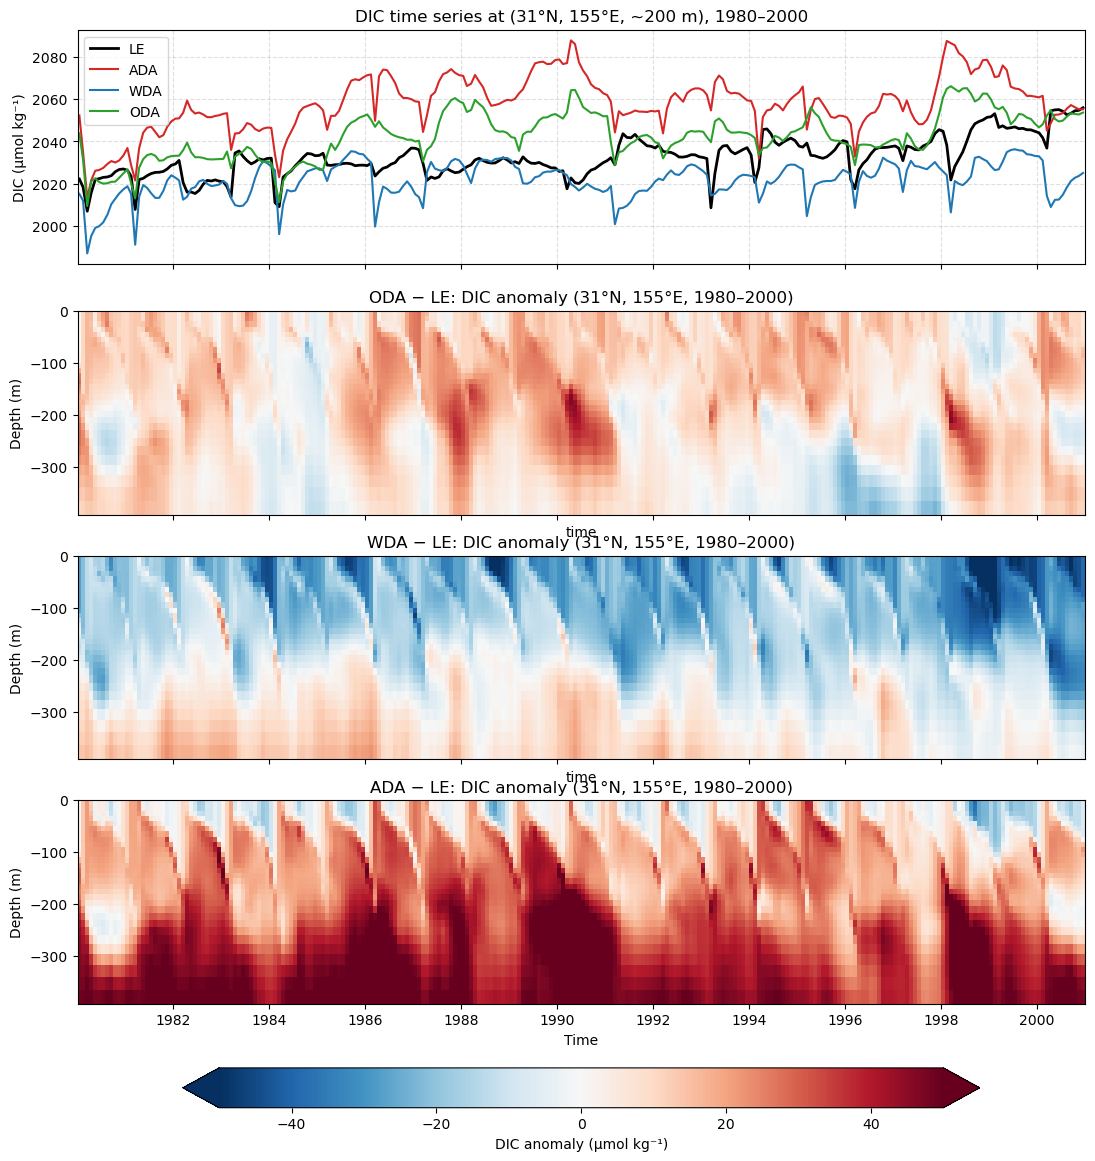

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    """Safely convert cftime.DatetimeNoLeap to numpy.datetime64 for plotting."""
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da


# ==========================================================
# 2) Helper: extract single-point DIC time series
# ==========================================================
def extract_dic_point(ds_dic, lat_pt=31, lon_pt=155, depth_pt=-200):
    """Extract DIC time series at a specific point (nearest grid)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm → m, flip sign
    da_point = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point


# ==========================================================
# 3) Helper: extract DIC time–depth section
# ==========================================================
def extract_dic_hovmoller(ds_dic, lat_pt=31, lon_pt=155, depth_range=(-5, -400)):
    """Extract DIC time–depth section (Hovmöller) at fixed (lat, lon)."""
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da


# ==========================================================
# 4) Extract datasets
# ==========================================================
ts_LE  = extract_dic_point(cfg_var_DIC.LE_ds_rgd)
ts_ADA = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
ts_WDA = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
ts_ODA = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

hov_LE  = extract_dic_hovmoller(cfg_var_DIC.LE_ds_rgd)
hov_ADA = extract_dic_hovmoller(cfg_var_DIC.ADA_ds_rgd)
hov_WDA = extract_dic_hovmoller(cfg_var_DIC.WDA_ds_rgd)
hov_ODA = extract_dic_hovmoller(cfg_var_DIC.ODA_ds_rgd)

# Convert CFTime → datetime64
ts_LE, ts_ADA, ts_WDA, ts_ODA = map(convert_cftime_to_datetime, [ts_LE, ts_ADA, ts_WDA, ts_ODA])
hov_LE, hov_ADA, hov_WDA, hov_ODA = map(convert_cftime_to_datetime, [hov_LE, hov_ADA, hov_WDA, hov_ODA])

print(f"Grid (LE): lon={float(hov_LE.lon.values):.2f}, lat={float(hov_LE.lat.values):.2f}")

# ==========================================================
# 🔹 5) Restrict to 1980–2000 period only
# ==========================================================
start_date = np.datetime64("1980-01-01")
end_date   = np.datetime64("2000-12-31")

def slice_time(da, start, end):
    """Subset data along time axis."""
    return da.sel(time=slice(start, end))

ts_LE  = slice_time(ts_LE, start_date, end_date)
ts_ADA = slice_time(ts_ADA, start_date, end_date)
ts_WDA = slice_time(ts_WDA, start_date, end_date)
ts_ODA = slice_time(ts_ODA, start_date, end_date)

hov_LE  = slice_time(hov_LE, start_date, end_date)
hov_ADA = slice_time(hov_ADA, start_date, end_date)
hov_WDA = slice_time(hov_WDA, start_date, end_date)
hov_ODA = slice_time(hov_ODA, start_date, end_date)

# ==========================================================
# 6) Compute anomalies
# ==========================================================
hov_ADA_anom = hov_ADA - hov_LE
hov_WDA_anom = hov_WDA - hov_LE
hov_ODA_anom = hov_ODA - hov_LE

# ==========================================================
# 7) Plot (1980–2000 only)
# ==========================================================
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(13, 14), sharex=True)

# ---------- (1) Time series ----------
axes[0].plot(ts_LE.time,  ts_LE,  label="LE",  color="k", lw=2)
axes[0].plot(ts_ADA.time, ts_ADA, label="ADA", color="C3")
axes[0].plot(ts_WDA.time, ts_WDA, label="WDA", color="C0")
axes[0].plot(ts_ODA.time, ts_ODA, label="ODA", color="C2")
axes[0].set_title("DIC time series at (31°N, 155°E, ~200 m), 1980–2000")
axes[0].set_ylabel("DIC (µmol kg⁻¹)")
axes[0].grid(True, ls="--", alpha=0.4)
axes[0].legend()

# ---------- (2–4) Hovmöllers (all anomalies) ----------
plot_kw_anom = dict(x="time", y="z_t", cmap="RdBu_r", vmin=-50, vmax=50, add_colorbar=False)

# (2) ODA − LE
p1 = hov_ODA_anom.plot(ax=axes[1], **plot_kw_anom)
axes[1].set_title("ODA − LE: DIC anomaly (31°N, 155°E, 1980–2000)")

# (3) WDA − LE
p2 = hov_WDA_anom.plot(ax=axes[2], **plot_kw_anom)
axes[2].set_title("WDA − LE: DIC anomaly (31°N, 155°E, 1980–2000)")

# (4) ADA − LE
p3 = hov_ADA_anom.plot(ax=axes[3], **plot_kw_anom)
axes[3].set_title("ADA − LE: DIC anomaly (31°N, 155°E, 1980–2000)")

# ---------- Axis setup ----------
for ax in axes[1:]:
    ax.set_ylabel("Depth (m)")
    # ax.invert_yaxis()  # surface up
axes[-1].set_xlabel("Time")

# ---------- Shared horizontal colorbar (bottom) ----------
cbar = fig.colorbar(
    p3, ax=axes[1:], orientation="horizontal",
    fraction=0.05, pad=0.08, extend="both"
)
cbar.set_label("DIC anomaly (µmol kg⁻¹)")

# plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# =====================================
# 1) Data — WDA, ODA
# =====================================
ds1 = (
    ADA_WDA
    .sel(lat=31, method="nearest")
    .mean(dim='time')
    .sel(z_t=slice(-5, -800))
)

ds2 = (
    ADA_ODA
    .sel(lat=31, method="nearest")
    .mean(dim='time')
    .sel(z_t=slice(-5, -800))
)

# =====================================
# 2) STMWW frequency 계산
# =====================================
ds = ADA_STMWW_rgd.assign_coords(z_t = -ADA_STMWW_rgd.z_t / 100.0)

mask = (
    ds
    .sel(lat=31, method="nearest")
    .sel(z_t=slice(-5, -800))
)

freq = mask.astype(float).mean(dim='time') * 100.0

# ---------------------------
# (0) Mask: freq ≥ 70
# ---------------------------
STMWW_mask = freq >= 70

# Apply mask to ds1 and ds2
ds1_masked = ds1.where(STMWW_mask)
ds2_masked = ds2.where(STMWW_mask)

# =====================================
# 3) Figure 생성
# =====================================
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(14, 15), sharex=True
)

# (1) ADA_WDA
p1 = ds1_masked.plot(
    ax=axes[0],
    y='z_t',
    vmin=-40, vmax=40,
    cmap='RdBu_r',
    add_colorbar=True,
)
axes[0].set_title("ADA_WDA (31°N, all lon, masked by freq ≥ 80%)")

# (2) ADA_ODA
p2 = ds2_masked.plot(
    ax=axes[1],
    y='z_t',
    vmin=-40, vmax=40,
    cmap='RdBu_r',
    add_colorbar=True,
)
axes[1].set_title("ADA_ODA (31°N, all lon, masked by freq ≥ 80%)")

# (3) STMWW Frequency Panel
p3 = freq.plot(
    ax=axes[2],
    y='z_t',
    cmap='viridis',
    vmin=0, vmax=100,
    add_colorbar=True,
)

axes[2].set_title("STMWW Occurrence Frequency (%) at 31°N")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Depth (m)")

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

ds=ADA_STMWW_rgd.assign_coords(z_t = -ADA_STMWW_rgd.z_t / 100.0)

# 1) lat=31, depth slice 적용
mask = (
    ds
    .sel(lat=31, method="nearest")          # lat=31
    .sel(z_t=slice(-5, -800))               # depth
)

# 2) True/False → 1/0 변환 후, 시간 평균
freq = mask.astype(float).mean(dim='time') * 100.0   # percentage (%)

# 3) Plot
plt.figure(figsize=(12, 5))

p = freq.plot(
    y='z_t',
    cmap='viridis',
    vmin=0, vmax=100,
)

# plt.gca().invert_yaxis()
plt.title("STMWW Occurrence Frequency (%) at 31°N")
plt.xlabel("Longitude")
plt.ylabel("Depth (m)")

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# =====================================
# 0) Feb only 선택
# =====================================
ds1_Feb = (
    ADA_WDA
    .sel(time=ADA_WDA.time.dt.month == 2)
    .sel(lat=31, method="nearest")
    .mean(dim='time')
    .sel(z_t=slice(-5, -800))
)

ds2_Feb = (
    ADA_ODA
    .sel(time=ADA_ODA.time.dt.month == 2)
    .sel(lat=31, method="nearest")
    .mean(dim='time')
    .sel(z_t=slice(-5, -800))
)

# =====================================
# 2) STMWW frequency 계산 (2월만)
# =====================================
ds = ADA_STMWW_rgd.assign_coords(z_t = -ADA_STMWW_rgd.z_t / 100.0)

mask_Feb = (
    ds
    .sel(time=ds.time.dt.month == 2)
    .sel(lat=31, method="nearest")
    .sel(z_t=slice(-5, -800))
)

freq_Feb = mask_Feb.astype(float).mean(dim='time') * 100.0

# ---------------------------
# (0) Mask: freq ≥ 70
# ---------------------------
STMWW_mask_Feb = freq_Feb >= 70

# Apply mask to ds1 and ds2
ds1_masked = ds1_Feb.where(STMWW_mask_Feb)
ds2_masked = ds2_Feb.where(STMWW_mask_Feb)

# =====================================
# 3) Figure 생성
# =====================================
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(14, 15), sharex=True
)

# (1) ADA_WDA Feb
p1 = ds1_masked.plot(
    ax=axes[0],
    y='z_t',
    vmin=-40, vmax=40,
    cmap='RdBu_r',
    add_colorbar=True,
)
axes[0].set_title("ADA_WDA (FEB, 31°N, masked by freq ≥ 70%)")

# (2) ADA_ODA Feb
p2 = ds2_masked.plot(
    ax=axes[1],
    y='z_t',
    vmin=-40, vmax=40,
    cmap='RdBu_r',
    add_colorbar=True,
)
axes[1].set_title("ADA_ODA (FEB, 31°N, masked by freq ≥ 70%)")

# (3) STMWW Frequency (FEB)
p3 = freq_Feb.plot(
    ax=axes[2],
    y='z_t',
    cmap='viridis',
    vmin=0, vmax=100,
    add_colorbar=True,
)

axes[2].set_title("STMWW Occurrence Frequency (%) in February at 31°N")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Depth (m)")

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# =====================================
# 0) Aug only 선택
# =====================================
ds1_Aug = (
    ADA_WDA
    .sel(time=ADA_WDA.time.dt.month == 8)
    .sel(lat=31, method="nearest")
    .mean(dim='time')
    .sel(z_t=slice(-5, -800))
)

ds2_Aug = (
    ADA_ODA
    .sel(time=ADA_ODA.time.dt.month == 8)
    .sel(lat=31, method="nearest")
    .mean(dim='time')
    .sel(z_t=slice(-5, -800))
)

# =====================================
# 2) STMWW frequency 계산 (8월만)
# =====================================
ds = ADA_STMWW_rgd.assign_coords(z_t = -ADA_STMWW_rgd.z_t / 100.0)

mask_Aug = (
    ds
    .sel(time=ds.time.dt.month == 8)
    .sel(lat=31, method="nearest")
    .sel(z_t=slice(-5, -800))
)

freq_Aug = mask_Aug.astype(float).mean(dim='time') * 100.0

# ---------------------------
# (0) Mask: freq ≥ 70
# ---------------------------
STMWW_mask_Aug = freq_Aug >= 70

# Apply mask to ds1 and ds2
ds1_masked = ds1_Aug.where(STMWW_mask_Aug)
ds2_masked = ds2_Aug.where(STMWW_mask_Aug)

# =====================================
# 3) Figure 생성
# =====================================
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(14, 15), sharex=True
)

# (1) ADA_WDA Aug
p1 = ds1_masked.plot(
    ax=axes[0],
    y='z_t',
    vmin=-40, vmax=40,
    cmap='RdBu_r',
    add_colorbar=True,
)
axes[0].set_title("ADA_WDA (AUG, 31°N, masked by freq ≥ 70%)")

# (2) ADA_ODA Aug
p2 = ds2_masked.plot(
    ax=axes[1],
    y='z_t',
    vmin=-40, vmax=40,
    cmap='RdBu_r',
    add_colorbar=True,
)
axes[1].set_title("ADA_ODA (AUG, 31°N, masked by freq ≥ 70%)")

# (3) STMWW Frequency (AUG)
p3 = freq_Aug.plot(
    ax=axes[2],
    y='z_t',
    cmap='viridis',
    vmin=0, vmax=100,
    add_colorbar=True,
)

axes[2].set_title("STMWW Occurrence Frequency (%) in August at 31°N")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Depth (m)")

plt.tight_layout()
plt.show()


In [129]:
# cfg_var_TEMP.LE_ds_rgd = cfg_var_TEMP.LE_ds_rgd.rename({"depth": "z_t"})
# cfg_var_TEMP.LE_ds_rgd = cfg_var_TEMP.LE_ds_rgd.assign_coords(z_t = cfg_var_TEMP.ODA_ds.z_t)

In [130]:
import numpy as np

def compute_N2_from_temp(ds_temp, alpha=2e-4, g=9.81):
    """
    Rough stratification (N²) computed from temperature gradient only.
    ds_temp: xarray.DataArray with dims including z_t (increasing positive depth)
    """
    # 1) z_t가 양수(수심 증가 방향)일 때는 정렬 필요 없음
    temp_sorted = ds_temp.sortby('z_t')

    # 2) dT/dz 직접 계산
    dTdz = -temp_sorted.differentiate('z_t')

    # 3) Temperature-only N² 계산
    N2 = g * alpha * dTdz

    return N2


N2_WDA = compute_N2_from_temp(cfg_var_TEMP.WDA_ds_rgd)
N2_ADA = compute_N2_from_temp(cfg_var_TEMP.ADA_ds_rgd)
N2_ODA = compute_N2_from_temp(cfg_var_TEMP.ODA_ds_rgd)
N2_LE = compute_N2_from_temp(cfg_var_TEMP.LE_ds_rgd)

In [138]:
mask_LE

<xarray.DataArray 'LE2_STMWW' (z_t: 38, lon: 70)> Size: 3kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    ens      float64 8B 6.0
    lat      float64 8B 31.0
  * lon      (lon) float64 560B 110.0 111.0 112.0 113.0 ... 177.0 178.0 179.0
  * z_t      (z_t) float32 152B -5.0 -15.0 -25.0 -35.0 ... -638.9 -707.6 -787.0

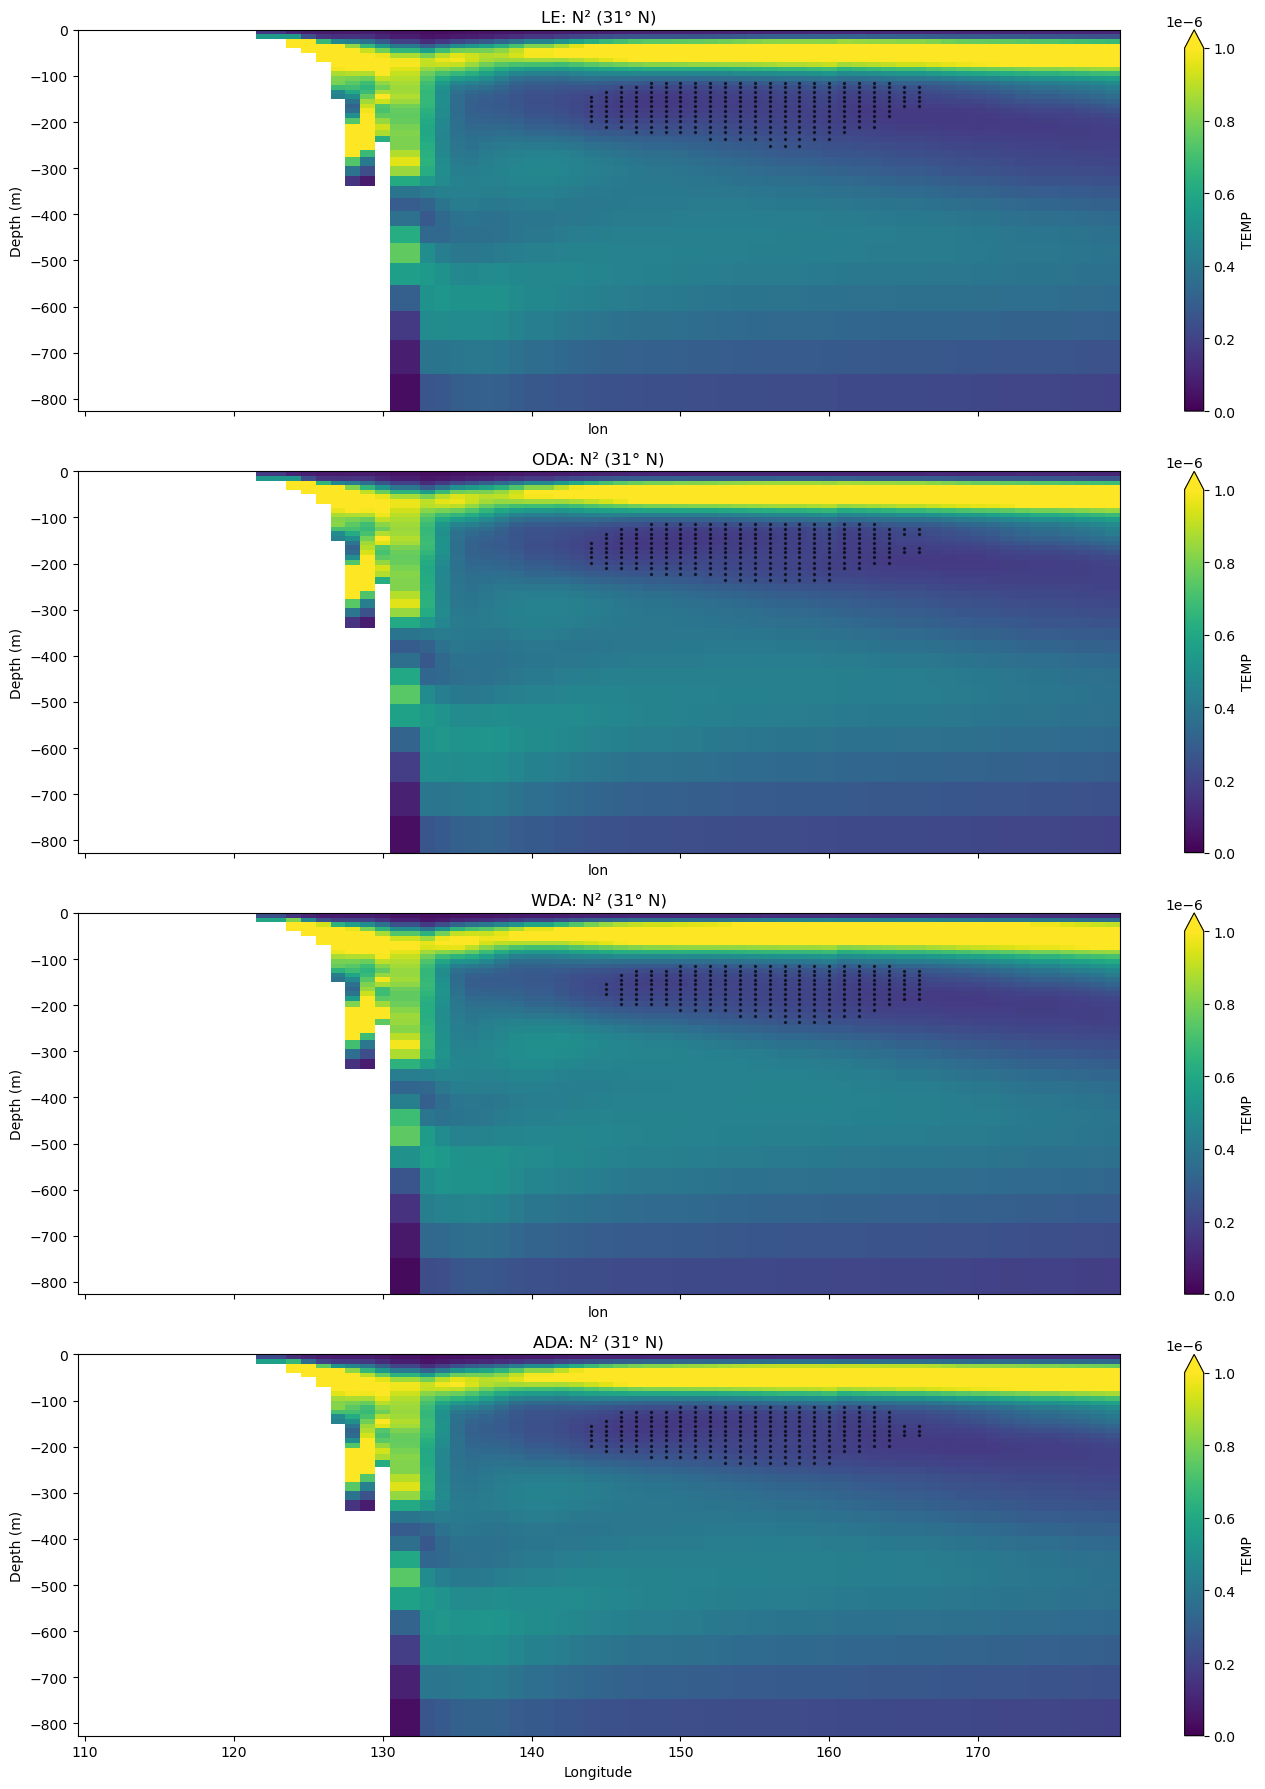

In [173]:
import numpy as np
import matplotlib.pyplot as plt

# =====================================
# 1) Convert z_t (cm → m, flip sign)
# =====================================
N2_LE_rgd  = N2_LE.assign_coords(z_t=-N2_LE.z_t / 100.0)
N2_ODA_rgd = N2_ODA.assign_coords(z_t=-N2_ODA.z_t / 100.0)
N2_WDA_rgd = N2_WDA.assign_coords(z_t=-N2_WDA.z_t / 100.0)
N2_ADA_rgd = N2_ADA.assign_coords(z_t=-N2_ADA.z_t / 100.0)

# =====================================
# 2) Select August mean at 31° N
# =====================================
def select_aug(ds):
    """Select August mean at 31° N (depth −5 to −800 m)."""
    return (
        ds
        .sel(lat=31, method="nearest")
        .mean(dim="time")
        .sel(z_t=slice(-5, -800))
    )

N2_LE_Aug  = select_aug(N2_LE_rgd)
N2_ODA_Aug = select_aug(N2_ODA_rgd)
N2_WDA_Aug = select_aug(N2_WDA_rgd)
N2_ADA_Aug = select_aug(N2_ADA_rgd)

# =====================================
# 3) Prepare STMWW mask (≥ 70 %)
# =====================================
def prepare_mask(ds_mask):
    """Compute STMWW frequency ≥ 70 % mask at 31° N."""
    ds_mask = ds_mask.assign_coords(z_t=-ds_mask.z_t / 100.0)
    freq = (
        ds_mask
        .sel(lat=31, method="nearest")
        .sel(z_t=slice(-5, -800))
        .astype(float)
        .mean(dim="time") * 100.0
    )
    return freq >= 70

mask_LE  = prepare_mask(LE_STMWW_rgd)
mask_ODA = prepare_mask(ODA_STMWW_rgd)
mask_WDA = prepare_mask(WDA_STMWW_rgd)
mask_ADA = prepare_mask(ADA_STMWW_rgd)

# =====================================
# 4) Helper: plot with mask overlay
# =====================================
def plot_with_mask(ax, data, mask, title, plot_kw, dot_kw):
    """Plot N² field and overlay STMWW ≥ 70 % dots."""
    p = data.plot(ax=ax, **plot_kw)
    lon2d, z2d = np.meshgrid(mask.lon, mask.z_t)
    lon_masked = lon2d[mask.values]
    z_masked   = z2d[mask.values]
    ax.scatter(lon_masked, z_masked, **dot_kw)
    ax.set_title(title)
    return p

# =====================================
# 5) Plot 4×1 figure
# =====================================
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 18), sharex=True)

plot_kw = dict(y="z_t", cmap="viridis", vmin=0, vmax=1e-6, add_colorbar=True)
dot_kw  = dict(color="k", s=8, marker=".", alpha=0.6)

plot_with_mask(axes[0], N2_LE_Aug,  mask_LE,  "LE: N² (31° N)",  plot_kw, dot_kw)
plot_with_mask(axes[1], N2_ODA_Aug, mask_ODA, "ODA: N² (31° N)", plot_kw, dot_kw)
plot_with_mask(axes[2], N2_WDA_Aug, mask_WDA, "WDA: N² (31° N)", plot_kw, dot_kw)
plot_with_mask(axes[3], N2_ADA_Aug, mask_ADA, "ADA: N² (31° N)", plot_kw, dot_kw)

for ax in axes:
    ax.set_ylabel("Depth (m)")
axes[-1].set_xlabel("Longitude")

plt.tight_layout()
plt.show()


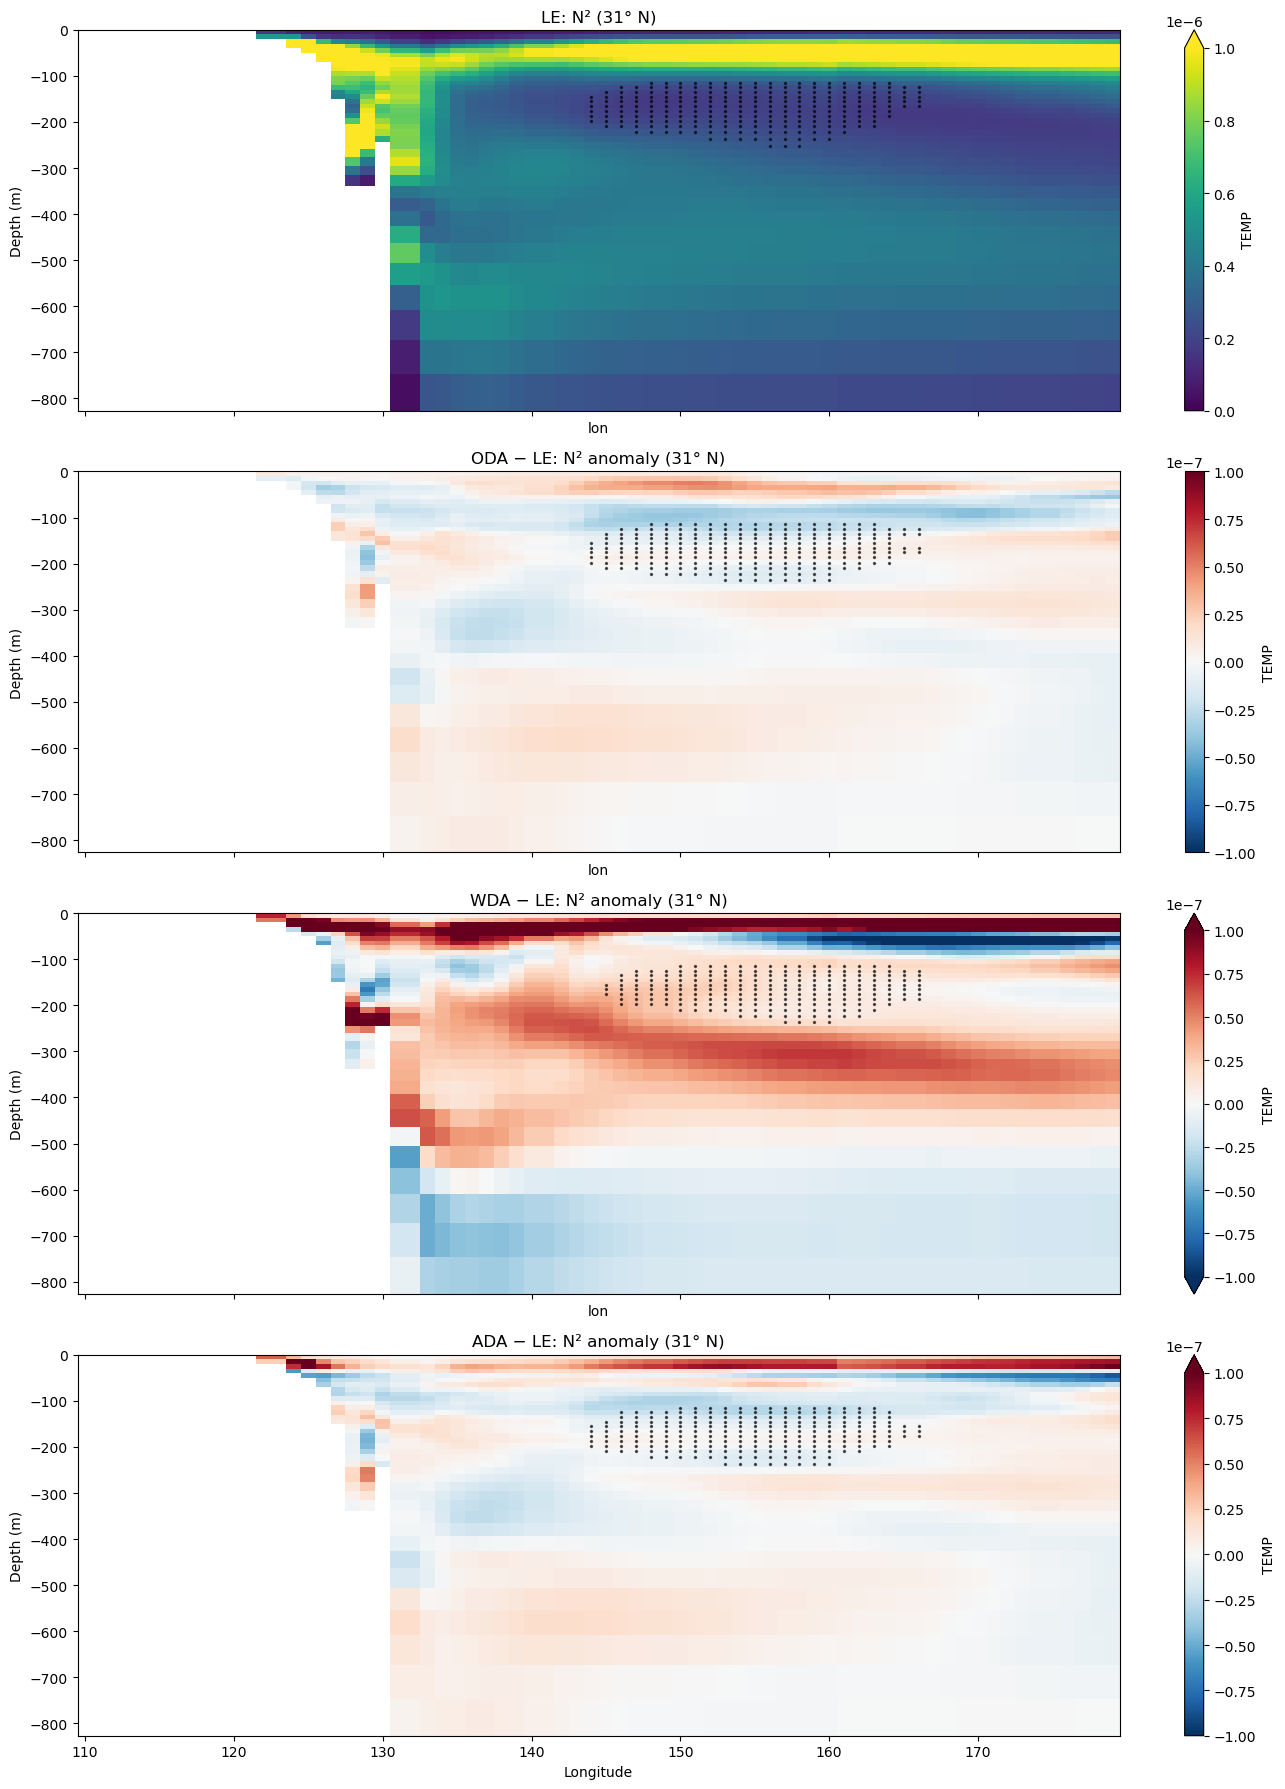

In [174]:
import numpy as np
import matplotlib.pyplot as plt

# =====================================
# 1) Convert z_t (cm → m, flip sign)
# =====================================
N2_LE_rgd  = N2_LE.assign_coords(z_t=-N2_LE.z_t / 100.0)
N2_ODA_rgd = N2_ODA.assign_coords(z_t=-N2_ODA.z_t / 100.0)
N2_WDA_rgd = N2_WDA.assign_coords(z_t=-N2_WDA.z_t / 100.0)
N2_ADA_rgd = N2_ADA.assign_coords(z_t=-N2_ADA.z_t / 100.0)

# =====================================
# 2) Select August mean at 31° N
# =====================================
def select_aug(ds):
    """Select August mean at 31° N (depth −5 to −800 m)."""
    return (
        ds
        .sel(lat=31, method="nearest")
        .mean(dim="time")
        .sel(z_t=slice(-5, -800))
    )

N2_LE_Aug  = select_aug(N2_LE_rgd)
N2_ODA_Aug = select_aug(N2_ODA_rgd)
N2_WDA_Aug = select_aug(N2_WDA_rgd)
N2_ADA_Aug = select_aug(N2_ADA_rgd)

# =====================================
# 3) Compute anomalies relative to LE
# =====================================
N2_ODA_anom = N2_ODA_Aug - N2_LE_Aug
N2_WDA_anom = N2_WDA_Aug - N2_LE_Aug
N2_ADA_anom = N2_ADA_Aug - N2_LE_Aug

# =====================================
# 4) Prepare STMWW mask (≥ 70 %)
# =====================================
def prepare_mask(ds_mask):
    """Compute STMWW frequency ≥ 70 % mask at 31° N."""
    ds_mask = ds_mask.assign_coords(z_t=-ds_mask.z_t / 100.0)
    freq = (
        ds_mask
        .sel(lat=31, method="nearest")
        .sel(z_t=slice(-5, -800))
        .astype(float)
        .mean(dim="time") * 100.0
    )
    return freq >= 70

mask_LE  = prepare_mask(LE_STMWW_rgd)
mask_ODA = prepare_mask(ODA_STMWW_rgd)
mask_WDA = prepare_mask(WDA_STMWW_rgd)
mask_ADA = prepare_mask(ADA_STMWW_rgd)

# =====================================
# 5) Helper: plot with mask overlay
# =====================================
def plot_with_mask(ax, data, mask, title, plot_kw, dot_kw):
    """Plot field and overlay STMWW ≥ 70 % dots."""
    p = data.plot(ax=ax, **plot_kw)
    lon2d, z2d = np.meshgrid(mask.lon, mask.z_t)
    lon_masked = lon2d[mask.values]
    z_masked   = z2d[mask.values]
    ax.scatter(lon_masked, z_masked, **dot_kw)
    ax.set_title(title)
    return p

# =====================================
# 6) Create 4×1 figure
# =====================================
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 18), sharex=True)

# (1) LE absolute
plot_kw_abs = dict(y="z_t", cmap="viridis", vmin=0, vmax=1e-6, add_colorbar=True)
# (2–4) anomalies
plot_kw_anom = dict(y="z_t", cmap="RdBu_r", vmin=-1e-7, vmax=1e-7, add_colorbar=True)
dot_kw  = dict(color="k", s=8, marker=".", alpha=0.6)

# ---- (1) LE ----
plot_with_mask(axes[0], N2_LE_Aug,  mask_LE,  "LE: N² (31° N)", plot_kw_abs, dot_kw)
# ---- (2) ODA - LE ----
plot_with_mask(axes[1], N2_ODA_anom, mask_ODA, "ODA − LE: N² anomaly (31° N)", plot_kw_anom, dot_kw)
# ---- (3) WDA - LE ----
plot_with_mask(axes[2], N2_WDA_anom, mask_WDA, "WDA − LE: N² anomaly (31° N)", plot_kw_anom, dot_kw)
# ---- (4) ADA - LE ----
plot_with_mask(axes[3], N2_ADA_anom, mask_ADA, "ADA − LE: N² anomaly (31° N)", plot_kw_anom, dot_kw)

for ax in axes:
    ax.set_ylabel("Depth (m)")
axes[-1].set_xlabel("Longitude")

plt.tight_layout()
plt.show()


Grid (LE): lon=155.00, lat=31.00


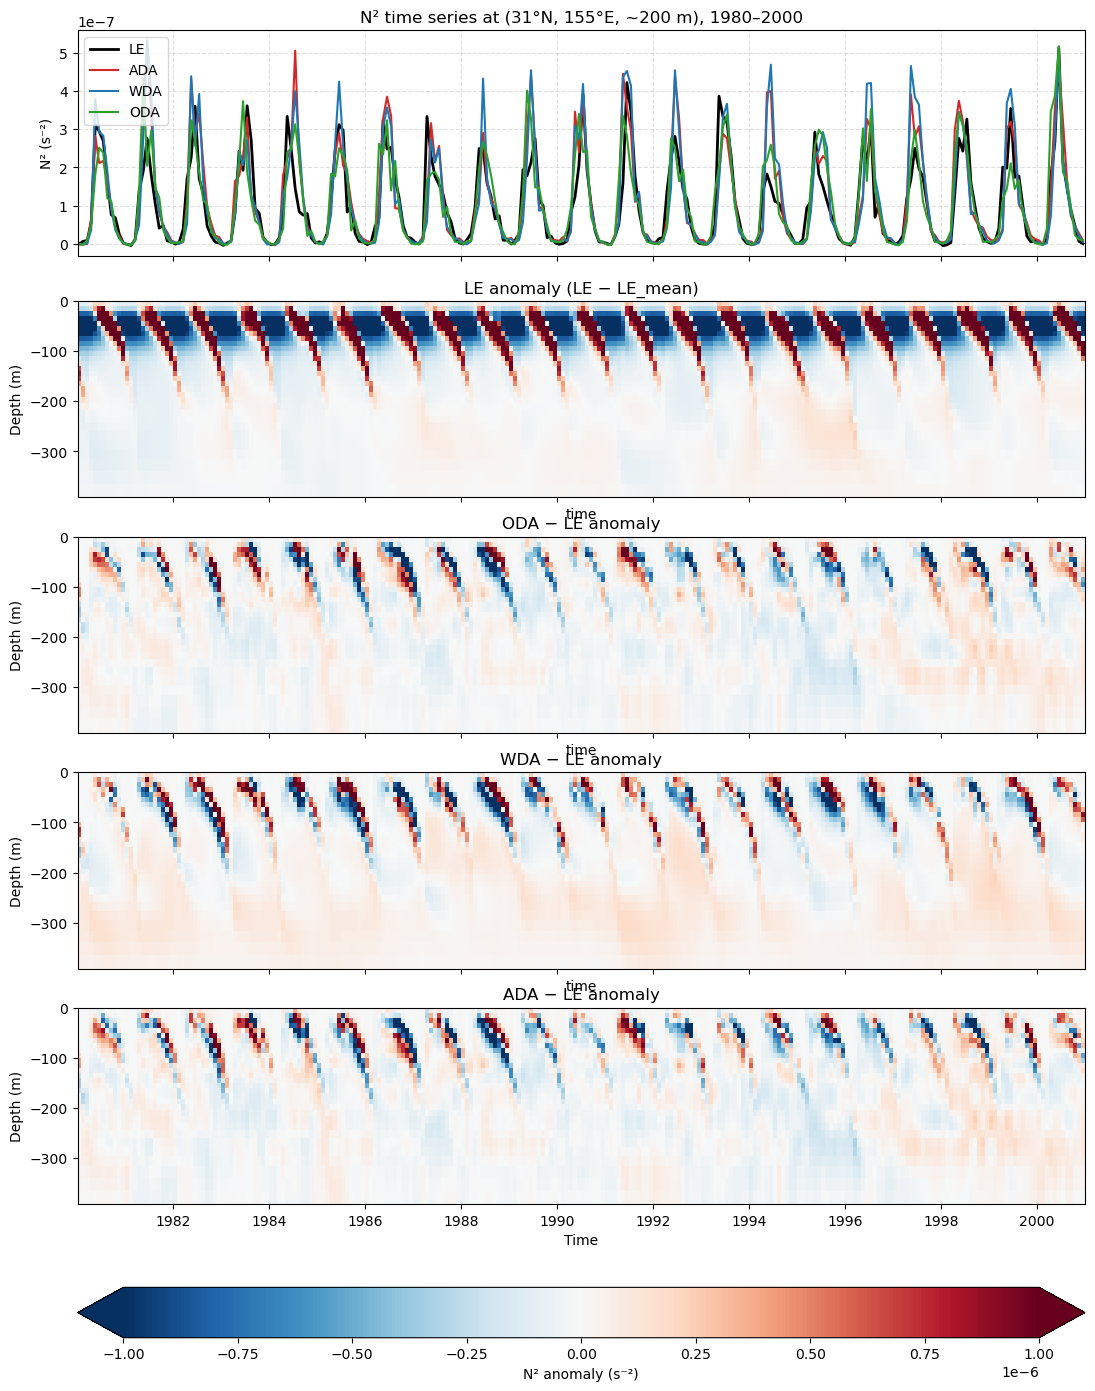

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    """Safely convert cftime.DatetimeNoLeap to numpy.datetime64 for plotting."""
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da


# ==========================================================
# 2) Helper: extract single-point N₂ time series
# ==========================================================
def extract_n2_point(ds_n2, lat_pt=31, lon_pt=155, depth_pt=-200):
    """Extract N₂ time series at a specific point (nearest grid)."""
    ds_n2 = ds_n2.assign_coords(z_t=-ds_n2.z_t / 100.0)  # cm → m, flip sign
    da_point = (
        ds_n2
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point


# ==========================================================
# 3) Helper: extract N₂ time–depth section
# ==========================================================
def extract_n2_hovmoller(ds_n2, lat_pt=31, lon_pt=155, depth_range=(-5, -400)):
    """Extract N₂ time–depth section (Hovmöller) at fixed (lat, lon)."""
    # ds_n2 = ds_n2.assign_coords(z_t=-ds_n2.z_t / 100.0)
    da = (
        ds_n2
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da


# ==========================================================
# 4) Extract datasets
# ==========================================================
ts_LE  = extract_n2_point(N2_LE_rgd)
ts_ADA = extract_n2_point(N2_ADA_rgd)
ts_WDA = extract_n2_point(N2_WDA_rgd)
ts_ODA = extract_n2_point(N2_ODA_rgd)

hov_LE  = extract_n2_hovmoller(N2_LE_rgd)
hov_ADA = extract_n2_hovmoller(N2_ADA_rgd)
hov_WDA = extract_n2_hovmoller(N2_WDA_rgd)
hov_ODA = extract_n2_hovmoller(N2_ODA_rgd)

# Convert CFTime → datetime64
ts_LE, ts_ADA, ts_WDA, ts_ODA = map(convert_cftime_to_datetime, [ts_LE, ts_ADA, ts_WDA, ts_ODA])
hov_LE, hov_ADA, hov_WDA, hov_ODA = map(convert_cftime_to_datetime, [hov_LE, hov_ADA, hov_WDA, hov_ODA])

print(f"Grid (LE): lon={float(hov_LE.lon.values):.2f}, lat={float(hov_LE.lat.values):.2f}")

# ==========================================================
# 🔹 5) Restrict to 1980–2000 period only
# ==========================================================
start_date = np.datetime64("1980-01-01")
end_date   = np.datetime64("2000-12-31")

def slice_time(da, start, end):
    """Subset data along time axis."""
    return da.sel(time=slice(start, end))

ts_LE  = slice_time(ts_LE, start_date, end_date)
ts_ADA = slice_time(ts_ADA, start_date, end_date)
ts_WDA = slice_time(ts_WDA, start_date, end_date)
ts_ODA = slice_time(ts_ODA, start_date, end_date)

hov_LE  = slice_time(hov_LE, start_date, end_date)
hov_ADA = slice_time(hov_ADA, start_date, end_date)
hov_WDA = slice_time(hov_WDA, start_date, end_date)
hov_ODA = slice_time(hov_ODA, start_date, end_date)

# ==========================================================
# 6) Compute anomalies
# ==========================================================
hov_LE_anom  = hov_LE - hov_LE.mean(dim="time")  # LE vs its mean
hov_ADA_anom = hov_ADA - hov_LE
hov_WDA_anom = hov_WDA - hov_LE
hov_ODA_anom = hov_ODA - hov_LE

# ==========================================================
# 7) Plot (5 rows: time series + LE anomaly + others)
# ==========================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(13, 17), sharex=True)

# ---------- (1) Time series ----------
axes[0].plot(ts_LE.time,  ts_LE,  label="LE",  color="k", lw=2)
axes[0].plot(ts_ADA.time, ts_ADA, label="ADA", color="C3")
axes[0].plot(ts_WDA.time, ts_WDA, label="WDA", color="C0")
axes[0].plot(ts_ODA.time, ts_ODA, label="ODA", color="C2")
axes[0].set_title("N² time series at (31°N, 155°E, ~200 m), 1980–2000")
axes[0].set_ylabel("N² (s⁻²)")
axes[0].grid(True, ls="--", alpha=0.4)
axes[0].legend()

# ---------- (2–5) Hovmöllers ----------
plot_kw_anom = dict(x="time", y="z_t", cmap="RdBu_r", vmin=-1e-6, vmax=1e-6, add_colorbar=False)

# (2) LE anomaly (relative to its full-period mean)
p0 = hov_LE_anom.plot(ax=axes[1], **plot_kw_anom)
axes[1].set_title("LE anomaly (LE − LE_mean)")

# (3) ODA − LE
p1 = hov_ODA_anom.plot(ax=axes[2], **plot_kw_anom)
axes[2].set_title("ODA − LE anomaly")

# (4) WDA − LE
p2 = hov_WDA_anom.plot(ax=axes[3], **plot_kw_anom)
axes[3].set_title("WDA − LE anomaly")

# (5) ADA − LE
p3 = hov_ADA_anom.plot(ax=axes[4], **plot_kw_anom)
axes[4].set_title("ADA − LE anomaly")

# ---------- Axis setup ----------
for ax in axes[1:]:
    ax.set_ylabel("Depth (m)")
    # ax.invert_yaxis()
axes[-1].set_xlabel("Time")

# ---------- Shared horizontal colorbar ----------
cbar = fig.colorbar(
    p3, ax=axes[1:], orientation="horizontal",
    fraction=0.05, pad=0.08, extend="both"
)
cbar.set_label("N² anomaly (s⁻²)")

# plt.tight_layout()
plt.show()


Grid (LE): lon=155.00, lat=31.00


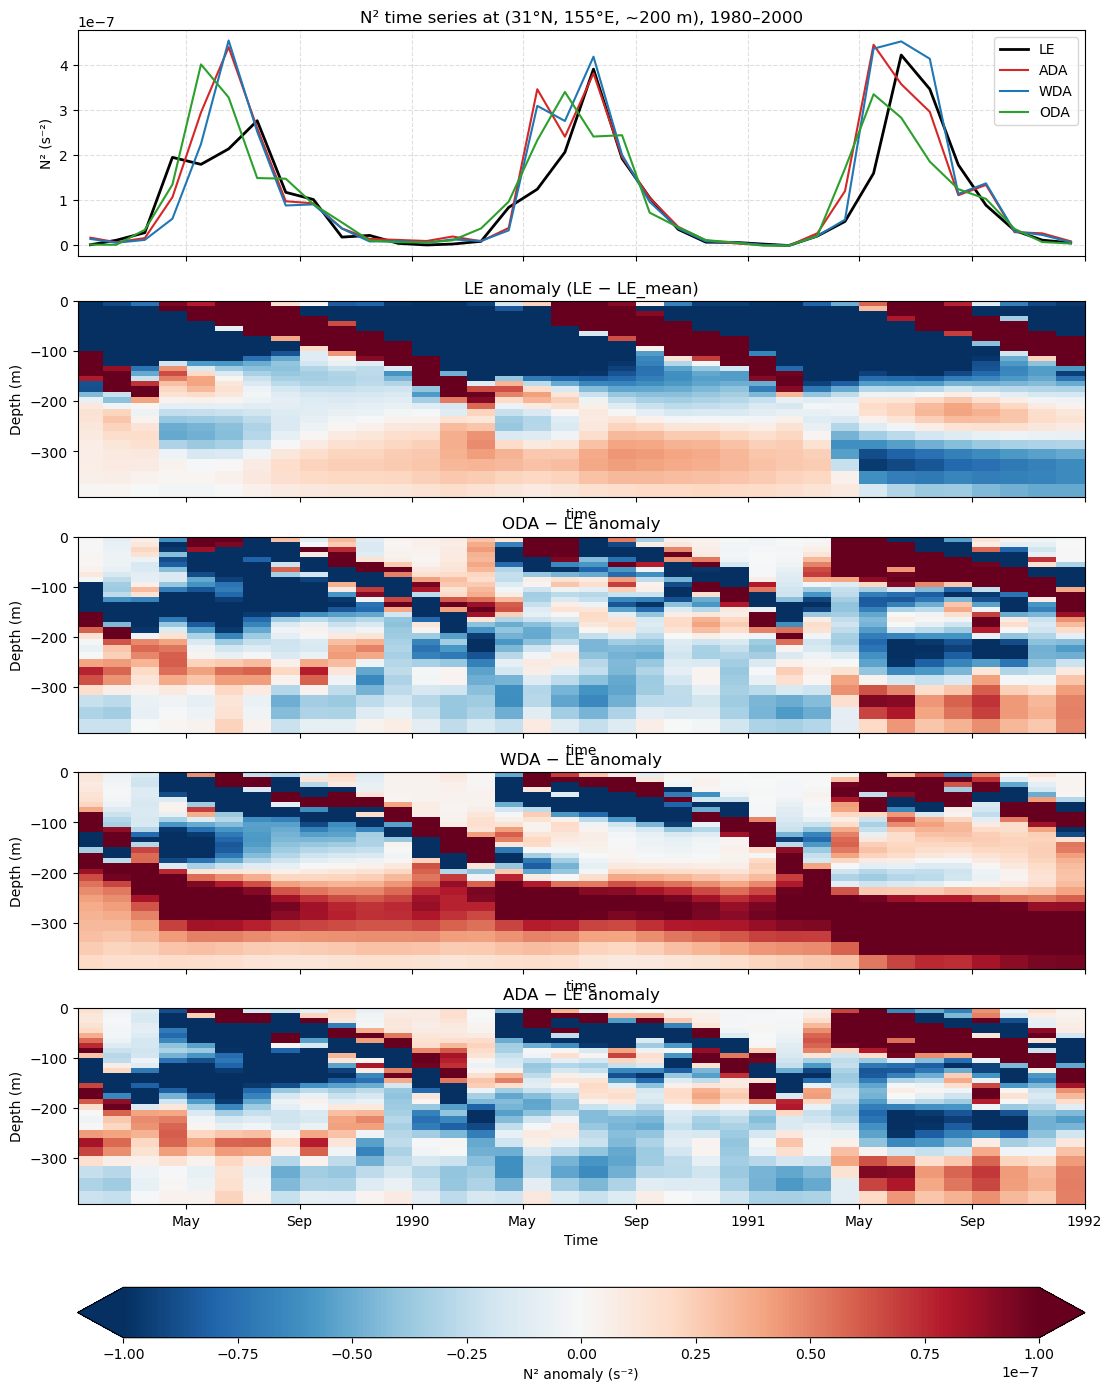

In [178]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    """Safely convert cftime.DatetimeNoLeap to numpy.datetime64 for plotting."""
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da


# ==========================================================
# 2) Helper: extract single-point N₂ time series
# ==========================================================
def extract_n2_point(ds_n2, lat_pt=31, lon_pt=155, depth_pt=-200):
    """Extract N₂ time series at a specific point (nearest grid)."""
    ds_n2 = ds_n2.assign_coords(z_t=-ds_n2.z_t / 100.0)  # cm → m, flip sign
    da_point = (
        ds_n2
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point


# ==========================================================
# 3) Helper: extract N₂ time–depth section
# ==========================================================
def extract_n2_hovmoller(ds_n2, lat_pt=31, lon_pt=155, depth_range=(-5, -400)):
    """Extract N₂ time–depth section (Hovmöller) at fixed (lat, lon)."""
    # ds_n2 = ds_n2.assign_coords(z_t=-ds_n2.z_t / 100.0)
    da = (
        ds_n2
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=slice(*depth_range))
    )
    return da


# ==========================================================
# 4) Extract datasets
# ==========================================================
ts_LE  = extract_n2_point(N2_LE_rgd)
ts_ADA = extract_n2_point(N2_ADA_rgd)
ts_WDA = extract_n2_point(N2_WDA_rgd)
ts_ODA = extract_n2_point(N2_ODA_rgd)

hov_LE  = extract_n2_hovmoller(N2_LE_rgd)
hov_ADA = extract_n2_hovmoller(N2_ADA_rgd)
hov_WDA = extract_n2_hovmoller(N2_WDA_rgd)
hov_ODA = extract_n2_hovmoller(N2_ODA_rgd)

# Convert CFTime → datetime64
ts_LE, ts_ADA, ts_WDA, ts_ODA = map(convert_cftime_to_datetime, [ts_LE, ts_ADA, ts_WDA, ts_ODA])
hov_LE, hov_ADA, hov_WDA, hov_ODA = map(convert_cftime_to_datetime, [hov_LE, hov_ADA, hov_WDA, hov_ODA])

print(f"Grid (LE): lon={float(hov_LE.lon.values):.2f}, lat={float(hov_LE.lat.values):.2f}")

# ==========================================================
# 🔹 5) Restrict to 1989–1991 period only
# ==========================================================
start_date = np.datetime64("1989-01-01")
end_date   = np.datetime64("1991-12-31")

def slice_time(da, start, end):
    """Subset data along time axis."""
    return da.sel(time=slice(start, end))

ts_LE  = slice_time(ts_LE, start_date, end_date)
ts_ADA = slice_time(ts_ADA, start_date, end_date)
ts_WDA = slice_time(ts_WDA, start_date, end_date)
ts_ODA = slice_time(ts_ODA, start_date, end_date)

hov_LE  = slice_time(hov_LE, start_date, end_date)
hov_ADA = slice_time(hov_ADA, start_date, end_date)
hov_WDA = slice_time(hov_WDA, start_date, end_date)
hov_ODA = slice_time(hov_ODA, start_date, end_date)

# ==========================================================
# 6) Compute anomalies
# ==========================================================
hov_LE_anom  = hov_LE - hov_LE.mean(dim="time")  # LE vs its mean
hov_ADA_anom = hov_ADA - hov_LE
hov_WDA_anom = hov_WDA - hov_LE
hov_ODA_anom = hov_ODA - hov_LE

# ==========================================================
# 7) Plot (5 rows: time series + LE anomaly + others)
# ==========================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(13, 17), sharex=True)

# ---------- (1) Time series ----------
axes[0].plot(ts_LE.time,  ts_LE,  label="LE",  color="k", lw=2)
axes[0].plot(ts_ADA.time, ts_ADA, label="ADA", color="C3")
axes[0].plot(ts_WDA.time, ts_WDA, label="WDA", color="C0")
axes[0].plot(ts_ODA.time, ts_ODA, label="ODA", color="C2")
axes[0].set_title("N² time series at (31°N, 155°E, ~200 m), 1980–2000")
axes[0].set_ylabel("N² (s⁻²)")
axes[0].grid(True, ls="--", alpha=0.4)
axes[0].legend()

# ---------- (2–5) Hovmöllers ----------
plot_kw_anom = dict(x="time", y="z_t", cmap="RdBu_r", vmin=-1e-7, vmax=1e-7, add_colorbar=False)

# (2) LE anomaly (relative to its full-period mean)
p0 = hov_LE_anom.plot(ax=axes[1], **plot_kw_anom)
axes[1].set_title("LE anomaly (LE − LE_mean)")

# (3) ODA − LE
p1 = hov_ODA_anom.plot(ax=axes[2], **plot_kw_anom)
axes[2].set_title("ODA − LE anomaly")

# (4) WDA − LE
p2 = hov_WDA_anom.plot(ax=axes[3], **plot_kw_anom)
axes[3].set_title("WDA − LE anomaly")

# (5) ADA − LE
p3 = hov_ADA_anom.plot(ax=axes[4], **plot_kw_anom)
axes[4].set_title("ADA − LE anomaly")

# ---------- Axis setup ----------
for ax in axes[1:]:
    ax.set_ylabel("Depth (m)")
    # ax.invert_yaxis()
axes[-1].set_xlabel("Time")

# ---------- Shared horizontal colorbar ----------
cbar = fig.colorbar(
    p3, ax=axes[1:], orientation="horizontal",
    fraction=0.05, pad=0.08, extend="both"
)
cbar.set_label("N² anomaly (s⁻²)")

# plt.tight_layout()
plt.show()


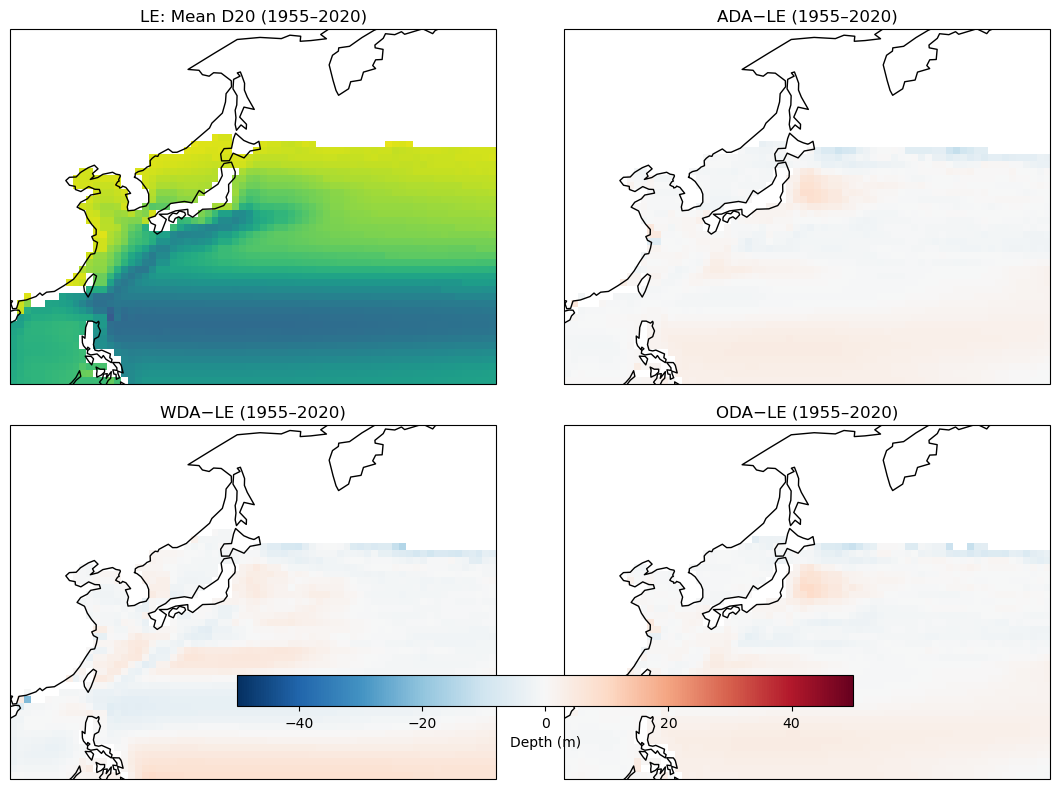

In [236]:
import xarray as xr
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ==========================================================
# 1) Function: compute 20°C isotherm depth (D20)
# ==========================================================
def compute_D20(ds_TEMP, target_temp=20.0, zmax_cm=40000, dz_cm=100):
    """
    Compute the 20°C isotherm depth (D20) at each grid cell.
    Positive depth = downward from surface.

    Parameters
    ----------
    ds_TEMP : xarray.DataArray
        4D temperature field (time, z_t, lat, lon)
    target_temp : float
        Target isotherm temperature [°C]
    zmax_cm : int
        Maximum depth for interpolation [cm]
    dz_cm : int
        Interpolation step [cm]

    Returns
    -------
    D20 : xarray.DataArray
        Depth (m) of 20°C isotherm at each grid cell
    """
    # Ensure temperature in Celsius
    TEMP = ds_TEMP
    if TEMP.max() > 200:
        TEMP = TEMP - 273.15

    z_t = TEMP["z_t"]
    z_new = np.arange(1000, zmax_cm + dz_cm, dz_cm)

    # ---------------------------------------------
    # Inner function: find 20°C crossing
    # ---------------------------------------------
    def find_D20(T_profile, z_profile):
        valid = np.isfinite(T_profile)
        if valid.sum() < 2:
            return np.nan

        f = interp1d(z_profile[valid], T_profile[valid],
                     kind="linear", bounds_error=False, fill_value=np.nan)
        T_interp = f(z_new)
        diff = T_interp - target_temp
        sign_change = np.where(np.diff(np.sign(diff)) != 0)[0]
        if len(sign_change) == 0:
            return np.nan

        i = sign_change[0]
        z1, z2 = z_new[i], z_new[i+1]
        T1, T2 = T_interp[i], T_interp[i+1]
        D20_cm = z1 + (target_temp - T1) * (z2 - z1) / (T2 - T1)
        return D20_cm / 100.0  # convert to meters

    # Apply along vertical dimension
    D20 = xr.apply_ufunc(
        find_D20,
        TEMP,
        z_t,
        input_core_dims=[["z_t"], ["z_t"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )

    D20.name = "D20"
    D20.attrs["long_name"] = "20°C isotherm depth"
    D20.attrs["units"] = "m"
    return D20


# ==========================================================
# 2) Apply to each experiment
# ==========================================================
D20_LE  = compute_D20(cfg_var_TEMP.LE_ds_rgd)
D20_ADA = compute_D20(cfg_var_TEMP.ADA_ds_rgd)
D20_WDA = compute_D20(cfg_var_TEMP.WDA_ds_rgd)
D20_ODA = compute_D20(cfg_var_TEMP.ODA_ds_rgd)

# ==========================================================
# 3) Compute long-term mean (1955–2020)
# ==========================================================
def get_longterm_mean(ds, start_year=1955, end_year=2020):
    """Return time mean over given year range."""
    return ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean("time")

D20_LE_mean  = get_longterm_mean(D20_LE)
D20_ADA_mean = get_longterm_mean(D20_ADA)
D20_WDA_mean = get_longterm_mean(D20_WDA)
D20_ODA_mean = get_longterm_mean(D20_ODA)

# Compute anomalies (Exp − LE)
D20_ADA_anom = D20_ADA_mean - D20_LE_mean
D20_WDA_anom = D20_WDA_mean - D20_LE_mean
D20_ODA_anom = D20_ODA_mean - D20_LE_mean





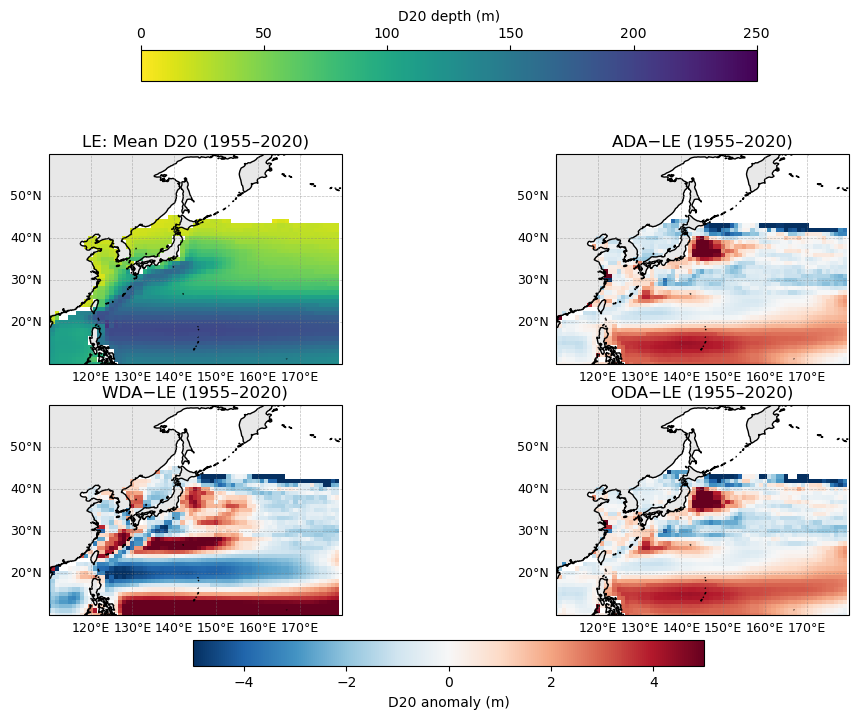

In [254]:
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

# ==========================================================
# 4) Plot 2×2 panels: D20 mean and anomalies
# ==========================================================
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# (1,1) LE mean
p0 = D20_LE_mean.plot(
    ax=axes[0,0], transform=ccrs.PlateCarree(),
    cmap="viridis_r", vmin=0, vmax=250,
    add_colorbar=False
)
axes[0,0].coastlines()
axes[0,0].add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5)
axes[0,0].set_title("LE: Mean D20 (1955–2020)")

# (1,2–2,2) anomaly panels
for ax, (name, da) in zip(
    axes.flat[1:],
    [("ADA−LE", D20_ADA_anom), ("WDA−LE", D20_WDA_anom), ("ODA−LE", D20_ODA_anom)]
):
    p = da.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap="RdBu_r", vmin=-5, vmax=5,
        add_colorbar=False
    )
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5)
    ax.set_title(f"{name} (1955–2020)")

# ==========================================================
# Adjust region (lon=110–190, lat=10–60)
# ==========================================================
for ax in axes.flat:
    ax.set_extent([110, 180, 10, 60], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False  # only left/bottom labels
    gl.xlabel_style = {'size': 9}
    gl.ylabel_style = {'size': 9}
    # set ticks based on region
    # ax.set_xticks(np.arange(110, 181, 20), crs=ccrs.PlateCarree())
    # ax.set_yticks(np.arange(10, 61, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# ==========================================================
# Figure-level colorbars (outside)
# ==========================================================
# Top colorbar for LE mean
cbar0 = fig.colorbar(
    p0, ax=axes, orientation="horizontal",
    fraction=0.05, pad=0.12, label="D20 depth (m)",
    anchor=(0.5, 1.0), shrink=0.7, location="top"
)

# Bottom colorbar for anomalies
cbar1 = fig.colorbar(
    p, ax=axes, orientation="horizontal",
    fraction=0.05, pad=0.05, label="D20 anomaly (m)"
)

# plt.tight_layout()
plt.show()


In [251]:
import xarray as xr
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ==========================================================
# 1) Function: compute 2000 µmol kg⁻¹ isosurface depth (D2000)
# ==========================================================
def compute_D2000(ds_DIC, target_dic=2000.0, zmax_cm=40000, dz_cm=100):
    """
    Compute the depth where DIC = 2000 µmol kg⁻¹ (D2000).
    Positive depth = downward from surface.

    Parameters
    ----------
    ds_DIC : xarray.DataArray
        4D DIC field (time, z_t, lat, lon)
    target_dic : float
        Target isosurface value [µmol kg⁻¹]
    zmax_cm : int
        Maximum depth for interpolation [cm]
    dz_cm : int
        Interpolation step [cm]

    Returns
    -------
    D2000 : xarray.DataArray
        Depth (m) of 2000 µmol kg⁻¹ isosurface at each grid cell
    """
    DIC = ds_DIC
    z_t = DIC["z_t"]
    z_new = np.arange(1000, zmax_cm + dz_cm, dz_cm)

    # ---------------------------------------------
    # Inner function: find 2000 µmol kg⁻¹ crossing
    # ---------------------------------------------
    def find_D2000(DIC_profile, z_profile):
        valid = np.isfinite(DIC_profile)
        if valid.sum() < 2:
            return np.nan

        f = interp1d(
            z_profile[valid], DIC_profile[valid],
            kind="linear", bounds_error=False, fill_value=np.nan
        )
        DIC_interp = f(z_new)
        diff = DIC_interp - target_dic
        sign_change = np.where(np.diff(np.sign(diff)) != 0)[0]
        if len(sign_change) == 0:
            return np.nan

        i = sign_change[0]
        z1, z2 = z_new[i], z_new[i + 1]
        D1, D2 = DIC_interp[i], DIC_interp[i + 1]
        D2000_cm = z1 + (target_dic - D1) * (z2 - z1) / (D2 - D1)
        return D2000_cm / 100.0  # convert cm → m

    # Apply along vertical dimension
    D2000 = xr.apply_ufunc(
        find_D2000,
        DIC,
        z_t,
        input_core_dims=[["z_t"], ["z_t"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )

    D2000.name = "D2000"
    D2000.attrs["long_name"] = "Depth of 2000 µmol kg⁻¹ DIC isosurface"
    D2000.attrs["units"] = "m"
    return D2000


# ==========================================================
# 2) Apply to each experiment
# ==========================================================
D2000_LE  = compute_D2000(cfg_var_DIC.LE_ds_rgd)
D2000_ADA = compute_D2000(cfg_var_DIC.ADA_ds_rgd)
D2000_WDA = compute_D2000(cfg_var_DIC.WDA_ds_rgd)
D2000_ODA = compute_D2000(cfg_var_DIC.ODA_ds_rgd)

# ==========================================================
# 3) Compute long-term mean (1955–2020)
# ==========================================================
def get_longterm_mean(ds, start_year=1955, end_year=2020):
    """Return time mean over given year range."""
    return ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean("time")

D2000_LE_mean  = get_longterm_mean(D2000_LE)
D2000_ADA_mean = get_longterm_mean(D2000_ADA)
D2000_WDA_mean = get_longterm_mean(D2000_WDA)
D2000_ODA_mean = get_longterm_mean(D2000_ODA)

# Compute anomalies (Exp − LE)
D2000_ADA_anom = D2000_ADA_mean - D2000_LE_mean
D2000_WDA_anom = D2000_WDA_mean - D2000_LE_mean
D2000_ODA_anom = D2000_ODA_mean - D2000_LE_mean


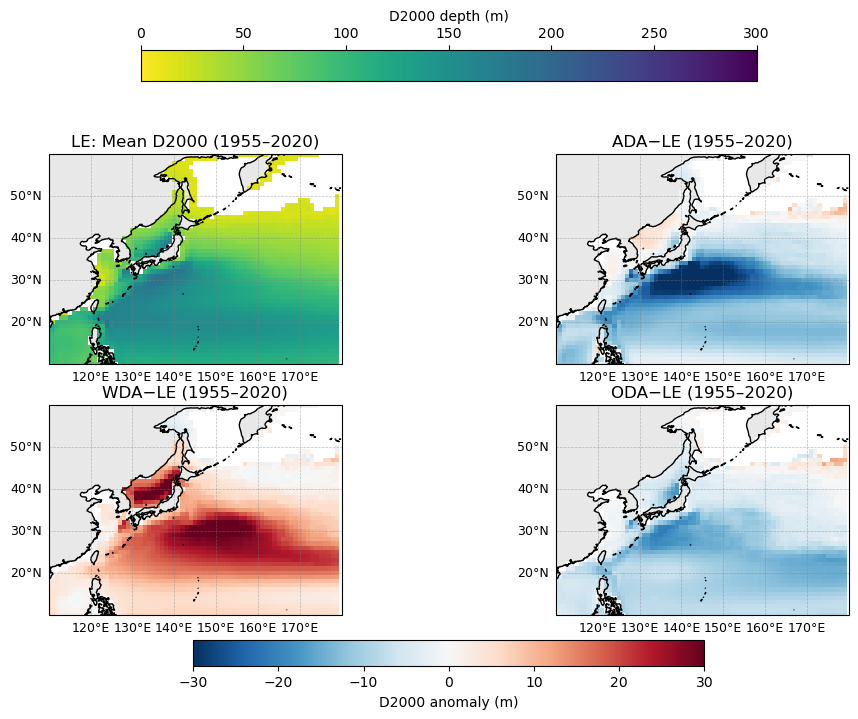

In [255]:
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

# ==========================================================
# 4) Plot 2×2 panels: D2000 mean and anomalies
# ==========================================================
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# (1,1) LE mean
p0 = D2000_LE_mean.plot(
    ax=axes[0,0], transform=ccrs.PlateCarree(),
    cmap="viridis_r", vmin=0, vmax=300,
    add_colorbar=False
)
axes[0,0].coastlines()
axes[0,0].add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5)
axes[0,0].set_title("LE: Mean D2000 (1955–2020)")

# (1,2–2,2) anomaly panels
for ax, (name, da) in zip(
    axes.flat[1:],
    [("ADA−LE", D2000_ADA_anom), ("WDA−LE", D2000_WDA_anom), ("ODA−LE", D2000_ODA_anom)]
):
    p = da.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap="RdBu_r", vmin=-30, vmax=30,
        add_colorbar=False
    )
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5)
    ax.set_title(f"{name} (1955–2020)")

# ==========================================================
# Adjust region (lon=110–180, lat=10–60)
# ==========================================================
for ax in axes.flat:
    ax.set_extent([110, 180, 10, 60], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False  # only left/bottom labels
    gl.xlabel_style = {'size': 9}
    gl.ylabel_style = {'size': 9}
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# ==========================================================
# Figure-level colorbars (outside)
# ==========================================================
# Top colorbar for LE mean (viridis)
cbar0 = fig.colorbar(
    p0, ax=axes, orientation="horizontal",
    fraction=0.05, pad=0.12, label="D2000 depth (m)",
    anchor=(0.5, 1.0), shrink=0.7, location="top"
)

# Bottom colorbar for anomalies (RdBu)
cbar1 = fig.colorbar(
    p, ax=axes, orientation="horizontal",
    fraction=0.05, pad=0.05, label="D2000 anomaly (m)"
)

# plt.tight_layout()
plt.show()
